<img style="float: center;" src='https://github.com/spacetelescope/jwst-pipeline-notebooks/raw/main/_static/stsci_header.png' alt="stsci_logo" width="900px"/> 

<a id="title_ID"></a>
# MIRI Conagraphy Pipeline Notebook #

**Authors**: B. Nickson; MIRI branch<br>
**Last Updated**: May 5, 2025<br>
**Pipeline Version**: 1.18.1 (Build 11.3)

**Purpose**: <br>
This notebook provides a framework for processing generic Mid-Infrared Instrument (MIRI) Coronagraphic data through all three James Webb Space Telescope (JWST) pipeline stages. Data is assumed to be located in separate observation folders according to the paths set up below. Editing cells other than those in the [Configuration](#1.-Configuration) should not be necessary unless the standard pipeline processing options are modified.

**Data**: <br>
This example is set up to use F1550C coronagraphic observations of the super-Jupiter exoplanet HIP 65426 b, obtained by [Program ID](https://www.stsci.edu/jwst/science-execution/program-information) 1386 (PI: S. Hinkley). It incorporates observations of the exoplanet host star HIP 65426 at two separate roll angles (1 exposure each); a PSF reference observation of the nearby star HIP 65219, taken with a 9-pt small grid dither pattern (9 exposures total); a background observation associated with the target star, taken with a 2-pt dither (two exposures); and a background observation associated with the PSF reference target, taken with a 2-pt dither (two exposures). 

The relevant observation numbers are:

- Science observations: 8, 9<br>
- Science backgrounds: 30<br>
- Reference observations: 7<br>
- Reference backgrounds: 31<br>

Example input data to use will be downloaded automatically unless disabled (i.e., to use local files instead).


**[JWST pipeline version and CRDS context](#Set-CRDS-Context-and-Server)**:<br>
This notebook was written for the above-specified pipeline version and associated build context for this version of the JWST Calibration Pipeline. Information about this and other contexts can be found in the JWST Calibration Reference Data System (CRDS [server](https://jwst-crds.stsci.edu/)). If you use different pipeline versions, please refer to the table [here](https://jwst-crds.stsci.edu/display_build_contexts/) to determine what context to use. To learn more about the differences for the pipeline, read the relevant [documentation](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline/jwst-operations-pipeline-build-information#references).<br>

Please note that pipeline software development is a continuous process, so results in some cases may be slightly different if a subsequent version is used. **For optimal results, users are strongly encouraged to reprocess their data using the most recent pipeline version and [associated CRDS context](https://jwst-crds.stsci.edu/display_build_contexts/), taking advantage of bug fixes and algorithm improvements.**
Any [known issues](https://jwst-docs.stsci.edu/known-issues-with-jwst-data/nirspec-known-issues/nirspec-mos-known-issues#NIRSpecFSKnownIssues-Resamplingof2-Dspectra&gsc.tab=0:~:text=MOS%20Known%20Issues-,NIRSpec%20MOS%20Known%20Issues,-Known%20issues%20specific) for this build are noted in the notebook. 

**Updates**:<br>
This notebook is regularly updated as improvements are made to the pipeline. Find the most up to date version of this notebook at:
[https://github.com/spacetelescope/jwst-pipeline-notebooks/](https://github.com/spacetelescope/jwst-pipeline-notebooks/)

**Recent Changes**:<br>
Jan 28, 2025: Migrate from the `Coronagraphy_ExambleNB` notebook, update to Build 11.2 (jwst 1.17.1).<br>
May 5, 2025: Updated to jwst 1.18.0 (no significant changes)

<hr style="border:1px solid gray"> </hr>

## Table of Contents

1. [Configuration](#1.-Configuration)
2. [Package Imports](#2.-Package-Imports)
3. [Demo Mode Setup](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data))
4. [Directory Setup](#4.-Directory-Setup)
5. [Detector1 Pipeline](#5.-Detector1-Pipeline)
6. [Image2 Pipeline](#6.-Image2-Pipeline)
7. [Coron3 Pipeline](#7.-Coron3-Pipeline)
8. [Plot the spectra](#8.-Plot-the-spectra)

<hr style="border:1px solid gray"> </hr>

## 1.-Configuration
------------------
Set basic parameters to use with this notebook. These will affect what data is used, where data is located (if already in disk), and pipeline modules run on this data. The list of parameters are as follows:

* demo_mode
* directories with data
* mask
* filter
* pipeline modules

In [1]:
# Basic import necessary for configuration
import os

<div class="alert alert-block alert-warning">
Note that <code>demo_mode</code> must be set appropriately below.
</div>

Set <code>demo_mode = True</code> to run in demonstration mode. In this mode, this
notebook will download example data from the
Barbara A. Mikulski Archive for Space Telescopes [(MAST)](https://archive.stsci.edu/) and process it through the pipeline.
This will all happen in a local directory unless modified
in [Section 3](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data)) below. 

Set <code>demo_mode = False</code> if you want to process your own data that has already
been downloaded and provide the location of the data.<br>

In [2]:
# Set parameters for demo_mode, mask, filter, data mode directories, and 
# processing steps.

# -------------------------------Demo Mode---------------------------------
demo_mode = True

if demo_mode:
    print('Running in demonstration mode using online example data!')

# -------------------------Data Mode Directories---------------------------
# If demo_mode = False, look for user data in these paths
if not demo_mode:
    # Set directory paths for processing specific data; these will need
    # to be changed to your local directory setup (below are given as
    # examples)
    basedir = os.path.join(os.path.expanduser('~'), 'FlightData1386/')

    # Point to where science observation data are
    # Assumes uncalibrated data in sci_r1_dir/uncal/ and sci_r2_dir/uncal/, 
    # and results in stage1, stage2, stage3 directories
    sci_r1_dir = os.path.join(basedir, 'sci_r1/')
    sci_r2_dir = os.path.join(basedir, 'sci_r2/')

    # Point to where reference target observation data are
    # Assumes uncalibrated data in ref_dir/uncal/ and results in stage1,
    # stage2, stage3 directories
    ref_targ_dir = os.path.join(basedir, 'ref_targ/')

    # Point to where background observation data are
    # Assumes uncalibrated data in sci_bg_dir/uncal/ and ref_targ_bg_dir/uncal/,
    # and results in stage1, stage2 directories
    bg_sci_dir = os.path.join(basedir, 'bg_sci/')
    bg_ref_targ_dir = os.path.join(basedir, 'bg_ref_targ/')

# --------------------------Set Processing Steps--------------------------
# Whether or not to process only data from a given coronagraphic mask/
# filter (useful if overriding reference files) 
# Note that BOTH parameters must be set in order to work
use_mask = '4QPM_1550'  # '4QPM_1065', '4QPM_1140', '4QPM_1550', or 'LYOT_2300'
use_filter = 'F1550C'  # 'F1065C', 'F1140C', 'F1550C', or 'F2300C'

# Individual pipeline stages can be turned on/off here. Note that a later
# stage won't be able to run unless data products have already been
# produced from the prior stage.

# Science processing
dodet1 = True  # calwebb_detector1
doimage2 = True  # calwebb_image2
docoron3 = True  # calwebb_coron3

# Background processing
dodet1bg = True  # calwebb_detector1
doimage2bg = True  # calwebb_image2

Running in demonstration mode using online example data!


### Set CRDS context and server
Before importing <code>CRDS</code> and <code>JWST</code> modules, we need to configure our environment. This includes defining a CRDS cache directory in which to keep the reference files that will be used by the calibration pipeline.

If the root directory for the local CRDS cache directory has not been set already, it will be set to create one in the home directory.

In [3]:
# ------------------------Set CRDS context and paths----------------------
# Each version of the calibration pipeline is associated with a specific CRDS
# context file. The pipeline will select the appropriate context file behind
# the scenes while running. However, if you wish to override the default context
# file and run the pipeline with a different context, you can set that using
# the CRDS_CONTEXT environment variable. Here we show how this is done,
# although we leave the line commented out in order to use the default context.
# If you wish to specify a different context, uncomment the line below.
#%env CRDS_CONTEXT jwst_1322.pmap

# Check whether the local CRDS cache directory has been set.
# If not, set it to the user home directory
if (os.getenv('CRDS_PATH') is None):
    os.environ['CRDS_PATH'] = os.path.join(os.path.expanduser('~'), 'crds')

# Check whether the CRDS server URL has been set.  If not, set it.
if (os.getenv('CRDS_SERVER_URL') is None):
    os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

# Echo CRDS path in use
print('CRDS local filepath:', os.environ['CRDS_PATH'])
print('CRDS file server:', os.environ['CRDS_SERVER_URL'])

CRDS local filepath: /home/runner/crds
CRDS file server: https://jwst-crds.stsci.edu


<hr style="border:1px solid gray"> </hr>

## 2.-Package Imports
------------------

In [4]:
# Use the entire available screen width for this notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [5]:
# Basic system utilities for interacting with files
# ----------------------General Imports------------------------------------
import glob
#import copy
import time
from pathlib import Path
import re

# Numpy for doing calculations
import numpy as np

# -----------------------Astropy Imports-----------------------------------
# Astropy utilities for opening FITS and ASCII files, and downloading demo files
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord

#from astropy import time
from astroquery.mast import Observations

# -----------------------Plotting Imports----------------------------------
# Matplotlib for making plots
import matplotlib.pyplot as plt

In [6]:
# --------------JWST Calibration Pipeline Imports---------------------------
# Import the base JWST and calibration reference files packages
import jwst
import crds

# JWST pipelines (each encompassing many steps)
from jwst.pipeline import Detector1Pipeline
from jwst.pipeline import Image2Pipeline
from jwst.pipeline import Coron3Pipeline

# JWST pipeline utilities
from jwst import datamodels  # JWST datamodels
from jwst.associations import asn_from_list as afl  # Tools for creating association files
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase  # Definition of a Lvl2 association file
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base  # Definition of a Lvl3 association file

from jwst.stpipe import Step  # Import the wrapper class for pipeline steps

# Echo pipeline version and CRDS context in use
print("JWST Calibration Pipeline Version = {}".format(jwst.__version__))
print("Using CRDS Context = {}".format(crds.get_context_name('jwst')))

JWST Calibration Pipeline Version = 1.18.1


CRDS - INFO -  Calibration SW Found: jwst 1.18.1 (/usr/share/miniconda/lib/python3.13/site-packages/jwst-1.18.1.dist-info)


Using CRDS Context = jwst_1364.pmap


### Define convenience functions

Define a convenience function to select only files of a given coronagraph mask/filter from an input set

In [7]:
# Define a convenience function to select only files of a given coronagraph mask/filter from an input set
def select_mask_filter_files(files, use_mask, use_filter):
    """
    Filter FITS files based on mask and filter criteria from their headers.

    Parameters:
    -----------
    files : array-like
        List of FITS file paths to process
    use_mask : str
        Mask value to match in FITS header 'CORONMSK' key
    use_filter : str
        Filter value to match in FITS header 'FILTER' key

    Returns:
    --------
    numpy.ndarray
        Filtered array of file paths matching the criteria
    """

    # Make paths absolute paths
    for i in range(len(files)):
        files[i] = os.path.abspath(files[i])

    # Convert files to numpy array if it isn't already
    files = np.asarray(files)

    # If either mask or filter is empty, return all files
    if not use_mask or not use_filter:
        return files

    try:
        # Initialize boolean array for keeping track of matches
        keep = np.zeros(len(files), dtype=bool)

        # Process each file
        for i in range(len(files)):
            try:
                with fits.open(files[i]) as hdu:
                    hdu.verify()
                    hdr = hdu[0].header

                    # Check if requred header keywords exist
                    if ('CORONMSK' in hdr and 'FILTER' in hdr):
                        if hdr['CORONMSK'] == use_mask and hdr['FILTER'] == use_filter:
                            keep[i] = True
                            files[i] = os.path.abspath(files[i])
            except (OSError, ValueError) as e:
                print(f" Warning: could not process file {files[i]}: {str(e)}")

        # Return filtered files
        indx = np.where(keep)
        return files[indx]

    except Exception as e:
        print(f"Error processing files: {str(e)}")
        return files  # Return original array in case of failure

In [8]:
# Start a timer to keep track of runtime
time0 = time.perf_counter()

<hr style="border:1px solid gray"> </hr>

## 3.-Demo Mode Setup (ignore if not using demo data)
------------------

If running in demonstration mode, set up the program information to
retrieve the uncalibrated data automatically from MAST using
[astroquery](https://astroquery.readthedocs.io/en/latest/mast/mast.html).
MAST allows for flexibility of searching by the proposal ID and the
observation ID instead of just filenames.<br>

For illustrative purposes, we focus on data taken through the MIRI
[F1550C filter](https://jwst-docs.stsci.edu/jwst-mid-infrared-instrument/miri-observing-modes/miri-coronagraphic-imaging#MIRICoronagraphicImaging-CoronFiltersCoronagraphfilters)
and start with uncalibrated raw data products (`uncal.fits`). The files use the following naming schema:
`jw01386<obs>001_04101_0000<dith>_mirimage_uncal.fits`, where *obs* refers to the observation number and *dith* refers to the
dither step number.


More information about the JWST file naming conventions can be found at:
https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/file_naming.html

In [9]:
# Set up the program information and paths for demo program
if demo_mode:
    print('Running in demonstration mode and will download example data from MAST!')
    program = "01386"
    sci_r1_observtn = "008"  
    sci_r2_observtn = "009"  
    ref_targ_observtn = "007"      
    bg_sci_observtn = "030"  
    bg_ref_targ_observtn = "031"

    # ----------Define the base and observation directories----------
    basedir = os.path.join('.', 'miri_coro_demo_data')
    download_dir = basedir
    sci_r1_dir = os.path.join(basedir, 'Obs' + sci_r1_observtn)
    sci_r2_dir = os.path.join(basedir, 'Obs' + sci_r2_observtn)
    ref_targ_dir = os.path.join(basedir, 'Obs' + ref_targ_observtn)
    bg_sci_dir = os.path.join(basedir, 'Obs' + bg_sci_observtn)
    bg_ref_targ_dir = os.path.join(basedir, 'Obs' + bg_ref_targ_observtn)

    uncal_sci_r1_dir = os.path.join(sci_r1_dir, 'uncal')
    uncal_sci_r2_dir = os.path.join(sci_r2_dir, 'uncal')
    uncal_ref_targ_dir = os.path.join(ref_targ_dir, 'uncal')
    uncal_bg_sci_dir = os.path.join(bg_sci_dir, 'uncal')
    uncal_bg_ref_targ_dir = os.path.join(bg_ref_targ_dir, 'uncal')
    
    # Ensure filepaths for input data exist
    input_dirs = [uncal_sci_r1_dir, uncal_sci_r2_dir, uncal_ref_targ_dir, uncal_bg_sci_dir, uncal_bg_ref_targ_dir]

    for dir in input_dirs:
        if not os.path.exists(dir):
            os.makedirs(dir)

Running in demonstration mode and will download example data from MAST!


Identify list of uncalibrated files associated with visits.

In [10]:
# Obtain a list of observation IDs for the specified demo program
if demo_mode:
    obs_id_table = Observations.query_criteria(instrument_name=["MIRI/CORON"],
                                               provenance_name=["CALJWST"],
                                               proposal_id=[program])

In [11]:
# Turn the list of visits into a list of uncalibrated data files
if demo_mode:
    # Define types of files to select
    file_dict = {'uncal': {'product_type': 'SCIENCE', 'productSubGroupDescription': 'UNCAL', 'calib_level': [1]}}

    # Loop over visits identifying uncalibrated files that are associated with them
    files_to_download = []
    for exposure in (obs_id_table):
        products = Observations.get_product_list(exposure)
        for filetype, query_dict in file_dict.items():
            filtered_products = Observations.filter_products(products, productType=query_dict['product_type'],
                                                             productSubGroupDescription=query_dict['productSubGroupDescription'],
                                                             calib_level=query_dict['calib_level'])
            files_to_download.extend(filtered_products['dataURI'])

    # Cull to a unique list of files for each observation type 
    # Science roll 1 
    sci_r1_files_to_download = []
    sci_r1_files_to_download = np.unique([i for i in files_to_download if str(program + sci_r1_observtn) in i])

    # Science roll 2 
    sci_r2_files_to_download = []
    sci_r2_files_to_download = np.unique([i for i in files_to_download if str(program + sci_r2_observtn) in i])

    # PSF Reference taraget data
    ref_targ_files_to_download = []
    ref_targ_files_to_download = np.unique([i for i in files_to_download if str(program + ref_targ_observtn) in i])

    # Background files (science assoc.)
    bg_sci_files_to_download = []
    bg_sci_files_to_download = np.unique([i for i in files_to_download if str(program + bg_sci_observtn) in i])

    # Background files (reference target assoc.)
    bg_ref_targ_files_to_download = []  
    bg_ref_targ_files_to_download = np.unique([i for i in files_to_download if str(program + bg_ref_targ_observtn) in i])

    print("Science files selected for downloading: ", len(sci_r1_files_to_download) + len(sci_r1_files_to_download))
    print("PSF Reference target files selected for downloading: ", len(ref_targ_files_to_download))
    print("Background selected for downloading: ", len(bg_sci_files_to_download) + len(bg_ref_targ_files_to_download))

Science files selected for downloading:  6
PSF Reference target files selected for downloading:  11
Background selected for downloading:  4


For the demo example, there should be 6 Science files, 11 PSF Reference files and 4 Background files selected for downloading. 


Download all the uncal files and place them into the appropriate directories.

<div class="alert alert-block alert-warning">
Warning: If this notebook is halted during this step the downloaded file may be incomplete, and cause crashes later on!
</div>

In [12]:
if demo_mode:
    for filename in sci_r1_files_to_download:
        sci_r1_manifest = Observations.download_file(filename, local_path=os.path.join(uncal_sci_r1_dir, Path(filename).name))
    for filename in sci_r2_files_to_download:
        sci_r2_manifest = Observations.download_file(filename, local_path=os.path.join(uncal_sci_r2_dir, Path(filename).name))
    for filename in ref_targ_files_to_download:
        ref_targ_manifest = Observations.download_file(filename, local_path=os.path.join(uncal_ref_targ_dir, Path(filename).name))
    for filename in bg_sci_files_to_download:
        bg_manifest = Observations.download_file(filename, local_path=os.path.join(uncal_bg_sci_dir, Path(filename).name))
    for filename in bg_ref_targ_files_to_download:
        bg_ref_targ_manifest = Observations.download_file(filename, local_path=os.path.join(uncal_bg_ref_targ_dir, Path(filename).name))

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


<hr style="border:1px solid gray"> </hr>

## 4.-Directory Setup
------------------
Set up detailed paths to input/output stages here. We will set up individual `stage1/` and `stage2/` sub directories for each observation, but a single `stage3/` directory for the combined [calwebb_coron3 output products](https://jwst-pipeline.readthedocs.io/en/stable/jwst/pipeline/calwebb_coron3.html).

In [13]:
# Define output subdirectories to keep science data products organized
# Sci Roll 1
uncal_sci_r1_dir = os.path.join(sci_r1_dir, 'uncal') # uncal inputs go here
det1_sci_r1_dir = os.path.join(sci_r1_dir, 'stage1')  # calwebb_detector1 pipeline outputs will go here
image2_sci_r1_dir = os.path.join(sci_r1_dir, 'stage2')  # calwebb_image2 pipeline outputs will go here

# Sci Roll 2
uncal_sci_r2_dir = os.path.join(sci_r2_dir, 'uncal') # uncal inputs go here
det1_sci_r2_dir = os.path.join(sci_r2_dir, 'stage1')  # calwebb_detector1 pipeline outputs will go here
image2_sci_r2_dir = os.path.join(sci_r2_dir, 'stage2')  # calwebb_image2 pipeline outputs will go here

# Define output subdirectories to keep PSF reference target data products organized
uncal_ref_targ_dir = os.path.join(ref_targ_dir, 'uncal') # uncal inputs go here
det1_ref_targ_dir = os.path.join(ref_targ_dir, 'stage1')  # calwebb_detector1 pipeline outputs will go here
image2_ref_targ_dir = os.path.join(ref_targ_dir, 'stage2')  # calwebb_image2 pipeline outputs will go here

# Define output subdirectories to keep background data products organized
# Sci Bkg
uncal_bg_sci_dir = os.path.join(bg_sci_dir, 'uncal') # uncal inputs go here
det1_bg_sci_dir = os.path.join(bg_sci_dir, 'stage1')  # calwebb_detector1 pipeline outputs will go here
image2_bg_sci_dir = os.path.join(bg_sci_dir, 'stage2')  # calwebb_image2 pipeline outputs will go here

# Ref target Bkg
uncal_bg_ref_targ_dir = os.path.join(bg_ref_targ_dir, 'uncal') # uncal inputs go here
det1_bg_ref_targ_dir = os.path.join(bg_ref_targ_dir, 'stage1')  # calwebb_detector1 pipeline outputs will go here
image2_bg_ref_targ_dir = os.path.join(bg_ref_targ_dir, 'stage2')  # calwebb_image2 pipeline outputs will go here

coron3_dir = os.path.join(basedir, 'stage3')

# We need to check that the desired output directories exist, and if not create them
det1_dirs = [det1_sci_r1_dir, det1_sci_r2_dir, det1_ref_targ_dir, det1_bg_sci_dir, det1_bg_ref_targ_dir]
image2_dirs = [image2_sci_r1_dir, image2_sci_r2_dir, image2_ref_targ_dir, image2_bg_sci_dir, image2_bg_ref_targ_dir]

for dir in det1_dirs:
    if not os.path.exists(dir):
        os.makedirs(dir)
for dir in image2_dirs:
    if not os.path.exists(dir):
        os.makedirs(dir)
if not os.path.exists(coron3_dir):
    os.makedirs(coron3_dir)

In [14]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")

Runtime so far: 389.7206 seconds


<hr style="border:1px solid gray"> </hr>

## 5.-Detector1 Pipeline
------------------
In this section, we process our uncalibrated data through the calwebb_detector1 pipeline to create Stage 1 data products. For coronagraphic exposures, these data products include a `*_rate.fits` file (a 2D countrate product, based on averaging over all integrations in the exposure), but specifically also a `*_rateints.fits` file, a 3D countrate product, that contains the individual results of each integration, wherein 2D countrate images for each integration are stacked along the 3rd axis of the data cubes (ncols x nrows x nints). These data products have units of DN/s.

See https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline/stages-of-jwst-data-processing/calwebb_detector1

By default, all steps in the calwebb_detector1 are run for MIRI except: the [ipc](https://jwst-pipeline.readthedocs.io/en/stable/jwst/ipc/index.html#ipc-step) and [charge_migration](https://jwst-pipeline.readthedocs.io/en/stable/jwst/charge_migration/index.html#charge-migration-step) steps. There are also several steps performed for MIRI data that are not performed for other instruments. These include: [emicorr](https://jwst-pipeline.readthedocs.io/en/latest/jwst/emicorr/index.html#emicorr-step), [firstframe](https://jwst-pipeline.readthedocs.io/en/latest/jwst/firstframe/index.html#firstframe-step), [lastframe](https://jwst-pipeline.readthedocs.io/en/latest/jwst/lastframe/index.html#lastframe-step), [reset](https://jwst-pipeline.readthedocs.io/en/latest/jwst/reset/index.html#reset-step) and [rscd](https://jwst-pipeline.readthedocs.io/en/latest/jwst/rscd/index.html#rscd-step).

<div class="alert alert-block alert-warning">
To override certain steps and reference files, use the examples provided below.<br>
E.g., turn on detection of cosmic ray showers.
</div>

In [15]:
# Set up a dictionary to define how the Detector1 pipeline should be configured

# Boilerplate dictionary setup
det1dict = {}
det1dict['group_scale'], det1dict['dq_init'], det1dict['emicorr'], det1dict['saturation'] = {}, {}, {}, {}
det1dict['firstframe'], det1dict['lastframe'], det1dict['reset'], det1dict['linearity'], det1dict['rscd'] = {}, {}, {}, {}, {}
det1dict['dark_current'], det1dict['refpix'], det1dict['jump'], det1dict['ramp_fit'], det1dict['gain_scale'] = {}, {}, {}, {}, {}
det1dict['clean_flicker_noise'] = {}

# Overrides for whether or not certain steps should be skipped (example)
# skipping refpix step
#det1dict['refpix']['skip'] = True

# Overrides for various reference files
# Files should be in the base local directory or provide full path
#det1dict['dq_init']['override_mask'] = 'myfile.fits' # Bad pixel mask
#det1dict['saturation']['override_saturation'] = 'myfile.fits'  # Saturation
#det1dict['reset']['override_reset'] = 'myfile.fits'  # Reset
#det1dict['linearity']['override_linearity'] = 'myfile.fits'  # Linearity
#det1dict['rscd']['override_rscd'] = 'myfile.fits'  # RSCD
#det1dict['dark_current']['override_dark'] = 'myfile.fits'  # Dark current subtraction
#det1dict['jump']['override_gain'] = 'myfile.fits'  # Gain used by jump step
#det1dict['ramp_fit']['override_gain'] = 'myfile.fits'  # Gain used by ramp fitting step
#det1dict['jump']['override_readnoise'] = 'myfile.fits'  # Read noise used by jump step
#det1dict['ramp_fit']['override_readnoise'] = 'myfile.fits'  # Read noise used by ramp fitting step

# Turn on multi-core processing (off by default).  Choose what fraction of cores to use (quarter, half, or all)
det1dict['jump']['maximum_cores'] = 'half' 

# Save the frame-averaged dark data created during the dark current subtraction step
#det1dict['dark_current']['dark_output'] = 'dark.fits'  # Frame-averaged dark 

# Turn on detection of cosmic ray showers (off by default)
#det1dict['jump']['find_showers'] = True

<div class="alert alert-block alert-warning">
Below an example of how to insert custom pipeline steps using the
pre-hook/post-hook framework.

For more information see [Tips and Trick for working with the JWST Pipeline](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline/tips-and-tricks-for-working-with-the-jwst-pipeline)
    </div>

In [16]:
# Define a new step called XplyStep that multiplies everything by 1.0
# I.e., it does nothing, but could be changed to do something more interesting.
class XplyStep(Step):
    spec = '''
    '''
    class_alias = 'xply'

    def process(self, input_data):
        with datamodels.open(input_data) as model:
            result = model.copy()
        sci = result.data
        sci = sci * 1.0
        result.data = sci
        self.log.info('Multiplied everything by one in custom step!')
        return result


# And here we'll insert it into our pipeline dictionary to be run at the end right after the gain_scale step
det1dict['gain_scale']['post_hooks'] = [XplyStep]

### Calibrating Science Files
Look for input science files and run calwebb_detector1 pipeline using the call method. For the demo example there should be 2 input science files, one for the observation at roll 1 (Obs 8) and one for the observation at roll 2 (Obs 9).

In [17]:
uncal_sci_r1_dir

'./miri_coro_demo_data/Obs008/uncal'

In [18]:
# Look for input files of the form *uncal.fits from the science observation
sstring1 = os.path.join(uncal_sci_r1_dir, 'jw*mirimage*uncal.fits')
sstring2 = os.path.join(uncal_sci_r2_dir, 'jw*mirimage*uncal.fits')

uncal_sci_r1_files = sorted(glob.glob(sstring1))
uncal_sci_r2_files = sorted(glob.glob(sstring2))

# Check that these are the correct mask/filter to use
uncal_sci_r1_files = select_mask_filter_files(uncal_sci_r1_files, use_mask, use_filter)
uncal_sci_r2_files = select_mask_filter_files(uncal_sci_r2_files, use_mask, use_filter)

print('Found ' + str((len(uncal_sci_r1_files) + len(uncal_sci_r2_files))) + ' science input files')

Found 2 science input files


In [19]:
# Run the pipeline on these input files by a simple loop over files using
# our custom parameter dictionary
if dodet1:
    for file in uncal_sci_r1_files:
        Detector1Pipeline.call(file, steps=det1dict, save_results=True, output_dir=det1_sci_r1_dir)

    for file in uncal_sci_r2_files:
        Detector1Pipeline.call(file, steps=det1dict, save_results=True, output_dir=det1_sci_r2_dir)
else:
    print('Skipping Detector1 processing for SCI data')

2025-06-17 12:05:35,866 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_system_datalvl_0002.rmap      694 bytes  (1 / 204 files) (0 / 741.0 K bytes)


2025-06-17 12:05:36,059 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_system_calver_0048.rmap    5.3 K bytes  (2 / 204 files) (694 / 741.0 K bytes)


2025-06-17 12:05:36,271 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_system_0047.imap        385 bytes  (3 / 204 files) (6.0 K / 741.0 K bytes)


2025-06-17 12:05:36,425 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_wavelengthrange_0024.rmap    1.4 K bytes  (4 / 204 files) (6.4 K / 741.0 K bytes)


2025-06-17 12:05:36,632 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_wavecorr_0005.rmap      884 bytes  (5 / 204 files) (7.8 K / 741.0 K bytes)


2025-06-17 12:05:36,806 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_superbias_0079.rmap   36.0 K bytes  (6 / 204 files) (8.6 K / 741.0 K bytes)


2025-06-17 12:05:37,055 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_sirskernel_0001.rmap      630 bytes  (7 / 204 files) (44.6 K / 741.0 K bytes)


2025-06-17 12:05:37,215 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_sflat_0026.rmap   20.6 K bytes  (8 / 204 files) (45.3 K / 741.0 K bytes)


2025-06-17 12:05:37,477 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_saturation_0018.rmap    2.0 K bytes  (9 / 204 files) (65.9 K / 741.0 K bytes)


2025-06-17 12:05:37,676 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_refpix_0015.rmap    1.6 K bytes  (10 / 204 files) (67.9 K / 741.0 K bytes)


2025-06-17 12:05:37,858 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_readnoise_0025.rmap    2.6 K bytes  (11 / 204 files) (69.5 K / 741.0 K bytes)


2025-06-17 12:05:38,075 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pictureframe_0001.rmap      675 bytes  (12 / 204 files) (72.0 K / 741.0 K bytes)


2025-06-17 12:05:38,331 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_photom_0013.rmap      958 bytes  (13 / 204 files) (72.7 K / 741.0 K bytes)


2025-06-17 12:05:38,509 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pathloss_0008.rmap    1.2 K bytes  (14 / 204 files) (73.7 K / 741.0 K bytes)


2025-06-17 12:05:38,705 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-whitelightstep_0001.rmap      777 bytes  (15 / 204 files) (74.9 K / 741.0 K bytes)


2025-06-17 12:05:38,862 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-spec2pipeline_0013.rmap    2.1 K bytes  (16 / 204 files) (75.6 K / 741.0 K bytes)


2025-06-17 12:05:39,046 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-resamplespecstep_0002.rmap      709 bytes  (17 / 204 files) (77.8 K / 741.0 K bytes)


2025-06-17 12:05:39,232 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-outlierdetectionstep_0005.rmap    1.1 K bytes  (18 / 204 files) (78.5 K / 741.0 K bytes)


2025-06-17 12:05:39,419 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-jumpstep_0005.rmap      810 bytes  (19 / 204 files) (79.6 K / 741.0 K bytes)


2025-06-17 12:05:39,573 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-image2pipeline_0008.rmap    1.0 K bytes  (20 / 204 files) (80.4 K / 741.0 K bytes)


2025-06-17 12:05:39,770 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-detector1pipeline_0003.rmap    1.1 K bytes  (21 / 204 files) (81.4 K / 741.0 K bytes)


2025-06-17 12:05:39,925 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-darkpipeline_0003.rmap      872 bytes  (22 / 204 files) (82.5 K / 741.0 K bytes)


2025-06-17 12:05:40,087 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-darkcurrentstep_0003.rmap    1.8 K bytes  (23 / 204 files) (83.4 K / 741.0 K bytes)


2025-06-17 12:05:40,319 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ote_0030.rmap    1.3 K bytes  (24 / 204 files) (85.2 K / 741.0 K bytes)


2025-06-17 12:05:40,474 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_msaoper_0016.rmap    1.5 K bytes  (25 / 204 files) (86.4 K / 741.0 K bytes)


2025-06-17 12:05:40,633 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_msa_0027.rmap    1.3 K bytes  (26 / 204 files) (87.9 K / 741.0 K bytes)


2025-06-17 12:05:40,862 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_mask_0043.rmap    3.5 K bytes  (27 / 204 files) (89.2 K / 741.0 K bytes)


2025-06-17 12:05:41,021 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_linearity_0017.rmap    1.6 K bytes  (28 / 204 files) (92.7 K / 741.0 K bytes)


2025-06-17 12:05:41,221 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ipc_0006.rmap      876 bytes  (29 / 204 files) (94.3 K / 741.0 K bytes)


2025-06-17 12:05:41,383 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ifuslicer_0017.rmap    1.5 K bytes  (30 / 204 files) (95.2 K / 741.0 K bytes)


2025-06-17 12:05:41,539 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ifupost_0019.rmap    1.5 K bytes  (31 / 204 files) (96.7 K / 741.0 K bytes)


2025-06-17 12:05:42,089 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ifufore_0017.rmap    1.5 K bytes  (32 / 204 files) (98.2 K / 741.0 K bytes)


2025-06-17 12:05:42,250 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_gain_0023.rmap    1.8 K bytes  (33 / 204 files) (99.7 K / 741.0 K bytes)


2025-06-17 12:05:42,410 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_fpa_0028.rmap    1.3 K bytes  (34 / 204 files) (101.5 K / 741.0 K bytes)


2025-06-17 12:05:42,576 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_fore_0026.rmap    5.0 K bytes  (35 / 204 files) (102.7 K / 741.0 K bytes)


2025-06-17 12:05:42,733 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_flat_0015.rmap    3.8 K bytes  (36 / 204 files) (107.7 K / 741.0 K bytes)


2025-06-17 12:05:42,960 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_fflat_0026.rmap    7.2 K bytes  (37 / 204 files) (111.5 K / 741.0 K bytes)


2025-06-17 12:05:43,117 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_extract1d_0018.rmap    2.3 K bytes  (38 / 204 files) (118.7 K / 741.0 K bytes)


2025-06-17 12:05:43,281 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_disperser_0028.rmap    5.7 K bytes  (39 / 204 files) (121.0 K / 741.0 K bytes)


2025-06-17 12:05:43,447 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_dflat_0007.rmap    1.1 K bytes  (40 / 204 files) (126.7 K / 741.0 K bytes)


2025-06-17 12:05:43,608 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_dark_0074.rmap   34.2 K bytes  (41 / 204 files) (127.9 K / 741.0 K bytes)


2025-06-17 12:05:43,815 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_cubepar_0015.rmap      966 bytes  (42 / 204 files) (162.1 K / 741.0 K bytes)


2025-06-17 12:05:43,979 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_collimator_0026.rmap    1.3 K bytes  (43 / 204 files) (163.1 K / 741.0 K bytes)


2025-06-17 12:05:44,141 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_camera_0026.rmap    1.3 K bytes  (44 / 204 files) (164.4 K / 741.0 K bytes)


2025-06-17 12:05:44,381 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_barshadow_0007.rmap    1.8 K bytes  (45 / 204 files) (165.7 K / 741.0 K bytes)


2025-06-17 12:05:44,552 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_area_0018.rmap    6.3 K bytes  (46 / 204 files) (167.5 K / 741.0 K bytes)


2025-06-17 12:05:44,713 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_apcorr_0009.rmap    5.6 K bytes  (47 / 204 files) (173.8 K / 741.0 K bytes)


2025-06-17 12:05:44,869 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_0398.imap     5.8 K bytes  (48 / 204 files) (179.3 K / 741.0 K bytes)


2025-06-17 12:05:45,024 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_wfssbkg_0010.rmap    3.1 K bytes  (49 / 204 files) (185.1 K / 741.0 K bytes)


2025-06-17 12:05:45,191 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_wavelengthrange_0006.rmap      862 bytes  (50 / 204 files) (188.2 K / 741.0 K bytes)


2025-06-17 12:05:45,346 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_trappars_0004.rmap      753 bytes  (51 / 204 files) (189.1 K / 741.0 K bytes)


2025-06-17 12:05:45,512 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_trapdensity_0005.rmap      705 bytes  (52 / 204 files) (189.9 K / 741.0 K bytes)


2025-06-17 12:05:45,668 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_throughput_0005.rmap    1.3 K bytes  (53 / 204 files) (190.6 K / 741.0 K bytes)


2025-06-17 12:05:45,837 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_superbias_0030.rmap    7.4 K bytes  (54 / 204 files) (191.8 K / 741.0 K bytes)


2025-06-17 12:05:46,042 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_specwcs_0014.rmap    3.1 K bytes  (55 / 204 files) (199.2 K / 741.0 K bytes)


2025-06-17 12:05:46,272 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_specprofile_0008.rmap    2.4 K bytes  (56 / 204 files) (202.4 K / 741.0 K bytes)


2025-06-17 12:05:46,428 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_speckernel_0006.rmap    1.0 K bytes  (57 / 204 files) (204.7 K / 741.0 K bytes)


2025-06-17 12:05:46,596 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_sirskernel_0001.rmap      627 bytes  (58 / 204 files) (205.8 K / 741.0 K bytes)


2025-06-17 12:05:46,763 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_saturation_0015.rmap      829 bytes  (59 / 204 files) (206.4 K / 741.0 K bytes)


2025-06-17 12:05:46,923 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_readnoise_0011.rmap      987 bytes  (60 / 204 files) (207.2 K / 741.0 K bytes)


2025-06-17 12:05:47,080 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_photom_0036.rmap    1.3 K bytes  (61 / 204 files) (208.2 K / 741.0 K bytes)


2025-06-17 12:05:47,279 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_persat_0007.rmap      674 bytes  (62 / 204 files) (209.5 K / 741.0 K bytes)


2025-06-17 12:05:47,437 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pathloss_0003.rmap      758 bytes  (63 / 204 files) (210.1 K / 741.0 K bytes)


2025-06-17 12:05:47,596 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pastasoss_0004.rmap      818 bytes  (64 / 204 files) (210.9 K / 741.0 K bytes)


2025-06-17 12:05:47,754 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-undersamplecorrectionstep_0001.rmap      904 bytes  (65 / 204 files) (211.7 K / 741.0 K bytes)


2025-06-17 12:05:47,910 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-tweakregstep_0012.rmap    3.1 K bytes  (66 / 204 files) (212.6 K / 741.0 K bytes)


2025-06-17 12:05:48,069 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-spec2pipeline_0008.rmap      984 bytes  (67 / 204 files) (215.8 K / 741.0 K bytes)


2025-06-17 12:05:48,226 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-sourcecatalogstep_0002.rmap    2.3 K bytes  (68 / 204 files) (216.7 K / 741.0 K bytes)


2025-06-17 12:05:48,396 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-resamplestep_0002.rmap      687 bytes  (69 / 204 files) (219.1 K / 741.0 K bytes)


2025-06-17 12:05:48,554 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-outlierdetectionstep_0004.rmap    2.7 K bytes  (70 / 204 files) (219.7 K / 741.0 K bytes)


2025-06-17 12:05:48,718 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-jumpstep_0007.rmap    6.4 K bytes  (71 / 204 files) (222.4 K / 741.0 K bytes)


2025-06-17 12:05:48,884 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-image2pipeline_0005.rmap    1.0 K bytes  (72 / 204 files) (228.8 K / 741.0 K bytes)


2025-06-17 12:05:49,046 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-detector1pipeline_0002.rmap    1.0 K bytes  (73 / 204 files) (229.8 K / 741.0 K bytes)


2025-06-17 12:05:49,212 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-darkpipeline_0002.rmap      868 bytes  (74 / 204 files) (230.8 K / 741.0 K bytes)


2025-06-17 12:05:49,371 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-darkcurrentstep_0001.rmap      591 bytes  (75 / 204 files) (231.7 K / 741.0 K bytes)


2025-06-17 12:05:49,534 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-chargemigrationstep_0004.rmap    5.7 K bytes  (76 / 204 files) (232.3 K / 741.0 K bytes)


2025-06-17 12:05:49,694 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_nrm_0005.rmap      663 bytes  (77 / 204 files) (237.9 K / 741.0 K bytes)


2025-06-17 12:05:49,853 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_mask_0022.rmap    1.3 K bytes  (78 / 204 files) (238.6 K / 741.0 K bytes)


2025-06-17 12:05:50,036 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_linearity_0022.rmap      961 bytes  (79 / 204 files) (239.9 K / 741.0 K bytes)


2025-06-17 12:05:50,193 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_ipc_0007.rmap      651 bytes  (80 / 204 files) (240.9 K / 741.0 K bytes)


2025-06-17 12:05:50,350 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_gain_0011.rmap      797 bytes  (81 / 204 files) (241.5 K / 741.0 K bytes)


2025-06-17 12:05:50,508 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_flat_0023.rmap    5.9 K bytes  (82 / 204 files) (242.3 K / 741.0 K bytes)


2025-06-17 12:05:50,674 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_filteroffset_0010.rmap      853 bytes  (83 / 204 files) (248.2 K / 741.0 K bytes)


2025-06-17 12:05:50,833 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_extract1d_0007.rmap      905 bytes  (84 / 204 files) (249.0 K / 741.0 K bytes)


2025-06-17 12:05:51,065 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_drizpars_0004.rmap      519 bytes  (85 / 204 files) (249.9 K / 741.0 K bytes)


2025-06-17 12:05:51,221 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_distortion_0025.rmap    3.4 K bytes  (86 / 204 files) (250.4 K / 741.0 K bytes)


2025-06-17 12:05:51,389 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_dark_0034.rmap    7.5 K bytes  (87 / 204 files) (253.9 K / 741.0 K bytes)


2025-06-17 12:05:51,546 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_bkg_0002.rmap    2.9 K bytes  (88 / 204 files) (261.4 K / 741.0 K bytes)


2025-06-17 12:05:51,701 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_area_0014.rmap    2.7 K bytes  (89 / 204 files) (264.3 K / 741.0 K bytes)


2025-06-17 12:05:51,867 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_apcorr_0010.rmap    4.3 K bytes  (90 / 204 files) (267.0 K / 741.0 K bytes)


2025-06-17 12:05:52,026 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_abvegaoffset_0004.rmap    1.4 K bytes  (91 / 204 files) (271.3 K / 741.0 K bytes)


2025-06-17 12:05:52,180 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_0272.imap      5.8 K bytes  (92 / 204 files) (272.7 K / 741.0 K bytes)


2025-06-17 12:05:52,347 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_wfssbkg_0004.rmap    7.2 K bytes  (93 / 204 files) (278.5 K / 741.0 K bytes)


2025-06-17 12:05:52,514 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_wavelengthrange_0010.rmap      996 bytes  (94 / 204 files) (285.7 K / 741.0 K bytes)


2025-06-17 12:05:52,667 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_tsophot_0003.rmap      896 bytes  (95 / 204 files) (286.7 K / 741.0 K bytes)


2025-06-17 12:05:52,823 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_trappars_0003.rmap    1.6 K bytes  (96 / 204 files) (287.6 K / 741.0 K bytes)


2025-06-17 12:05:52,980 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_trapdensity_0003.rmap    1.6 K bytes  (97 / 204 files) (289.2 K / 741.0 K bytes)


2025-06-17 12:05:53,144 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_superbias_0019.rmap   18.9 K bytes  (98 / 204 files) (290.8 K / 741.0 K bytes)


2025-06-17 12:05:53,361 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_specwcs_0022.rmap    7.1 K bytes  (99 / 204 files) (309.7 K / 741.0 K bytes)


2025-06-17 12:05:53,519 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_sirskernel_0002.rmap      671 bytes  (100 / 204 files) (316.8 K / 741.0 K bytes)


2025-06-17 12:05:53,679 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_saturation_0011.rmap    2.8 K bytes  (101 / 204 files) (317.5 K / 741.0 K bytes)


2025-06-17 12:05:53,845 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_readnoise_0026.rmap   25.9 K bytes  (102 / 204 files) (320.3 K / 741.0 K bytes)


2025-06-17 12:05:54,046 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_psfmask_0008.rmap   28.4 K bytes  (103 / 204 files) (346.2 K / 741.0 K bytes)


2025-06-17 12:05:54,322 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_photom_0028.rmap    3.4 K bytes  (104 / 204 files) (374.6 K / 741.0 K bytes)


2025-06-17 12:05:54,480 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_persat_0005.rmap    1.6 K bytes  (105 / 204 files) (377.9 K / 741.0 K bytes)


2025-06-17 12:05:54,644 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-whitelightstep_0004.rmap    2.0 K bytes  (106 / 204 files) (379.5 K / 741.0 K bytes)


2025-06-17 12:05:54,810 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-tweakregstep_0003.rmap    4.5 K bytes  (107 / 204 files) (381.5 K / 741.0 K bytes)


2025-06-17 12:05:54,965 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-spec2pipeline_0008.rmap      984 bytes  (108 / 204 files) (386.0 K / 741.0 K bytes)


2025-06-17 12:05:55,124 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-sourcecatalogstep_0002.rmap    4.6 K bytes  (109 / 204 files) (387.0 K / 741.0 K bytes)


2025-06-17 12:05:55,283 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-resamplestep_0002.rmap      687 bytes  (110 / 204 files) (391.6 K / 741.0 K bytes)


2025-06-17 12:05:55,442 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-outlierdetectionstep_0003.rmap      940 bytes  (111 / 204 files) (392.3 K / 741.0 K bytes)


2025-06-17 12:05:55,614 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-jumpstep_0005.rmap      806 bytes  (112 / 204 files) (393.2 K / 741.0 K bytes)


2025-06-17 12:05:55,776 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-image2pipeline_0004.rmap    1.1 K bytes  (113 / 204 files) (394.0 K / 741.0 K bytes)


2025-06-17 12:05:55,933 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-detector1pipeline_0005.rmap    1.3 K bytes  (114 / 204 files) (395.2 K / 741.0 K bytes)


2025-06-17 12:05:56,088 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-darkpipeline_0002.rmap      868 bytes  (115 / 204 files) (396.4 K / 741.0 K bytes)


2025-06-17 12:05:56,249 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-darkcurrentstep_0001.rmap      618 bytes  (116 / 204 files) (397.3 K / 741.0 K bytes)


2025-06-17 12:05:56,407 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_mask_0012.rmap    4.1 K bytes  (117 / 204 files) (397.9 K / 741.0 K bytes)


2025-06-17 12:05:56,571 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_linearity_0011.rmap    2.4 K bytes  (118 / 204 files) (402.1 K / 741.0 K bytes)


2025-06-17 12:05:56,727 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_ipc_0003.rmap    2.0 K bytes  (119 / 204 files) (404.5 K / 741.0 K bytes)


2025-06-17 12:05:56,929 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_gain_0016.rmap    2.1 K bytes  (120 / 204 files) (406.4 K / 741.0 K bytes)


2025-06-17 12:05:57,091 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_flat_0028.rmap   51.7 K bytes  (121 / 204 files) (408.6 K / 741.0 K bytes)


2025-06-17 12:05:57,342 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_filteroffset_0004.rmap    1.4 K bytes  (122 / 204 files) (460.2 K / 741.0 K bytes)


2025-06-17 12:05:57,500 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_extract1d_0005.rmap    1.2 K bytes  (123 / 204 files) (461.7 K / 741.0 K bytes)


2025-06-17 12:05:57,658 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_drizpars_0001.rmap      519 bytes  (124 / 204 files) (462.9 K / 741.0 K bytes)


2025-06-17 12:05:57,813 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_distortion_0033.rmap   53.4 K bytes  (125 / 204 files) (463.4 K / 741.0 K bytes)


2025-06-17 12:05:58,064 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_dark_0047.rmap   29.0 K bytes  (126 / 204 files) (516.7 K / 741.0 K bytes)


2025-06-17 12:05:58,270 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_area_0012.rmap   33.5 K bytes  (127 / 204 files) (545.7 K / 741.0 K bytes)


2025-06-17 12:05:58,474 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_apcorr_0008.rmap    4.3 K bytes  (128 / 204 files) (579.2 K / 741.0 K bytes)


2025-06-17 12:05:58,629 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_abvegaoffset_0003.rmap    1.3 K bytes  (129 / 204 files) (583.5 K / 741.0 K bytes)


2025-06-17 12:05:58,787 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_0314.imap      5.6 K bytes  (130 / 204 files) (584.8 K / 741.0 K bytes)


2025-06-17 12:05:58,955 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_wavelengthrange_0027.rmap      929 bytes  (131 / 204 files) (590.4 K / 741.0 K bytes)


2025-06-17 12:05:59,117 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_tsophot_0004.rmap      882 bytes  (132 / 204 files) (591.3 K / 741.0 K bytes)


2025-06-17 12:05:59,278 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_straymask_0009.rmap      987 bytes  (133 / 204 files) (592.2 K / 741.0 K bytes)


2025-06-17 12:05:59,433 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_specwcs_0043.rmap    5.8 K bytes  (134 / 204 files) (593.2 K / 741.0 K bytes)


2025-06-17 12:05:59,592 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_saturation_0015.rmap    1.2 K bytes  (135 / 204 files) (599.0 K / 741.0 K bytes)


2025-06-17 12:05:59,750 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_rscd_0008.rmap    1.0 K bytes  (136 / 204 files) (600.1 K / 741.0 K bytes)


2025-06-17 12:05:59,908 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_resol_0006.rmap      790 bytes  (137 / 204 files) (601.2 K / 741.0 K bytes)


2025-06-17 12:06:00,066 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_reset_0026.rmap    3.9 K bytes  (138 / 204 files) (602.0 K / 741.0 K bytes)


2025-06-17 12:06:00,224 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_regions_0034.rmap    5.2 K bytes  (139 / 204 files) (605.8 K / 741.0 K bytes)


2025-06-17 12:06:00,382 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_readnoise_0023.rmap    1.6 K bytes  (140 / 204 files) (611.0 K / 741.0 K bytes)


2025-06-17 12:06:00,537 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_psfmask_0009.rmap    2.1 K bytes  (141 / 204 files) (612.7 K / 741.0 K bytes)


2025-06-17 12:06:00,695 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_psf_0003.rmap      839 bytes  (142 / 204 files) (614.8 K / 741.0 K bytes)


2025-06-17 12:06:00,852 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_photom_0056.rmap    3.7 K bytes  (143 / 204 files) (615.6 K / 741.0 K bytes)


2025-06-17 12:06:01,025 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pathloss_0005.rmap      866 bytes  (144 / 204 files) (619.4 K / 741.0 K bytes)


2025-06-17 12:06:01,183 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-whitelightstep_0003.rmap      912 bytes  (145 / 204 files) (620.2 K / 741.0 K bytes)


2025-06-17 12:06:01,343 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-tweakregstep_0003.rmap    1.8 K bytes  (146 / 204 files) (621.2 K / 741.0 K bytes)


2025-06-17 12:06:01,500 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-spec3pipeline_0009.rmap      816 bytes  (147 / 204 files) (623.0 K / 741.0 K bytes)


2025-06-17 12:06:01,895 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-spec2pipeline_0012.rmap    1.3 K bytes  (148 / 204 files) (623.8 K / 741.0 K bytes)


2025-06-17 12:06:02,054 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-sourcecatalogstep_0003.rmap    1.9 K bytes  (149 / 204 files) (625.1 K / 741.0 K bytes)


2025-06-17 12:06:02,213 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-resamplestep_0002.rmap      677 bytes  (150 / 204 files) (627.0 K / 741.0 K bytes)


2025-06-17 12:06:02,385 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-resamplespecstep_0002.rmap      706 bytes  (151 / 204 files) (627.7 K / 741.0 K bytes)


2025-06-17 12:06:02,547 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-outlierdetectionstep_0020.rmap    3.4 K bytes  (152 / 204 files) (628.4 K / 741.0 K bytes)


2025-06-17 12:06:02,727 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-jumpstep_0011.rmap    1.6 K bytes  (153 / 204 files) (631.8 K / 741.0 K bytes)


2025-06-17 12:06:02,998 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-image2pipeline_0010.rmap    1.1 K bytes  (154 / 204 files) (633.4 K / 741.0 K bytes)


2025-06-17 12:06:03,153 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-extract1dstep_0003.rmap      807 bytes  (155 / 204 files) (634.5 K / 741.0 K bytes)


2025-06-17 12:06:03,320 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-emicorrstep_0003.rmap      796 bytes  (156 / 204 files) (635.3 K / 741.0 K bytes)


2025-06-17 12:06:03,485 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-detector1pipeline_0010.rmap    1.6 K bytes  (157 / 204 files) (636.1 K / 741.0 K bytes)


2025-06-17 12:06:03,663 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-darkpipeline_0002.rmap      860 bytes  (158 / 204 files) (637.7 K / 741.0 K bytes)


2025-06-17 12:06:03,821 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-darkcurrentstep_0002.rmap      683 bytes  (159 / 204 files) (638.5 K / 741.0 K bytes)


2025-06-17 12:06:03,981 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_mrsxartcorr_0002.rmap    2.2 K bytes  (160 / 204 files) (639.2 K / 741.0 K bytes)


2025-06-17 12:06:04,147 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_mrsptcorr_0005.rmap    2.0 K bytes  (161 / 204 files) (641.4 K / 741.0 K bytes)


2025-06-17 12:06:04,305 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_mask_0026.rmap    4.3 K bytes  (162 / 204 files) (643.3 K / 741.0 K bytes)


2025-06-17 12:06:04,567 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_linearity_0018.rmap    2.8 K bytes  (163 / 204 files) (647.6 K / 741.0 K bytes)


2025-06-17 12:06:04,723 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_ipc_0008.rmap      700 bytes  (164 / 204 files) (650.4 K / 741.0 K bytes)


2025-06-17 12:06:04,877 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_gain_0013.rmap    3.9 K bytes  (165 / 204 files) (651.1 K / 741.0 K bytes)


2025-06-17 12:06:05,046 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_fringefreq_0003.rmap    1.4 K bytes  (166 / 204 files) (655.0 K / 741.0 K bytes)


2025-06-17 12:06:05,287 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_fringe_0019.rmap    3.9 K bytes  (167 / 204 files) (656.5 K / 741.0 K bytes)


2025-06-17 12:06:05,445 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_flat_0066.rmap   15.7 K bytes  (168 / 204 files) (660.4 K / 741.0 K bytes)


2025-06-17 12:06:05,647 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_filteroffset_0025.rmap    2.5 K bytes  (169 / 204 files) (676.1 K / 741.0 K bytes)


2025-06-17 12:06:05,911 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_extract1d_0020.rmap    1.4 K bytes  (170 / 204 files) (678.6 K / 741.0 K bytes)


2025-06-17 12:06:06,071 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_emicorr_0003.rmap      663 bytes  (171 / 204 files) (679.9 K / 741.0 K bytes)


2025-06-17 12:06:06,229 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_drizpars_0002.rmap      511 bytes  (172 / 204 files) (680.6 K / 741.0 K bytes)


2025-06-17 12:06:06,469 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_distortion_0040.rmap    4.9 K bytes  (173 / 204 files) (681.1 K / 741.0 K bytes)


2025-06-17 12:06:06,635 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_dark_0036.rmap    4.4 K bytes  (174 / 204 files) (686.0 K / 741.0 K bytes)


2025-06-17 12:06:06,789 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_cubepar_0017.rmap      800 bytes  (175 / 204 files) (690.4 K / 741.0 K bytes)


2025-06-17 12:06:06,948 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_area_0015.rmap      866 bytes  (176 / 204 files) (691.2 K / 741.0 K bytes)


2025-06-17 12:06:07,104 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_apcorr_0019.rmap    5.0 K bytes  (177 / 204 files) (692.0 K / 741.0 K bytes)


2025-06-17 12:06:07,260 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_abvegaoffset_0003.rmap    1.3 K bytes  (178 / 204 files) (697.0 K / 741.0 K bytes)


2025-06-17 12:06:07,426 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_0437.imap        5.8 K bytes  (179 / 204 files) (698.3 K / 741.0 K bytes)


2025-06-17 12:06:07,582 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_trappars_0004.rmap      903 bytes  (180 / 204 files) (704.1 K / 741.0 K bytes)


2025-06-17 12:06:07,741 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_trapdensity_0006.rmap      930 bytes  (181 / 204 files) (705.0 K / 741.0 K bytes)


2025-06-17 12:06:07,905 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_superbias_0017.rmap    3.8 K bytes  (182 / 204 files) (706.0 K / 741.0 K bytes)


2025-06-17 12:06:08,063 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_saturation_0009.rmap      779 bytes  (183 / 204 files) (709.7 K / 741.0 K bytes)


2025-06-17 12:06:08,220 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_readnoise_0014.rmap    1.3 K bytes  (184 / 204 files) (710.5 K / 741.0 K bytes)


2025-06-17 12:06:08,391 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_photom_0014.rmap    1.1 K bytes  (185 / 204 files) (711.8 K / 741.0 K bytes)


2025-06-17 12:06:08,550 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_persat_0006.rmap      884 bytes  (186 / 204 files) (712.9 K / 741.0 K bytes)


2025-06-17 12:06:08,705 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-tweakregstep_0002.rmap      850 bytes  (187 / 204 files) (713.8 K / 741.0 K bytes)


2025-06-17 12:06:08,860 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-sourcecatalogstep_0001.rmap      636 bytes  (188 / 204 files) (714.6 K / 741.0 K bytes)


2025-06-17 12:06:09,017 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-outlierdetectionstep_0001.rmap      654 bytes  (189 / 204 files) (715.3 K / 741.0 K bytes)


2025-06-17 12:06:09,174 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-image2pipeline_0005.rmap      974 bytes  (190 / 204 files) (715.9 K / 741.0 K bytes)


2025-06-17 12:06:09,332 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-detector1pipeline_0002.rmap    1.0 K bytes  (191 / 204 files) (716.9 K / 741.0 K bytes)


2025-06-17 12:06:09,500 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-darkpipeline_0002.rmap      856 bytes  (192 / 204 files) (717.9 K / 741.0 K bytes)


2025-06-17 12:06:09,753 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_mask_0023.rmap    1.1 K bytes  (193 / 204 files) (718.8 K / 741.0 K bytes)


2025-06-17 12:06:09,916 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_linearity_0015.rmap      925 bytes  (194 / 204 files) (719.8 K / 741.0 K bytes)


2025-06-17 12:06:10,084 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_ipc_0003.rmap       614 bytes  (195 / 204 files) (720.8 K / 741.0 K bytes)


2025-06-17 12:06:10,241 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_gain_0010.rmap      890 bytes  (196 / 204 files) (721.4 K / 741.0 K bytes)


2025-06-17 12:06:10,405 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_flat_0009.rmap    1.1 K bytes  (197 / 204 files) (722.3 K / 741.0 K bytes)


2025-06-17 12:06:10,560 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_distortion_0011.rmap    1.2 K bytes  (198 / 204 files) (723.4 K / 741.0 K bytes)


2025-06-17 12:06:10,725 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_dark_0017.rmap    4.3 K bytes  (199 / 204 files) (724.6 K / 741.0 K bytes)


2025-06-17 12:06:10,893 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_area_0010.rmap    1.2 K bytes  (200 / 204 files) (728.9 K / 741.0 K bytes)


2025-06-17 12:06:11,064 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_apcorr_0004.rmap    4.0 K bytes  (201 / 204 files) (730.1 K / 741.0 K bytes)


2025-06-17 12:06:11,238 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_abvegaoffset_0002.rmap    1.3 K bytes  (202 / 204 files) (734.0 K / 741.0 K bytes)


2025-06-17 12:06:11,398 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_0123.imap         5.1 K bytes  (203 / 204 files) (735.3 K / 741.0 K bytes)


2025-06-17 12:06:11,577 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_1364.pmap               580 bytes  (204 / 204 files) (740.4 K / 741.0 K bytes)


2025-06-17 12:06:11,894 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf    1.0 K bytes  (1 / 1 files) (0 / 1.0 K bytes)


2025-06-17 12:06:12,053 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-06-17 12:06:12,068 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf      936 bytes  (1 / 1 files) (0 / 936 bytes)


2025-06-17 12:06:12,230 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-06-17 12:06:12,239 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0004.asdf    1.9 K bytes  (1 / 1 files) (0 / 1.9 K bytes)


2025-06-17 12:06:12,396 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0004.asdf


2025-06-17 12:06:12,406 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0008.asdf    1.7 K bytes  (1 / 1 files) (0 / 1.7 K bytes)


2025-06-17 12:06:12,595 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0008.asdf


2025-06-17 12:06:12,620 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-06-17 12:06:12,621 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-06-17 12:06:12,622 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-06-17 12:06:12,623 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-06-17 12:06:12,624 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-06-17 12:06:12,625 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-06-17 12:06:12,626 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-06-17 12:06:12,627 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-06-17 12:06:12,628 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-06-17 12:06:12,628 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-06-17 12:06:12,629 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-06-17 12:06:12,630 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-06-17 12:06:12,631 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-06-17 12:06:12,631 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-06-17 12:06:12,632 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-06-17 12:06:12,633 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-06-17 12:06:12,634 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-06-17 12:06:12,636 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-06-17 12:06:12,636 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-06-17 12:06:12,637 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-06-17 12:06:12,638 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-06-17 12:06:12,731 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs008/uncal/jw01386008001_04101_00001_mirimage_uncal.fits'),).


2025-06-17 12:06:12,753 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./miri_coro_demo_data/Obs008/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir

2025-06-17 12:06:14,338 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01386008001_04101_00001_mirimage_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-06-17 12:06:14,341 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_dark_0098.fits  774.9 M bytes  (1 / 9 files) (0 / 845.8 M bytes)


2025-06-17 12:06:41,671 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0002.asdf   16.9 K bytes  (2 / 9 files) (774.9 M / 845.8 M bytes)


2025-06-17 12:06:41,877 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits   12.7 M bytes  (3 / 9 files) (775.0 M / 845.8 M bytes)


2025-06-17 12:06:42,532 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits   25.4 M bytes  (4 / 9 files) (787.7 M / 845.8 M bytes)


2025-06-17 12:06:43,445 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits    4.3 M bytes  (5 / 9 files) (813.0 M / 845.8 M bytes)


2025-06-17 12:06:44,316 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits    4.2 M bytes  (6 / 9 files) (817.3 M / 845.8 M bytes)


2025-06-17 12:06:45,146 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_reset_0065.fits   15.8 M bytes  (7 / 9 files) (821.5 M / 845.8 M bytes)


2025-06-17 12:06:45,850 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits   37.4 K bytes  (8 / 9 files) (837.3 M / 845.8 M bytes)


2025-06-17 12:06:46,058 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits    8.5 M bytes  (9 / 9 files) (837.3 M / 845.8 M bytes)


2025-06-17 12:06:46,646 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0098.fits'.


2025-06-17 12:06:46,647 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.


2025-06-17 12:06:46,648 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits'.


2025-06-17 12:06:46,648 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits'.


2025-06-17 12:06:46,648 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits'.


2025-06-17 12:06:46,649 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-06-17 12:06:46,649 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits'.


2025-06-17 12:06:46,650 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0065.fits'.


2025-06-17 12:06:46,650 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits'.


2025-06-17 12:06:46,650 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits'.


2025-06-17 12:06:46,651 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-06-17 12:06:46,651 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-06-17 12:06:46,651 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-06-17 12:06:46,661 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-06-17 12:06:49,024 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(60, 250, 224, 288) from jw01386008001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:06:49,032 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-06-17 12:06:49,032 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-06-17 12:06:49,034 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-06-17 12:06:49,126 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(60, 250, 224, 288) from jw01386008001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:06:49,142 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits


2025-06-17 12:06:49,966 - stpipe.Detector1Pipeline.dq_init - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:06:49,981 - stpipe.Detector1Pipeline.dq_init - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:06:49,985 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2025-06-17 12:06:51,215 - CRDS - INFO -  Calibration SW Found: jwst 1.18.1 (/usr/share/miniconda/lib/python3.13/site-packages/jwst-1.18.1.dist-info)


2025-06-17 12:06:51,379 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-06-17 12:06:51,492 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(60, 250, 224, 288) from jw01386008001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:06:52,279 - stpipe.Detector1Pipeline.emicorr - INFO - Using CRDS reference file: /home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0002.asdf


2025-06-17 12:06:52,296 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to get subarray case.


2025-06-17 12:06:52,297 - stpipe.Detector1Pipeline.emicorr - INFO - With configuration: Subarray=MASK1550, Read_pattern=FASTR1, Detector=MIRIMAGE


2025-06-17 12:06:52,297 - stpipe.Detector1Pipeline.emicorr - INFO - Will correct data for the following 2 frequencies: 


2025-06-17 12:06:52,298 - stpipe.Detector1Pipeline.emicorr - INFO -    ['Hz390', 'Hz10']


2025-06-17 12:06:52,298 - stpipe.Detector1Pipeline.emicorr - INFO - Running EMI fit with algorithm = 'sequential'.


2025-06-17 12:06:52,299 - stpipe.Detector1Pipeline.emicorr - INFO - Correcting for frequency: 390.625 Hz  (1 out of 2)


2025-06-17 12:06:52,299 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting self-superbias from each group of each integration


2025-06-17 12:06:52,300 - stpipe.Detector1Pipeline.emicorr - INFO - Doing phase calculation per integration


2025-06-17 12:08:08,199 - stpipe.Detector1Pipeline.emicorr - INFO - Calculating the phase amplitude for 128 bins


2025-06-17 12:08:09,390 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to measure phase shift


2025-06-17 12:08:09,413 - stpipe.Detector1Pipeline.emicorr - INFO - Creating phased-matched noise model to subtract from data


2025-06-17 12:08:12,255 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting EMI noise from data


2025-06-17 12:08:13,646 - stpipe.Detector1Pipeline.emicorr - INFO - Correcting for frequency: 10.039216 Hz  (2 out of 2)


2025-06-17 12:08:13,646 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting self-superbias from each group of each integration


2025-06-17 12:08:13,648 - stpipe.Detector1Pipeline.emicorr - INFO - Doing phase calculation per integration


2025-06-17 12:09:30,910 - stpipe.Detector1Pipeline.emicorr - INFO - Calculating the phase amplitude for 500 bins


2025-06-17 12:09:33,724 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to measure phase shift


2025-06-17 12:09:33,762 - stpipe.Detector1Pipeline.emicorr - INFO - Creating phased-matched noise model to subtract from data


2025-06-17 12:09:34,792 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting EMI noise from data


2025-06-17 12:09:36,200 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr done


2025-06-17 12:09:36,333 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(60, 250, 224, 288) from jw01386008001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:09:36,405 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits


2025-06-17 12:09:36,430 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:09:36,439 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:09:37,203 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2025-06-17 12:09:37,211 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 1


2025-06-17 12:09:43,937 - stpipe.Detector1Pipeline.saturation - INFO - Detected 672 saturated pixels


2025-06-17 12:09:44,129 - stpipe.Detector1Pipeline.saturation - INFO - Detected 5 A/D floor pixels


2025-06-17 12:09:44,132 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-06-17 12:09:44,247 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(60, 250, 224, 288) from jw01386008001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:09:44,248 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-06-17 12:09:44,327 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(60, 250, 224, 288) from jw01386008001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:09:45,106 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-06-17 12:09:45,221 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(60, 250, 224, 288) from jw01386008001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:09:45,995 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-06-17 12:09:46,109 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(60, 250, 224, 288) from jw01386008001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:09:46,133 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0065.fits


2025-06-17 12:09:46,155 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:09:46,157 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:09:46,988 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-06-17 12:09:47,102 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(60, 250, 224, 288) from jw01386008001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:09:47,120 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits


2025-06-17 12:09:47,146 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:09:47,155 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:09:52,120 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-06-17 12:09:52,238 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(60, 250, 224, 288) from jw01386008001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:09:52,257 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits


2025-06-17 12:09:53,067 - stpipe.Detector1Pipeline.rscd - INFO - Number of groups to skip for integrations 2 and higher: 4 


2025-06-17 12:09:53,072 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-06-17 12:09:53,186 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(60, 250, 224, 288) from jw01386008001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:09:53,205 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0098.fits


2025-06-17 12:09:54,101 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNDERSAMP does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:09:54,105 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:09:54,107 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-06-17 12:09:54,108 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=60, ngroups=250, nframes=1, groupgap=0


2025-06-17 12:09:54,108 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=3, ngroups=500, nframes=1, groupgap=0


2025-06-17 12:09:55,369 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-06-17 12:09:55,488 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(60, 250, 224, 288) from jw01386008001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:09:55,488 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-06-17 12:09:55,569 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(60, 250, 224, 288) from jw01386008001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:09:55,570 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-06-17 12:09:55,650 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(60, 250, 224, 288) from jw01386008001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:09:55,657 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-06-17 12:09:55,657 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-06-17 12:09:56,437 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits


2025-06-17 12:09:56,446 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-06-17 12:09:56,473 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2025-06-17 12:09:56,478 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data


2025-06-17 12:09:57,418 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-06-17 12:09:57,419 - stpipe.Detector1Pipeline.jump - INFO - Creating 4 processes for jump detection 


2025-06-17 12:10:26,379 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 28.96 sec


2025-06-17 12:10:27,143 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 31.486012


2025-06-17 12:10:27,146 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-06-17 12:10:27,261 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(60, 250, 224, 288) from jw01386008001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:10:27,262 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-06-17 12:10:27,342 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(60, 250, 224, 288) from jw01386008001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:10:28,137 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-06-17 12:10:28,137 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits


2025-06-17 12:10:28,162 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2025-06-17 12:10:28,167 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting readnoise subarray to match science data


2025-06-17 12:10:28,172 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-06-17 12:10:28,173 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-06-17 12:10:36,677 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-06-17 12:10:36,694 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-06-17 12:10:36,695 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-06-17 12:12:18,651 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 101.95560574531555


2025-06-17 12:12:18,743 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-06-17 12:12:18,857 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(224, 288) from jw01386008001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:12:18,891 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-06-17 12:12:18,891 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-06-17 12:12:18,976 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<ImageModel(224, 288) from jw01386008001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:12:18,991 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-06-17 12:12:18,992 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-06-17 12:12:18,994 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-06-17 12:12:19,078 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(60, 224, 288) from jw01386008001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:12:19,105 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-06-17 12:12:19,106 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-06-17 12:12:19,194 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(60, 224, 288) from jw01386008001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:12:19,225 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-06-17 12:12:19,227 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-06-17 12:12:19,229 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-06-17 12:12:19,341 - stpipe.Detector1Pipeline - INFO - Saved model in ./miri_coro_demo_data/Obs008/stage1/jw01386008001_04101_00001_mirimage_rateints.fits


2025-06-17 12:12:19,342 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-06-17 12:12:19,342 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-06-17 12:12:19,398 - stpipe.Detector1Pipeline - INFO - Saved model in ./miri_coro_demo_data/Obs008/stage1/jw01386008001_04101_00001_mirimage_rate.fits


2025-06-17 12:12:19,399 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-06-17 12:12:19,399 - stpipe - INFO - Results used jwst version: 1.18.1


2025-06-17 12:12:22,723 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-06-17 12:12:22,736 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-06-17 12:12:22,745 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0004.asdf


2025-06-17 12:12:22,755 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0008.asdf


2025-06-17 12:12:22,781 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-06-17 12:12:22,782 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-06-17 12:12:22,782 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-06-17 12:12:22,783 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-06-17 12:12:22,784 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-06-17 12:12:22,785 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-06-17 12:12:22,786 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-06-17 12:12:22,787 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-06-17 12:12:22,787 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-06-17 12:12:22,788 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-06-17 12:12:22,789 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-06-17 12:12:22,789 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-06-17 12:12:22,790 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-06-17 12:12:22,791 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-06-17 12:12:22,792 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-06-17 12:12:22,792 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-06-17 12:12:22,794 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-06-17 12:12:22,795 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-06-17 12:12:22,796 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-06-17 12:12:22,796 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-06-17 12:12:22,797 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-06-17 12:12:22,892 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs009/uncal/jw01386009001_04101_00001_mirimage_uncal.fits'),).


2025-06-17 12:12:22,914 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./miri_coro_demo_data/Obs009/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir

2025-06-17 12:12:24,298 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01386009001_04101_00001_mirimage_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-06-17 12:12:24,301 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0098.fits'.


2025-06-17 12:12:24,302 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.


2025-06-17 12:12:24,302 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits'.


2025-06-17 12:12:24,303 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits'.


2025-06-17 12:12:24,303 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits'.


2025-06-17 12:12:24,303 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-06-17 12:12:24,304 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits'.


2025-06-17 12:12:24,304 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0065.fits'.


2025-06-17 12:12:24,304 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits'.


2025-06-17 12:12:24,305 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits'.


2025-06-17 12:12:24,305 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-06-17 12:12:24,306 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-06-17 12:12:24,306 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-06-17 12:12:24,317 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-06-17 12:12:26,446 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(60, 250, 224, 288) from jw01386009001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:12:26,454 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-06-17 12:12:26,454 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-06-17 12:12:26,455 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-06-17 12:12:26,549 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(60, 250, 224, 288) from jw01386009001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:12:26,564 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits


2025-06-17 12:12:27,367 - stpipe.Detector1Pipeline.dq_init - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:12:27,381 - stpipe.Detector1Pipeline.dq_init - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:12:27,385 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2025-06-17 12:12:28,232 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-06-17 12:12:28,347 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(60, 250, 224, 288) from jw01386009001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:12:29,130 - stpipe.Detector1Pipeline.emicorr - INFO - Using CRDS reference file: /home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0002.asdf


2025-06-17 12:12:29,146 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to get subarray case.


2025-06-17 12:12:29,147 - stpipe.Detector1Pipeline.emicorr - INFO - With configuration: Subarray=MASK1550, Read_pattern=FASTR1, Detector=MIRIMAGE


2025-06-17 12:12:29,147 - stpipe.Detector1Pipeline.emicorr - INFO - Will correct data for the following 2 frequencies: 


2025-06-17 12:12:29,148 - stpipe.Detector1Pipeline.emicorr - INFO -    ['Hz390', 'Hz10']


2025-06-17 12:12:29,148 - stpipe.Detector1Pipeline.emicorr - INFO - Running EMI fit with algorithm = 'sequential'.


2025-06-17 12:12:29,148 - stpipe.Detector1Pipeline.emicorr - INFO - Correcting for frequency: 390.625 Hz  (1 out of 2)


2025-06-17 12:12:29,149 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting self-superbias from each group of each integration


2025-06-17 12:12:29,150 - stpipe.Detector1Pipeline.emicorr - INFO - Doing phase calculation per integration


2025-06-17 12:13:45,443 - stpipe.Detector1Pipeline.emicorr - INFO - Calculating the phase amplitude for 128 bins


2025-06-17 12:13:46,630 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to measure phase shift


2025-06-17 12:13:46,649 - stpipe.Detector1Pipeline.emicorr - INFO - Creating phased-matched noise model to subtract from data


2025-06-17 12:13:47,685 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting EMI noise from data


2025-06-17 12:13:49,092 - stpipe.Detector1Pipeline.emicorr - INFO - Correcting for frequency: 10.039216 Hz  (2 out of 2)


2025-06-17 12:13:49,093 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting self-superbias from each group of each integration


2025-06-17 12:13:49,095 - stpipe.Detector1Pipeline.emicorr - INFO - Doing phase calculation per integration


2025-06-17 12:15:06,587 - stpipe.Detector1Pipeline.emicorr - INFO - Calculating the phase amplitude for 500 bins


2025-06-17 12:15:09,425 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to measure phase shift


2025-06-17 12:15:09,462 - stpipe.Detector1Pipeline.emicorr - INFO - Creating phased-matched noise model to subtract from data


2025-06-17 12:15:10,496 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting EMI noise from data


2025-06-17 12:15:11,932 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr done


2025-06-17 12:15:12,047 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(60, 250, 224, 288) from jw01386009001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:15:12,063 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits


2025-06-17 12:15:12,087 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:15:12,097 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:15:12,870 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2025-06-17 12:15:12,877 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 1


2025-06-17 12:15:19,615 - stpipe.Detector1Pipeline.saturation - INFO - Detected 672 saturated pixels


2025-06-17 12:15:19,810 - stpipe.Detector1Pipeline.saturation - INFO - Detected 7 A/D floor pixels


2025-06-17 12:15:19,814 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-06-17 12:15:19,929 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(60, 250, 224, 288) from jw01386009001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:15:19,929 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-06-17 12:15:20,012 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(60, 250, 224, 288) from jw01386009001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:15:20,794 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-06-17 12:15:20,908 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(60, 250, 224, 288) from jw01386009001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:15:21,690 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-06-17 12:15:21,802 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(60, 250, 224, 288) from jw01386009001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:15:21,818 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0065.fits


2025-06-17 12:15:21,838 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:15:21,840 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:15:22,674 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-06-17 12:15:22,797 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(60, 250, 224, 288) from jw01386009001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:15:22,813 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits


2025-06-17 12:15:22,838 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:15:22,847 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:15:27,684 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-06-17 12:15:27,799 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(60, 250, 224, 288) from jw01386009001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:15:27,815 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits


2025-06-17 12:15:28,630 - stpipe.Detector1Pipeline.rscd - INFO - Number of groups to skip for integrations 2 and higher: 4 


2025-06-17 12:15:28,635 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-06-17 12:15:28,748 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(60, 250, 224, 288) from jw01386009001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:15:28,764 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0098.fits


2025-06-17 12:15:29,666 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNDERSAMP does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:15:29,670 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:15:29,672 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-06-17 12:15:29,672 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=60, ngroups=250, nframes=1, groupgap=0


2025-06-17 12:15:29,673 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=3, ngroups=500, nframes=1, groupgap=0


2025-06-17 12:15:30,949 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-06-17 12:15:31,067 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(60, 250, 224, 288) from jw01386009001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:15:31,068 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-06-17 12:15:31,150 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(60, 250, 224, 288) from jw01386009001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:15:31,151 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-06-17 12:15:31,232 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(60, 250, 224, 288) from jw01386009001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:15:31,240 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-06-17 12:15:31,240 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-06-17 12:15:32,020 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits


2025-06-17 12:15:32,029 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-06-17 12:15:32,054 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2025-06-17 12:15:32,059 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data


2025-06-17 12:15:32,973 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-06-17 12:15:32,974 - stpipe.Detector1Pipeline.jump - INFO - Creating 4 processes for jump detection 


2025-06-17 12:16:01,756 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 28.7819 sec


2025-06-17 12:16:02,528 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 31.287795


2025-06-17 12:16:02,531 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-06-17 12:16:02,648 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(60, 250, 224, 288) from jw01386009001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:16:02,649 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-06-17 12:16:02,733 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(60, 250, 224, 288) from jw01386009001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:16:03,534 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-06-17 12:16:03,534 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits


2025-06-17 12:16:03,562 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2025-06-17 12:16:03,567 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting readnoise subarray to match science data


2025-06-17 12:16:03,572 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-06-17 12:16:03,573 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-06-17 12:16:12,724 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-06-17 12:16:12,741 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-06-17 12:16:12,742 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-06-17 12:17:54,505 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 101.76292657852173


2025-06-17 12:17:54,590 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-06-17 12:17:54,709 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(224, 288) from jw01386009001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:17:54,735 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-06-17 12:17:54,735 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-06-17 12:17:54,822 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<ImageModel(224, 288) from jw01386009001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:17:54,836 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-06-17 12:17:54,838 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-06-17 12:17:54,839 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-06-17 12:17:54,922 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(60, 224, 288) from jw01386009001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:17:54,949 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-06-17 12:17:54,950 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-06-17 12:17:55,033 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(60, 224, 288) from jw01386009001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:17:55,066 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-06-17 12:17:55,067 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-06-17 12:17:55,069 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-06-17 12:17:55,206 - stpipe.Detector1Pipeline - INFO - Saved model in ./miri_coro_demo_data/Obs009/stage1/jw01386009001_04101_00001_mirimage_rateints.fits


2025-06-17 12:17:55,206 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-06-17 12:17:55,207 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-06-17 12:17:55,262 - stpipe.Detector1Pipeline - INFO - Saved model in ./miri_coro_demo_data/Obs009/stage1/jw01386009001_04101_00001_mirimage_rate.fits


2025-06-17 12:17:55,263 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-06-17 12:17:55,263 - stpipe - INFO - Results used jwst version: 1.18.1


### Calibrating PSF Reference Target Files
Look for input PSF Reference Target files. For the demo example there should be 9 files in total, one for each exposure of the PSF reference target taken in the 9-point dither pattern. 

In [20]:
# Now let's look for input files of the form *uncal.fits from the background
# observations
sstring = os.path.join(uncal_ref_targ_dir, 'jw*mirimage*uncal.fits')
uncal_ref_targ_files = sorted(glob.glob(sstring))

# Check that these are the band/channel to use
uncal_ref_targ_files = select_mask_filter_files(uncal_ref_targ_files, use_mask, use_filter)

print('Found ' + str(len(uncal_ref_targ_files)) + ' PSF reference input files')

Found 9 PSF reference input files


Runs calwebb_detector1 module on the reference target files using the same custom parameter dictionary.

In [21]:
# Run the pipeline on these input files by a simple loop over files using
# our custom parameter dictionary
if dodet1:
    for file in uncal_ref_targ_files:
        print(file)
        Detector1Pipeline.call(file, steps=det1dict, save_results=True, output_dir=det1_ref_targ_dir)
else:
    print('Skipping Detector1 processing for PSF reference data')

/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs007/uncal/jw01386007001_04101_00001_mirimage_uncal.fits


2025-06-17 12:17:55,725 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-06-17 12:17:55,738 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-06-17 12:17:55,748 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0004.asdf


2025-06-17 12:17:55,758 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0008.asdf


2025-06-17 12:17:55,776 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-06-17 12:17:55,777 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-06-17 12:17:55,777 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-06-17 12:17:55,778 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-06-17 12:17:55,779 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-06-17 12:17:55,780 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-06-17 12:17:55,781 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-06-17 12:17:55,782 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-06-17 12:17:55,782 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-06-17 12:17:55,783 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-06-17 12:17:55,784 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-06-17 12:17:55,784 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-06-17 12:17:55,785 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-06-17 12:17:55,786 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-06-17 12:17:55,787 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-06-17 12:17:55,787 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-06-17 12:17:55,789 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-06-17 12:17:55,790 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-06-17 12:17:55,791 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-06-17 12:17:55,792 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-06-17 12:17:55,792 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-06-17 12:17:55,889 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs007/uncal/jw01386007001_04101_00001_mirimage_uncal.fits'),).


2025-06-17 12:17:55,911 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./miri_coro_demo_data/Obs007/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir

2025-06-17 12:17:56,154 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01386007001_04101_00001_mirimage_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-06-17 12:17:56,157 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0098.fits'.


2025-06-17 12:17:56,157 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.


2025-06-17 12:17:56,158 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits'.


2025-06-17 12:17:56,158 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits'.


2025-06-17 12:17:56,159 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits'.


2025-06-17 12:17:56,159 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-06-17 12:17:56,159 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits'.


2025-06-17 12:17:56,160 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0065.fits'.


2025-06-17 12:17:56,160 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits'.


2025-06-17 12:17:56,160 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits'.


2025-06-17 12:17:56,161 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-06-17 12:17:56,161 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-06-17 12:17:56,162 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-06-17 12:17:56,164 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-06-17 12:17:56,623 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:17:56,631 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-06-17 12:17:56,631 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-06-17 12:17:56,633 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-06-17 12:17:56,719 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:17:56,734 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits


2025-06-17 12:17:56,867 - stpipe.Detector1Pipeline.dq_init - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:17:56,882 - stpipe.Detector1Pipeline.dq_init - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:17:56,886 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2025-06-17 12:17:57,002 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-06-17 12:17:57,100 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:17:57,222 - stpipe.Detector1Pipeline.emicorr - INFO - Using CRDS reference file: /home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0002.asdf


2025-06-17 12:17:57,238 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to get subarray case.


2025-06-17 12:17:57,239 - stpipe.Detector1Pipeline.emicorr - INFO - With configuration: Subarray=MASK1550, Read_pattern=FASTR1, Detector=MIRIMAGE


2025-06-17 12:17:57,239 - stpipe.Detector1Pipeline.emicorr - INFO - Will correct data for the following 2 frequencies: 


2025-06-17 12:17:57,240 - stpipe.Detector1Pipeline.emicorr - INFO -    ['Hz390', 'Hz10']


2025-06-17 12:17:57,240 - stpipe.Detector1Pipeline.emicorr - INFO - Running EMI fit with algorithm = 'sequential'.


2025-06-17 12:17:57,240 - stpipe.Detector1Pipeline.emicorr - INFO - Correcting for frequency: 390.625 Hz  (1 out of 2)


2025-06-17 12:17:57,241 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting self-superbias from each group of each integration


2025-06-17 12:17:57,242 - stpipe.Detector1Pipeline.emicorr - INFO - Doing phase calculation per integration


2025-06-17 12:18:05,043 - stpipe.Detector1Pipeline.emicorr - INFO - Calculating the phase amplitude for 128 bins


2025-06-17 12:18:05,460 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to measure phase shift


2025-06-17 12:18:05,478 - stpipe.Detector1Pipeline.emicorr - INFO - Creating phased-matched noise model to subtract from data


2025-06-17 12:18:05,610 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting EMI noise from data


2025-06-17 12:18:05,786 - stpipe.Detector1Pipeline.emicorr - INFO - Correcting for frequency: 10.039216 Hz  (2 out of 2)


2025-06-17 12:18:05,787 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting self-superbias from each group of each integration


2025-06-17 12:18:05,788 - stpipe.Detector1Pipeline.emicorr - INFO - Doing phase calculation per integration


2025-06-17 12:18:13,742 - stpipe.Detector1Pipeline.emicorr - INFO - Calculating the phase amplitude for 500 bins


2025-06-17 12:18:14,764 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to measure phase shift


2025-06-17 12:18:14,802 - stpipe.Detector1Pipeline.emicorr - INFO - Creating phased-matched noise model to subtract from data


2025-06-17 12:18:14,932 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting EMI noise from data


2025-06-17 12:18:15,114 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr done


2025-06-17 12:18:15,214 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:18:15,229 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits


2025-06-17 12:18:15,250 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:18:15,259 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:18:15,368 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2025-06-17 12:18:15,375 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 1


2025-06-17 12:18:16,258 - stpipe.Detector1Pipeline.saturation - INFO - Detected 672 saturated pixels


2025-06-17 12:18:16,284 - stpipe.Detector1Pipeline.saturation - INFO - Detected 3 A/D floor pixels


2025-06-17 12:18:16,288 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-06-17 12:18:16,384 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:18:16,385 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-06-17 12:18:16,469 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:18:16,585 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-06-17 12:18:16,680 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:18:16,794 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-06-17 12:18:16,892 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:18:16,908 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0065.fits


2025-06-17 12:18:16,928 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:18:16,930 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:18:17,061 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-06-17 12:18:17,159 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:18:17,175 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits


2025-06-17 12:18:17,199 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:18:17,208 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:18:17,838 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-06-17 12:18:17,935 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:18:17,951 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits


2025-06-17 12:18:18,097 - stpipe.Detector1Pipeline.rscd - INFO - Number of groups to skip for integrations 2 and higher: 4 


2025-06-17 12:18:18,100 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-06-17 12:18:18,199 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:18:18,214 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0098.fits


2025-06-17 12:18:18,453 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNDERSAMP does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:18:18,457 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:18:18,459 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-06-17 12:18:18,459 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=19, ngroups=100, nframes=1, groupgap=0


2025-06-17 12:18:18,460 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=3, ngroups=500, nframes=1, groupgap=0


2025-06-17 12:18:18,672 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-06-17 12:18:18,775 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:18:18,776 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-06-17 12:18:18,859 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:18:18,860 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-06-17 12:18:18,942 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:18:18,949 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-06-17 12:18:18,950 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-06-17 12:18:19,067 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits


2025-06-17 12:18:19,076 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-06-17 12:18:19,101 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2025-06-17 12:18:19,106 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data


2025-06-17 12:18:19,228 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-06-17 12:18:19,229 - stpipe.Detector1Pipeline.jump - INFO - Creating 4 processes for jump detection 


2025-06-17 12:18:23,665 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 4.43574 sec


2025-06-17 12:18:23,764 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 4.814224


2025-06-17 12:18:23,766 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-06-17 12:18:23,863 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:18:23,863 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-06-17 12:18:23,946 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:18:24,075 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-06-17 12:18:24,076 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits


2025-06-17 12:18:24,100 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2025-06-17 12:18:24,105 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting readnoise subarray to match science data


2025-06-17 12:18:24,110 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-06-17 12:18:24,111 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-06-17 12:18:25,037 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-06-17 12:18:25,043 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-06-17 12:18:25,044 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-06-17 12:18:35,523 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 10.478317260742188


2025-06-17 12:18:35,569 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-06-17 12:18:35,666 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(224, 288) from jw01386007001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:18:35,692 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-06-17 12:18:35,693 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-06-17 12:18:35,779 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<ImageModel(224, 288) from jw01386007001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:18:35,794 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-06-17 12:18:35,796 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-06-17 12:18:35,798 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-06-17 12:18:35,881 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:18:35,909 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-06-17 12:18:35,910 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-06-17 12:18:35,995 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00001_mirimage_uncal.fits>,).


2025-06-17 12:18:36,017 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-06-17 12:18:36,018 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-06-17 12:18:36,020 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-06-17 12:18:36,091 - stpipe.Detector1Pipeline - INFO - Saved model in ./miri_coro_demo_data/Obs007/stage1/jw01386007001_04101_00001_mirimage_rateints.fits


2025-06-17 12:18:36,092 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-06-17 12:18:36,092 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-06-17 12:18:36,146 - stpipe.Detector1Pipeline - INFO - Saved model in ./miri_coro_demo_data/Obs007/stage1/jw01386007001_04101_00001_mirimage_rate.fits


2025-06-17 12:18:36,146 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-06-17 12:18:36,147 - stpipe - INFO - Results used jwst version: 1.18.1


/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs007/uncal/jw01386007001_04101_00002_mirimage_uncal.fits


2025-06-17 12:18:36,490 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-06-17 12:18:36,503 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-06-17 12:18:36,513 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0004.asdf


2025-06-17 12:18:36,523 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0008.asdf


2025-06-17 12:18:36,541 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-06-17 12:18:36,542 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-06-17 12:18:36,543 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-06-17 12:18:36,544 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-06-17 12:18:36,545 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-06-17 12:18:36,545 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-06-17 12:18:36,546 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-06-17 12:18:36,547 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-06-17 12:18:36,548 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-06-17 12:18:36,548 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-06-17 12:18:36,549 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-06-17 12:18:36,550 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-06-17 12:18:36,551 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-06-17 12:18:36,551 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-06-17 12:18:36,552 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-06-17 12:18:36,553 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-06-17 12:18:36,555 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-06-17 12:18:36,556 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-06-17 12:18:36,557 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-06-17 12:18:36,557 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-06-17 12:18:36,558 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-06-17 12:18:36,651 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs007/uncal/jw01386007001_04101_00002_mirimage_uncal.fits'),).


2025-06-17 12:18:36,671 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./miri_coro_demo_data/Obs007/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir

2025-06-17 12:18:36,901 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01386007001_04101_00002_mirimage_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-06-17 12:18:36,904 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0098.fits'.


2025-06-17 12:18:36,905 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.


2025-06-17 12:18:36,905 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits'.


2025-06-17 12:18:36,905 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits'.


2025-06-17 12:18:36,906 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits'.


2025-06-17 12:18:36,906 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-06-17 12:18:36,907 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits'.


2025-06-17 12:18:36,907 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0065.fits'.


2025-06-17 12:18:36,907 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits'.


2025-06-17 12:18:36,908 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits'.


2025-06-17 12:18:36,908 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-06-17 12:18:36,908 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-06-17 12:18:36,909 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-06-17 12:18:36,911 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-06-17 12:18:37,366 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00002_mirimage_uncal.fits>,).


2025-06-17 12:18:37,374 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-06-17 12:18:37,374 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-06-17 12:18:37,376 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-06-17 12:18:37,466 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00002_mirimage_uncal.fits>,).


2025-06-17 12:18:37,481 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits


2025-06-17 12:18:37,611 - stpipe.Detector1Pipeline.dq_init - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:18:37,625 - stpipe.Detector1Pipeline.dq_init - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:18:37,629 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2025-06-17 12:18:37,738 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-06-17 12:18:37,837 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00002_mirimage_uncal.fits>,).


2025-06-17 12:18:37,959 - stpipe.Detector1Pipeline.emicorr - INFO - Using CRDS reference file: /home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0002.asdf


2025-06-17 12:18:37,976 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to get subarray case.


2025-06-17 12:18:37,976 - stpipe.Detector1Pipeline.emicorr - INFO - With configuration: Subarray=MASK1550, Read_pattern=FASTR1, Detector=MIRIMAGE


2025-06-17 12:18:37,976 - stpipe.Detector1Pipeline.emicorr - INFO - Will correct data for the following 2 frequencies: 


2025-06-17 12:18:37,977 - stpipe.Detector1Pipeline.emicorr - INFO -    ['Hz390', 'Hz10']


2025-06-17 12:18:37,977 - stpipe.Detector1Pipeline.emicorr - INFO - Running EMI fit with algorithm = 'sequential'.


2025-06-17 12:18:37,978 - stpipe.Detector1Pipeline.emicorr - INFO - Correcting for frequency: 390.625 Hz  (1 out of 2)


2025-06-17 12:18:37,978 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting self-superbias from each group of each integration


2025-06-17 12:18:37,979 - stpipe.Detector1Pipeline.emicorr - INFO - Doing phase calculation per integration


2025-06-17 12:18:45,783 - stpipe.Detector1Pipeline.emicorr - INFO - Calculating the phase amplitude for 128 bins


2025-06-17 12:18:46,191 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to measure phase shift


2025-06-17 12:18:46,209 - stpipe.Detector1Pipeline.emicorr - INFO - Creating phased-matched noise model to subtract from data


2025-06-17 12:18:46,340 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting EMI noise from data


2025-06-17 12:18:46,517 - stpipe.Detector1Pipeline.emicorr - INFO - Correcting for frequency: 10.039216 Hz  (2 out of 2)


2025-06-17 12:18:46,517 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting self-superbias from each group of each integration


2025-06-17 12:18:46,518 - stpipe.Detector1Pipeline.emicorr - INFO - Doing phase calculation per integration


2025-06-17 12:18:54,491 - stpipe.Detector1Pipeline.emicorr - INFO - Calculating the phase amplitude for 500 bins


2025-06-17 12:18:55,506 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to measure phase shift


2025-06-17 12:18:55,545 - stpipe.Detector1Pipeline.emicorr - INFO - Creating phased-matched noise model to subtract from data


2025-06-17 12:18:55,677 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting EMI noise from data


2025-06-17 12:18:55,900 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr done


2025-06-17 12:18:56,007 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00002_mirimage_uncal.fits>,).


2025-06-17 12:18:56,022 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits


2025-06-17 12:18:56,043 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:18:56,053 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:18:56,169 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2025-06-17 12:18:56,177 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 1


2025-06-17 12:18:57,053 - stpipe.Detector1Pipeline.saturation - INFO - Detected 663 saturated pixels


2025-06-17 12:18:57,080 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2025-06-17 12:18:57,083 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-06-17 12:18:57,185 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00002_mirimage_uncal.fits>,).


2025-06-17 12:18:57,186 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-06-17 12:18:57,271 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00002_mirimage_uncal.fits>,).


2025-06-17 12:18:57,385 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-06-17 12:18:57,487 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00002_mirimage_uncal.fits>,).


2025-06-17 12:18:57,601 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-06-17 12:18:57,699 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00002_mirimage_uncal.fits>,).


2025-06-17 12:18:57,715 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0065.fits


2025-06-17 12:18:57,734 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:18:57,737 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:18:57,866 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-06-17 12:18:57,965 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00002_mirimage_uncal.fits>,).


2025-06-17 12:18:57,981 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits


2025-06-17 12:18:58,006 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:18:58,015 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:18:58,653 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-06-17 12:18:58,753 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00002_mirimage_uncal.fits>,).


2025-06-17 12:18:58,768 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits


2025-06-17 12:18:58,910 - stpipe.Detector1Pipeline.rscd - INFO - Number of groups to skip for integrations 2 and higher: 4 


2025-06-17 12:18:58,913 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-06-17 12:18:59,012 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00002_mirimage_uncal.fits>,).


2025-06-17 12:18:59,028 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0098.fits


2025-06-17 12:18:59,267 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNDERSAMP does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:18:59,271 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:18:59,273 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-06-17 12:18:59,273 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=19, ngroups=100, nframes=1, groupgap=0


2025-06-17 12:18:59,274 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=3, ngroups=500, nframes=1, groupgap=0


2025-06-17 12:18:59,491 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-06-17 12:18:59,595 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00002_mirimage_uncal.fits>,).


2025-06-17 12:18:59,595 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-06-17 12:18:59,680 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00002_mirimage_uncal.fits>,).


2025-06-17 12:18:59,681 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-06-17 12:18:59,765 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00002_mirimage_uncal.fits>,).


2025-06-17 12:18:59,773 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-06-17 12:18:59,773 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-06-17 12:18:59,889 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits


2025-06-17 12:18:59,897 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-06-17 12:18:59,921 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2025-06-17 12:18:59,926 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data


2025-06-17 12:19:00,049 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-06-17 12:19:00,050 - stpipe.Detector1Pipeline.jump - INFO - Creating 4 processes for jump detection 


2025-06-17 12:19:04,457 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 4.4073 sec


2025-06-17 12:19:04,557 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 4.784201


2025-06-17 12:19:04,560 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-06-17 12:19:04,659 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00002_mirimage_uncal.fits>,).


2025-06-17 12:19:04,660 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-06-17 12:19:04,743 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00002_mirimage_uncal.fits>,).


2025-06-17 12:19:04,875 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-06-17 12:19:04,876 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits


2025-06-17 12:19:04,900 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2025-06-17 12:19:04,905 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting readnoise subarray to match science data


2025-06-17 12:19:04,911 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-06-17 12:19:04,911 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-06-17 12:19:05,845 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-06-17 12:19:05,851 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-06-17 12:19:05,852 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-06-17 12:19:16,357 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 10.504090309143066


2025-06-17 12:19:16,403 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-06-17 12:19:16,502 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(224, 288) from jw01386007001_04101_00002_mirimage_uncal.fits>,).


2025-06-17 12:19:16,528 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-06-17 12:19:16,529 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-06-17 12:19:16,620 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<ImageModel(224, 288) from jw01386007001_04101_00002_mirimage_uncal.fits>,).


2025-06-17 12:19:16,635 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-06-17 12:19:16,636 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-06-17 12:19:16,638 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-06-17 12:19:16,723 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00002_mirimage_uncal.fits>,).


2025-06-17 12:19:16,751 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-06-17 12:19:16,751 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-06-17 12:19:16,841 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00002_mirimage_uncal.fits>,).


2025-06-17 12:19:16,862 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-06-17 12:19:16,864 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-06-17 12:19:16,866 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-06-17 12:19:16,934 - stpipe.Detector1Pipeline - INFO - Saved model in ./miri_coro_demo_data/Obs007/stage1/jw01386007001_04101_00002_mirimage_rateints.fits


2025-06-17 12:19:16,935 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-06-17 12:19:16,935 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-06-17 12:19:16,988 - stpipe.Detector1Pipeline - INFO - Saved model in ./miri_coro_demo_data/Obs007/stage1/jw01386007001_04101_00002_mirimage_rate.fits


2025-06-17 12:19:16,988 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-06-17 12:19:16,989 - stpipe - INFO - Results used jwst version: 1.18.1


/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs007/uncal/jw01386007001_04101_00003_mirimage_uncal.fits


2025-06-17 12:19:17,324 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-06-17 12:19:17,337 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-06-17 12:19:17,347 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0004.asdf


2025-06-17 12:19:17,357 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0008.asdf


2025-06-17 12:19:17,375 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-06-17 12:19:17,376 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-06-17 12:19:17,376 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-06-17 12:19:17,377 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-06-17 12:19:17,378 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-06-17 12:19:17,379 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-06-17 12:19:17,380 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-06-17 12:19:17,381 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-06-17 12:19:17,382 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-06-17 12:19:17,383 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-06-17 12:19:17,384 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-06-17 12:19:17,385 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-06-17 12:19:17,386 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-06-17 12:19:17,387 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-06-17 12:19:17,387 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-06-17 12:19:17,388 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-06-17 12:19:17,390 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-06-17 12:19:17,391 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-06-17 12:19:17,393 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-06-17 12:19:17,394 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-06-17 12:19:17,394 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-06-17 12:19:17,492 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs007/uncal/jw01386007001_04101_00003_mirimage_uncal.fits'),).


2025-06-17 12:19:17,512 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./miri_coro_demo_data/Obs007/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir

2025-06-17 12:19:17,743 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01386007001_04101_00003_mirimage_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-06-17 12:19:17,746 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0098.fits'.


2025-06-17 12:19:17,747 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.


2025-06-17 12:19:17,747 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits'.


2025-06-17 12:19:17,748 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits'.


2025-06-17 12:19:17,748 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits'.


2025-06-17 12:19:17,749 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-06-17 12:19:17,750 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits'.


2025-06-17 12:19:17,750 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0065.fits'.


2025-06-17 12:19:17,750 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits'.


2025-06-17 12:19:17,751 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits'.


2025-06-17 12:19:17,752 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-06-17 12:19:17,752 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-06-17 12:19:17,753 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-06-17 12:19:17,755 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-06-17 12:19:18,209 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00003_mirimage_uncal.fits>,).


2025-06-17 12:19:18,217 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-06-17 12:19:18,217 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-06-17 12:19:18,219 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-06-17 12:19:18,306 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00003_mirimage_uncal.fits>,).


2025-06-17 12:19:18,321 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits


2025-06-17 12:19:18,451 - stpipe.Detector1Pipeline.dq_init - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:19:18,465 - stpipe.Detector1Pipeline.dq_init - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:19:18,469 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2025-06-17 12:19:18,580 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-06-17 12:19:18,681 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00003_mirimage_uncal.fits>,).


2025-06-17 12:19:18,803 - stpipe.Detector1Pipeline.emicorr - INFO - Using CRDS reference file: /home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0002.asdf


2025-06-17 12:19:18,819 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to get subarray case.


2025-06-17 12:19:18,820 - stpipe.Detector1Pipeline.emicorr - INFO - With configuration: Subarray=MASK1550, Read_pattern=FASTR1, Detector=MIRIMAGE


2025-06-17 12:19:18,820 - stpipe.Detector1Pipeline.emicorr - INFO - Will correct data for the following 2 frequencies: 


2025-06-17 12:19:18,821 - stpipe.Detector1Pipeline.emicorr - INFO -    ['Hz390', 'Hz10']


2025-06-17 12:19:18,821 - stpipe.Detector1Pipeline.emicorr - INFO - Running EMI fit with algorithm = 'sequential'.


2025-06-17 12:19:18,822 - stpipe.Detector1Pipeline.emicorr - INFO - Correcting for frequency: 390.625 Hz  (1 out of 2)


2025-06-17 12:19:18,822 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting self-superbias from each group of each integration


2025-06-17 12:19:18,824 - stpipe.Detector1Pipeline.emicorr - INFO - Doing phase calculation per integration


2025-06-17 12:19:26,691 - stpipe.Detector1Pipeline.emicorr - INFO - Calculating the phase amplitude for 128 bins


2025-06-17 12:19:27,111 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to measure phase shift


2025-06-17 12:19:27,130 - stpipe.Detector1Pipeline.emicorr - INFO - Creating phased-matched noise model to subtract from data


2025-06-17 12:19:27,264 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting EMI noise from data


2025-06-17 12:19:27,445 - stpipe.Detector1Pipeline.emicorr - INFO - Correcting for frequency: 10.039216 Hz  (2 out of 2)


2025-06-17 12:19:27,445 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting self-superbias from each group of each integration


2025-06-17 12:19:27,447 - stpipe.Detector1Pipeline.emicorr - INFO - Doing phase calculation per integration


2025-06-17 12:19:35,461 - stpipe.Detector1Pipeline.emicorr - INFO - Calculating the phase amplitude for 500 bins


2025-06-17 12:19:36,546 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to measure phase shift


2025-06-17 12:19:36,584 - stpipe.Detector1Pipeline.emicorr - INFO - Creating phased-matched noise model to subtract from data


2025-06-17 12:19:36,716 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting EMI noise from data


2025-06-17 12:19:36,905 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr done


2025-06-17 12:19:37,006 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00003_mirimage_uncal.fits>,).


2025-06-17 12:19:37,021 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits


2025-06-17 12:19:37,042 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:19:37,052 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:19:37,158 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2025-06-17 12:19:37,165 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 1


2025-06-17 12:19:38,038 - stpipe.Detector1Pipeline.saturation - INFO - Detected 660 saturated pixels


2025-06-17 12:19:38,063 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2025-06-17 12:19:38,067 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-06-17 12:19:38,169 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00003_mirimage_uncal.fits>,).


2025-06-17 12:19:38,170 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-06-17 12:19:38,255 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00003_mirimage_uncal.fits>,).


2025-06-17 12:19:38,370 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-06-17 12:19:38,471 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00003_mirimage_uncal.fits>,).


2025-06-17 12:19:38,588 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-06-17 12:19:38,690 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00003_mirimage_uncal.fits>,).


2025-06-17 12:19:38,705 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0065.fits


2025-06-17 12:19:38,725 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:19:38,728 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:19:38,858 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-06-17 12:19:38,958 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00003_mirimage_uncal.fits>,).


2025-06-17 12:19:38,974 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits


2025-06-17 12:19:39,000 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:19:39,009 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:19:39,668 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-06-17 12:19:39,770 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00003_mirimage_uncal.fits>,).


2025-06-17 12:19:39,786 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits


2025-06-17 12:19:39,933 - stpipe.Detector1Pipeline.rscd - INFO - Number of groups to skip for integrations 2 and higher: 4 


2025-06-17 12:19:39,936 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-06-17 12:19:40,037 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00003_mirimage_uncal.fits>,).


2025-06-17 12:19:40,053 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0098.fits


2025-06-17 12:19:40,295 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNDERSAMP does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:19:40,299 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:19:40,301 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-06-17 12:19:40,302 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=19, ngroups=100, nframes=1, groupgap=0


2025-06-17 12:19:40,302 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=3, ngroups=500, nframes=1, groupgap=0


2025-06-17 12:19:40,521 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-06-17 12:19:40,624 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00003_mirimage_uncal.fits>,).


2025-06-17 12:19:40,625 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-06-17 12:19:40,712 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00003_mirimage_uncal.fits>,).


2025-06-17 12:19:40,713 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-06-17 12:19:40,798 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00003_mirimage_uncal.fits>,).


2025-06-17 12:19:40,806 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-06-17 12:19:40,806 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-06-17 12:19:40,921 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits


2025-06-17 12:19:40,930 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-06-17 12:19:40,955 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2025-06-17 12:19:40,960 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data


2025-06-17 12:19:41,083 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-06-17 12:19:41,084 - stpipe.Detector1Pipeline.jump - INFO - Creating 4 processes for jump detection 


2025-06-17 12:19:45,499 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 4.4151 sec


2025-06-17 12:19:45,597 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 4.791228


2025-06-17 12:19:45,600 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-06-17 12:19:45,702 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00003_mirimage_uncal.fits>,).


2025-06-17 12:19:45,703 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-06-17 12:19:45,788 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00003_mirimage_uncal.fits>,).


2025-06-17 12:19:45,922 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-06-17 12:19:45,923 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits


2025-06-17 12:19:45,948 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2025-06-17 12:19:45,953 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting readnoise subarray to match science data


2025-06-17 12:19:45,958 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-06-17 12:19:45,958 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-06-17 12:19:46,897 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-06-17 12:19:46,903 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-06-17 12:19:46,904 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-06-17 12:19:57,435 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 10.530787467956543


2025-06-17 12:19:57,482 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-06-17 12:19:57,583 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(224, 288) from jw01386007001_04101_00003_mirimage_uncal.fits>,).


2025-06-17 12:19:57,609 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-06-17 12:19:57,609 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-06-17 12:19:57,701 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<ImageModel(224, 288) from jw01386007001_04101_00003_mirimage_uncal.fits>,).


2025-06-17 12:19:57,715 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-06-17 12:19:57,717 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-06-17 12:19:57,719 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-06-17 12:19:57,808 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00003_mirimage_uncal.fits>,).


2025-06-17 12:19:57,836 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-06-17 12:19:57,836 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-06-17 12:19:57,923 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00003_mirimage_uncal.fits>,).


2025-06-17 12:19:57,945 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-06-17 12:19:57,947 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-06-17 12:19:57,948 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-06-17 12:19:58,018 - stpipe.Detector1Pipeline - INFO - Saved model in ./miri_coro_demo_data/Obs007/stage1/jw01386007001_04101_00003_mirimage_rateints.fits


2025-06-17 12:19:58,018 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-06-17 12:19:58,019 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-06-17 12:19:58,072 - stpipe.Detector1Pipeline - INFO - Saved model in ./miri_coro_demo_data/Obs007/stage1/jw01386007001_04101_00003_mirimage_rate.fits


2025-06-17 12:19:58,072 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-06-17 12:19:58,073 - stpipe - INFO - Results used jwst version: 1.18.1


/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs007/uncal/jw01386007001_04101_00004_mirimage_uncal.fits


2025-06-17 12:19:58,420 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-06-17 12:19:58,433 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-06-17 12:19:58,443 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0004.asdf


2025-06-17 12:19:58,453 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0008.asdf


2025-06-17 12:19:58,471 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-06-17 12:19:58,471 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-06-17 12:19:58,472 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-06-17 12:19:58,473 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-06-17 12:19:58,474 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-06-17 12:19:58,474 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-06-17 12:19:58,475 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-06-17 12:19:58,476 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-06-17 12:19:58,477 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-06-17 12:19:58,477 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-06-17 12:19:58,478 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-06-17 12:19:58,479 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-06-17 12:19:58,479 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-06-17 12:19:58,480 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-06-17 12:19:58,481 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-06-17 12:19:58,482 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-06-17 12:19:58,483 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-06-17 12:19:58,484 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-06-17 12:19:58,485 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-06-17 12:19:58,486 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-06-17 12:19:58,487 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-06-17 12:19:58,584 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs007/uncal/jw01386007001_04101_00004_mirimage_uncal.fits'),).


2025-06-17 12:19:58,606 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./miri_coro_demo_data/Obs007/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir

2025-06-17 12:19:58,846 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01386007001_04101_00004_mirimage_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-06-17 12:19:58,849 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0098.fits'.


2025-06-17 12:19:58,850 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.


2025-06-17 12:19:58,850 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits'.


2025-06-17 12:19:58,850 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits'.


2025-06-17 12:19:58,851 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits'.


2025-06-17 12:19:58,851 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-06-17 12:19:58,851 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits'.


2025-06-17 12:19:58,852 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0065.fits'.


2025-06-17 12:19:58,852 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits'.


2025-06-17 12:19:58,852 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits'.


2025-06-17 12:19:58,853 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-06-17 12:19:58,853 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-06-17 12:19:58,853 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-06-17 12:19:58,855 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-06-17 12:19:59,321 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00004_mirimage_uncal.fits>,).


2025-06-17 12:19:59,329 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-06-17 12:19:59,329 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-06-17 12:19:59,331 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-06-17 12:19:59,420 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00004_mirimage_uncal.fits>,).


2025-06-17 12:19:59,435 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits


2025-06-17 12:19:59,567 - stpipe.Detector1Pipeline.dq_init - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:19:59,582 - stpipe.Detector1Pipeline.dq_init - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:19:59,586 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2025-06-17 12:19:59,698 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-06-17 12:19:59,802 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00004_mirimage_uncal.fits>,).


2025-06-17 12:19:59,927 - stpipe.Detector1Pipeline.emicorr - INFO - Using CRDS reference file: /home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0002.asdf


2025-06-17 12:19:59,944 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to get subarray case.


2025-06-17 12:19:59,944 - stpipe.Detector1Pipeline.emicorr - INFO - With configuration: Subarray=MASK1550, Read_pattern=FASTR1, Detector=MIRIMAGE


2025-06-17 12:19:59,944 - stpipe.Detector1Pipeline.emicorr - INFO - Will correct data for the following 2 frequencies: 


2025-06-17 12:19:59,945 - stpipe.Detector1Pipeline.emicorr - INFO -    ['Hz390', 'Hz10']


2025-06-17 12:19:59,945 - stpipe.Detector1Pipeline.emicorr - INFO - Running EMI fit with algorithm = 'sequential'.


2025-06-17 12:19:59,946 - stpipe.Detector1Pipeline.emicorr - INFO - Correcting for frequency: 390.625 Hz  (1 out of 2)


2025-06-17 12:19:59,946 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting self-superbias from each group of each integration


2025-06-17 12:19:59,948 - stpipe.Detector1Pipeline.emicorr - INFO - Doing phase calculation per integration


2025-06-17 12:20:07,815 - stpipe.Detector1Pipeline.emicorr - INFO - Calculating the phase amplitude for 128 bins


2025-06-17 12:20:08,237 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to measure phase shift


2025-06-17 12:20:08,256 - stpipe.Detector1Pipeline.emicorr - INFO - Creating phased-matched noise model to subtract from data


2025-06-17 12:20:08,390 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting EMI noise from data


2025-06-17 12:20:08,578 - stpipe.Detector1Pipeline.emicorr - INFO - Correcting for frequency: 10.039216 Hz  (2 out of 2)


2025-06-17 12:20:08,579 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting self-superbias from each group of each integration


2025-06-17 12:20:08,580 - stpipe.Detector1Pipeline.emicorr - INFO - Doing phase calculation per integration


2025-06-17 12:20:16,631 - stpipe.Detector1Pipeline.emicorr - INFO - Calculating the phase amplitude for 500 bins


2025-06-17 12:20:17,743 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to measure phase shift


2025-06-17 12:20:17,781 - stpipe.Detector1Pipeline.emicorr - INFO - Creating phased-matched noise model to subtract from data


2025-06-17 12:20:17,914 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting EMI noise from data


2025-06-17 12:20:18,097 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr done


2025-06-17 12:20:18,197 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00004_mirimage_uncal.fits>,).


2025-06-17 12:20:18,213 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits


2025-06-17 12:20:18,234 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:20:18,243 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:20:18,352 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2025-06-17 12:20:18,359 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 1


2025-06-17 12:20:19,245 - stpipe.Detector1Pipeline.saturation - INFO - Detected 660 saturated pixels


2025-06-17 12:20:19,271 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2025-06-17 12:20:19,274 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-06-17 12:20:19,378 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00004_mirimage_uncal.fits>,).


2025-06-17 12:20:19,378 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-06-17 12:20:19,466 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00004_mirimage_uncal.fits>,).


2025-06-17 12:20:19,584 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-06-17 12:20:19,685 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00004_mirimage_uncal.fits>,).


2025-06-17 12:20:19,803 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-06-17 12:20:19,905 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00004_mirimage_uncal.fits>,).


2025-06-17 12:20:19,921 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0065.fits


2025-06-17 12:20:19,941 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:20:19,943 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:20:20,073 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-06-17 12:20:20,174 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00004_mirimage_uncal.fits>,).


2025-06-17 12:20:20,190 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits


2025-06-17 12:20:20,215 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:20:20,224 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:20:20,888 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-06-17 12:20:20,991 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00004_mirimage_uncal.fits>,).


2025-06-17 12:20:21,007 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits


2025-06-17 12:20:21,155 - stpipe.Detector1Pipeline.rscd - INFO - Number of groups to skip for integrations 2 and higher: 4 


2025-06-17 12:20:21,158 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-06-17 12:20:21,260 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00004_mirimage_uncal.fits>,).


2025-06-17 12:20:21,276 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0098.fits


2025-06-17 12:20:21,520 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNDERSAMP does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:20:21,523 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:20:21,526 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-06-17 12:20:21,526 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=19, ngroups=100, nframes=1, groupgap=0


2025-06-17 12:20:21,526 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=3, ngroups=500, nframes=1, groupgap=0


2025-06-17 12:20:21,743 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-06-17 12:20:21,851 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00004_mirimage_uncal.fits>,).


2025-06-17 12:20:21,852 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-06-17 12:20:21,939 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00004_mirimage_uncal.fits>,).


2025-06-17 12:20:21,940 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-06-17 12:20:22,025 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00004_mirimage_uncal.fits>,).


2025-06-17 12:20:22,033 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-06-17 12:20:22,033 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-06-17 12:20:22,150 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits


2025-06-17 12:20:22,159 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-06-17 12:20:22,183 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2025-06-17 12:20:22,189 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data


2025-06-17 12:20:22,312 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-06-17 12:20:22,313 - stpipe.Detector1Pipeline.jump - INFO - Creating 4 processes for jump detection 


2025-06-17 12:20:26,756 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 4.44351 sec


2025-06-17 12:20:26,856 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 4.822823


2025-06-17 12:20:26,858 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-06-17 12:20:26,957 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00004_mirimage_uncal.fits>,).


2025-06-17 12:20:26,958 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-06-17 12:20:27,044 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00004_mirimage_uncal.fits>,).


2025-06-17 12:20:27,176 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-06-17 12:20:27,177 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits


2025-06-17 12:20:27,202 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2025-06-17 12:20:27,207 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting readnoise subarray to match science data


2025-06-17 12:20:27,212 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-06-17 12:20:27,212 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-06-17 12:20:28,145 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-06-17 12:20:28,151 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-06-17 12:20:28,152 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-06-17 12:20:38,840 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 10.686797142028809


2025-06-17 12:20:38,886 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-06-17 12:20:38,987 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(224, 288) from jw01386007001_04101_00004_mirimage_uncal.fits>,).


2025-06-17 12:20:39,013 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-06-17 12:20:39,014 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-06-17 12:20:39,102 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<ImageModel(224, 288) from jw01386007001_04101_00004_mirimage_uncal.fits>,).


2025-06-17 12:20:39,117 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-06-17 12:20:39,118 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-06-17 12:20:39,120 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-06-17 12:20:39,209 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00004_mirimage_uncal.fits>,).


2025-06-17 12:20:39,237 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-06-17 12:20:39,237 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-06-17 12:20:39,326 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00004_mirimage_uncal.fits>,).


2025-06-17 12:20:39,348 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-06-17 12:20:39,349 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-06-17 12:20:39,351 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-06-17 12:20:39,420 - stpipe.Detector1Pipeline - INFO - Saved model in ./miri_coro_demo_data/Obs007/stage1/jw01386007001_04101_00004_mirimage_rateints.fits


2025-06-17 12:20:39,421 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-06-17 12:20:39,421 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-06-17 12:20:39,474 - stpipe.Detector1Pipeline - INFO - Saved model in ./miri_coro_demo_data/Obs007/stage1/jw01386007001_04101_00004_mirimage_rate.fits


2025-06-17 12:20:39,475 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-06-17 12:20:39,475 - stpipe - INFO - Results used jwst version: 1.18.1


/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs007/uncal/jw01386007001_04101_00005_mirimage_uncal.fits


2025-06-17 12:20:39,821 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-06-17 12:20:39,834 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-06-17 12:20:39,843 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0004.asdf


2025-06-17 12:20:39,854 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0008.asdf


2025-06-17 12:20:39,872 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-06-17 12:20:39,872 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-06-17 12:20:39,874 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-06-17 12:20:39,875 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-06-17 12:20:39,875 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-06-17 12:20:39,876 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-06-17 12:20:39,877 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-06-17 12:20:39,878 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-06-17 12:20:39,879 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-06-17 12:20:39,880 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-06-17 12:20:39,880 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-06-17 12:20:39,881 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-06-17 12:20:39,882 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-06-17 12:20:39,883 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-06-17 12:20:39,884 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-06-17 12:20:39,885 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-06-17 12:20:39,886 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-06-17 12:20:39,887 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-06-17 12:20:39,890 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-06-17 12:20:39,891 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-06-17 12:20:39,892 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-06-17 12:20:39,991 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs007/uncal/jw01386007001_04101_00005_mirimage_uncal.fits'),).


2025-06-17 12:20:40,012 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./miri_coro_demo_data/Obs007/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir

2025-06-17 12:20:40,253 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01386007001_04101_00005_mirimage_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-06-17 12:20:40,256 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0098.fits'.


2025-06-17 12:20:40,257 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.


2025-06-17 12:20:40,257 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits'.


2025-06-17 12:20:40,258 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits'.


2025-06-17 12:20:40,258 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits'.


2025-06-17 12:20:40,259 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-06-17 12:20:40,259 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits'.


2025-06-17 12:20:40,260 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0065.fits'.


2025-06-17 12:20:40,260 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits'.


2025-06-17 12:20:40,261 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits'.


2025-06-17 12:20:40,262 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-06-17 12:20:40,262 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-06-17 12:20:40,263 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-06-17 12:20:40,265 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-06-17 12:20:40,732 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00005_mirimage_uncal.fits>,).


2025-06-17 12:20:40,740 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-06-17 12:20:40,740 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-06-17 12:20:40,741 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-06-17 12:20:40,832 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00005_mirimage_uncal.fits>,).


2025-06-17 12:20:40,847 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits


2025-06-17 12:20:40,979 - stpipe.Detector1Pipeline.dq_init - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:20:40,994 - stpipe.Detector1Pipeline.dq_init - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:20:40,998 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2025-06-17 12:20:41,109 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-06-17 12:20:41,213 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00005_mirimage_uncal.fits>,).


2025-06-17 12:20:41,337 - stpipe.Detector1Pipeline.emicorr - INFO - Using CRDS reference file: /home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0002.asdf


2025-06-17 12:20:41,353 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to get subarray case.


2025-06-17 12:20:41,353 - stpipe.Detector1Pipeline.emicorr - INFO - With configuration: Subarray=MASK1550, Read_pattern=FASTR1, Detector=MIRIMAGE


2025-06-17 12:20:41,354 - stpipe.Detector1Pipeline.emicorr - INFO - Will correct data for the following 2 frequencies: 


2025-06-17 12:20:41,354 - stpipe.Detector1Pipeline.emicorr - INFO -    ['Hz390', 'Hz10']


2025-06-17 12:20:41,355 - stpipe.Detector1Pipeline.emicorr - INFO - Running EMI fit with algorithm = 'sequential'.


2025-06-17 12:20:41,355 - stpipe.Detector1Pipeline.emicorr - INFO - Correcting for frequency: 390.625 Hz  (1 out of 2)


2025-06-17 12:20:41,356 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting self-superbias from each group of each integration


2025-06-17 12:20:41,357 - stpipe.Detector1Pipeline.emicorr - INFO - Doing phase calculation per integration


2025-06-17 12:20:49,223 - stpipe.Detector1Pipeline.emicorr - INFO - Calculating the phase amplitude for 128 bins


2025-06-17 12:20:49,636 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to measure phase shift


2025-06-17 12:20:49,655 - stpipe.Detector1Pipeline.emicorr - INFO - Creating phased-matched noise model to subtract from data


2025-06-17 12:20:49,788 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting EMI noise from data


2025-06-17 12:20:49,974 - stpipe.Detector1Pipeline.emicorr - INFO - Correcting for frequency: 10.039216 Hz  (2 out of 2)


2025-06-17 12:20:49,974 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting self-superbias from each group of each integration


2025-06-17 12:20:49,976 - stpipe.Detector1Pipeline.emicorr - INFO - Doing phase calculation per integration


2025-06-17 12:20:58,001 - stpipe.Detector1Pipeline.emicorr - INFO - Calculating the phase amplitude for 500 bins


2025-06-17 12:20:59,076 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to measure phase shift


2025-06-17 12:20:59,113 - stpipe.Detector1Pipeline.emicorr - INFO - Creating phased-matched noise model to subtract from data


2025-06-17 12:20:59,246 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting EMI noise from data


2025-06-17 12:20:59,432 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr done


2025-06-17 12:20:59,534 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00005_mirimage_uncal.fits>,).


2025-06-17 12:20:59,550 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits


2025-06-17 12:20:59,571 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:20:59,581 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:20:59,687 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2025-06-17 12:20:59,694 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 1


2025-06-17 12:21:00,567 - stpipe.Detector1Pipeline.saturation - INFO - Detected 657 saturated pixels


2025-06-17 12:21:00,593 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2025-06-17 12:21:00,596 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-06-17 12:21:00,695 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00005_mirimage_uncal.fits>,).


2025-06-17 12:21:00,696 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-06-17 12:21:00,782 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00005_mirimage_uncal.fits>,).


2025-06-17 12:21:00,898 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-06-17 12:21:01,000 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00005_mirimage_uncal.fits>,).


2025-06-17 12:21:01,117 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-06-17 12:21:01,220 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00005_mirimage_uncal.fits>,).


2025-06-17 12:21:01,235 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0065.fits


2025-06-17 12:21:01,255 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:21:01,258 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:21:01,387 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-06-17 12:21:01,490 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00005_mirimage_uncal.fits>,).


2025-06-17 12:21:01,505 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits


2025-06-17 12:21:01,531 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:21:01,540 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:21:02,204 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-06-17 12:21:02,308 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00005_mirimage_uncal.fits>,).


2025-06-17 12:21:02,323 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits


2025-06-17 12:21:02,471 - stpipe.Detector1Pipeline.rscd - INFO - Number of groups to skip for integrations 2 and higher: 4 


2025-06-17 12:21:02,474 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-06-17 12:21:02,577 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00005_mirimage_uncal.fits>,).


2025-06-17 12:21:02,593 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0098.fits


2025-06-17 12:21:02,833 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNDERSAMP does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:21:02,837 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:21:02,839 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-06-17 12:21:02,839 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=19, ngroups=100, nframes=1, groupgap=0


2025-06-17 12:21:02,840 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=3, ngroups=500, nframes=1, groupgap=0


2025-06-17 12:21:03,055 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-06-17 12:21:03,161 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00005_mirimage_uncal.fits>,).


2025-06-17 12:21:03,162 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-06-17 12:21:03,250 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00005_mirimage_uncal.fits>,).


2025-06-17 12:21:03,250 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-06-17 12:21:03,338 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00005_mirimage_uncal.fits>,).


2025-06-17 12:21:03,345 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-06-17 12:21:03,345 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-06-17 12:21:03,461 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits


2025-06-17 12:21:03,470 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-06-17 12:21:03,494 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2025-06-17 12:21:03,499 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data


2025-06-17 12:21:03,623 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-06-17 12:21:03,624 - stpipe.Detector1Pipeline.jump - INFO - Creating 4 processes for jump detection 


2025-06-17 12:21:08,049 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 4.42528 sec


2025-06-17 12:21:08,149 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 4.803496


2025-06-17 12:21:08,151 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-06-17 12:21:08,255 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00005_mirimage_uncal.fits>,).


2025-06-17 12:21:08,256 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-06-17 12:21:08,343 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00005_mirimage_uncal.fits>,).


2025-06-17 12:21:08,476 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-06-17 12:21:08,476 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits


2025-06-17 12:21:08,501 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2025-06-17 12:21:08,506 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting readnoise subarray to match science data


2025-06-17 12:21:08,511 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-06-17 12:21:08,512 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-06-17 12:21:09,440 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-06-17 12:21:09,445 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-06-17 12:21:09,446 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-06-17 12:21:19,928 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 10.48100209236145


2025-06-17 12:21:19,974 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-06-17 12:21:20,076 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(224, 288) from jw01386007001_04101_00005_mirimage_uncal.fits>,).


2025-06-17 12:21:20,102 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-06-17 12:21:20,102 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-06-17 12:21:20,193 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<ImageModel(224, 288) from jw01386007001_04101_00005_mirimage_uncal.fits>,).


2025-06-17 12:21:20,208 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-06-17 12:21:20,209 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-06-17 12:21:20,211 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-06-17 12:21:20,298 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00005_mirimage_uncal.fits>,).


2025-06-17 12:21:20,326 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-06-17 12:21:20,326 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-06-17 12:21:20,417 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00005_mirimage_uncal.fits>,).


2025-06-17 12:21:20,438 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-06-17 12:21:20,439 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-06-17 12:21:20,441 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-06-17 12:21:20,510 - stpipe.Detector1Pipeline - INFO - Saved model in ./miri_coro_demo_data/Obs007/stage1/jw01386007001_04101_00005_mirimage_rateints.fits


2025-06-17 12:21:20,511 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-06-17 12:21:20,512 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-06-17 12:21:20,565 - stpipe.Detector1Pipeline - INFO - Saved model in ./miri_coro_demo_data/Obs007/stage1/jw01386007001_04101_00005_mirimage_rate.fits


2025-06-17 12:21:20,565 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-06-17 12:21:20,566 - stpipe - INFO - Results used jwst version: 1.18.1


/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs007/uncal/jw01386007001_04101_00006_mirimage_uncal.fits


2025-06-17 12:21:20,900 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-06-17 12:21:20,913 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-06-17 12:21:20,923 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0004.asdf


2025-06-17 12:21:20,933 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0008.asdf


2025-06-17 12:21:20,951 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-06-17 12:21:20,952 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-06-17 12:21:20,952 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-06-17 12:21:20,953 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-06-17 12:21:20,954 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-06-17 12:21:20,955 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-06-17 12:21:20,955 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-06-17 12:21:20,956 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-06-17 12:21:20,957 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-06-17 12:21:20,958 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-06-17 12:21:20,958 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-06-17 12:21:20,959 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-06-17 12:21:20,960 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-06-17 12:21:20,960 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-06-17 12:21:20,961 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-06-17 12:21:20,962 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-06-17 12:21:20,964 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-06-17 12:21:20,965 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-06-17 12:21:20,965 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-06-17 12:21:20,966 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-06-17 12:21:20,967 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-06-17 12:21:21,066 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs007/uncal/jw01386007001_04101_00006_mirimage_uncal.fits'),).


2025-06-17 12:21:21,086 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./miri_coro_demo_data/Obs007/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir

2025-06-17 12:21:21,326 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01386007001_04101_00006_mirimage_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-06-17 12:21:21,329 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0098.fits'.


2025-06-17 12:21:21,330 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.


2025-06-17 12:21:21,330 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits'.


2025-06-17 12:21:21,331 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits'.


2025-06-17 12:21:21,331 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits'.


2025-06-17 12:21:21,331 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-06-17 12:21:21,332 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits'.


2025-06-17 12:21:21,332 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0065.fits'.


2025-06-17 12:21:21,332 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits'.


2025-06-17 12:21:21,333 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits'.


2025-06-17 12:21:21,333 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-06-17 12:21:21,333 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-06-17 12:21:21,334 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-06-17 12:21:21,336 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-06-17 12:21:21,802 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00006_mirimage_uncal.fits>,).


2025-06-17 12:21:21,810 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-06-17 12:21:21,811 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-06-17 12:21:21,812 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-06-17 12:21:21,902 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00006_mirimage_uncal.fits>,).


2025-06-17 12:21:21,917 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits


2025-06-17 12:21:22,047 - stpipe.Detector1Pipeline.dq_init - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:21:22,062 - stpipe.Detector1Pipeline.dq_init - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:21:22,066 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2025-06-17 12:21:22,177 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-06-17 12:21:22,280 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00006_mirimage_uncal.fits>,).


2025-06-17 12:21:22,402 - stpipe.Detector1Pipeline.emicorr - INFO - Using CRDS reference file: /home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0002.asdf


2025-06-17 12:21:22,418 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to get subarray case.


2025-06-17 12:21:22,419 - stpipe.Detector1Pipeline.emicorr - INFO - With configuration: Subarray=MASK1550, Read_pattern=FASTR1, Detector=MIRIMAGE


2025-06-17 12:21:22,419 - stpipe.Detector1Pipeline.emicorr - INFO - Will correct data for the following 2 frequencies: 


2025-06-17 12:21:22,420 - stpipe.Detector1Pipeline.emicorr - INFO -    ['Hz390', 'Hz10']


2025-06-17 12:21:22,420 - stpipe.Detector1Pipeline.emicorr - INFO - Running EMI fit with algorithm = 'sequential'.


2025-06-17 12:21:22,421 - stpipe.Detector1Pipeline.emicorr - INFO - Correcting for frequency: 390.625 Hz  (1 out of 2)


2025-06-17 12:21:22,421 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting self-superbias from each group of each integration


2025-06-17 12:21:22,423 - stpipe.Detector1Pipeline.emicorr - INFO - Doing phase calculation per integration


2025-06-17 12:21:30,303 - stpipe.Detector1Pipeline.emicorr - INFO - Calculating the phase amplitude for 128 bins


2025-06-17 12:21:30,722 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to measure phase shift


2025-06-17 12:21:30,740 - stpipe.Detector1Pipeline.emicorr - INFO - Creating phased-matched noise model to subtract from data


2025-06-17 12:21:30,874 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting EMI noise from data


2025-06-17 12:21:31,060 - stpipe.Detector1Pipeline.emicorr - INFO - Correcting for frequency: 10.039216 Hz  (2 out of 2)


2025-06-17 12:21:31,061 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting self-superbias from each group of each integration


2025-06-17 12:21:31,062 - stpipe.Detector1Pipeline.emicorr - INFO - Doing phase calculation per integration


2025-06-17 12:21:39,098 - stpipe.Detector1Pipeline.emicorr - INFO - Calculating the phase amplitude for 500 bins


2025-06-17 12:21:40,177 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to measure phase shift


2025-06-17 12:21:40,215 - stpipe.Detector1Pipeline.emicorr - INFO - Creating phased-matched noise model to subtract from data


2025-06-17 12:21:40,348 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting EMI noise from data


2025-06-17 12:21:40,541 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr done


2025-06-17 12:21:40,645 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00006_mirimage_uncal.fits>,).


2025-06-17 12:21:40,660 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits


2025-06-17 12:21:40,683 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:21:40,693 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:21:40,800 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2025-06-17 12:21:40,807 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 1


2025-06-17 12:21:41,670 - stpipe.Detector1Pipeline.saturation - INFO - Detected 645 saturated pixels


2025-06-17 12:21:41,696 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2025-06-17 12:21:41,699 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-06-17 12:21:41,806 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00006_mirimage_uncal.fits>,).


2025-06-17 12:21:41,806 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-06-17 12:21:41,899 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00006_mirimage_uncal.fits>,).


2025-06-17 12:21:42,014 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-06-17 12:21:42,121 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00006_mirimage_uncal.fits>,).


2025-06-17 12:21:42,239 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-06-17 12:21:42,342 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00006_mirimage_uncal.fits>,).


2025-06-17 12:21:42,358 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0065.fits


2025-06-17 12:21:42,378 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:21:42,381 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:21:42,511 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-06-17 12:21:42,616 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00006_mirimage_uncal.fits>,).


2025-06-17 12:21:42,631 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits


2025-06-17 12:21:42,657 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:21:42,666 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:21:43,323 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-06-17 12:21:43,428 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00006_mirimage_uncal.fits>,).


2025-06-17 12:21:43,444 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits


2025-06-17 12:21:43,586 - stpipe.Detector1Pipeline.rscd - INFO - Number of groups to skip for integrations 2 and higher: 4 


2025-06-17 12:21:43,590 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-06-17 12:21:43,693 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00006_mirimage_uncal.fits>,).


2025-06-17 12:21:43,709 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0098.fits


2025-06-17 12:21:43,954 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNDERSAMP does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:21:43,957 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:21:43,959 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-06-17 12:21:43,960 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=19, ngroups=100, nframes=1, groupgap=0


2025-06-17 12:21:43,960 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=3, ngroups=500, nframes=1, groupgap=0


2025-06-17 12:21:44,180 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-06-17 12:21:44,291 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00006_mirimage_uncal.fits>,).


2025-06-17 12:21:44,292 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-06-17 12:21:44,384 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00006_mirimage_uncal.fits>,).


2025-06-17 12:21:44,384 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-06-17 12:21:44,473 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00006_mirimage_uncal.fits>,).


2025-06-17 12:21:44,481 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-06-17 12:21:44,481 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-06-17 12:21:44,596 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits


2025-06-17 12:21:44,605 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-06-17 12:21:44,630 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2025-06-17 12:21:44,635 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data


2025-06-17 12:21:44,758 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-06-17 12:21:44,759 - stpipe.Detector1Pipeline.jump - INFO - Creating 4 processes for jump detection 


2025-06-17 12:21:49,225 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 4.46604 sec


2025-06-17 12:21:49,323 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 4.842022


2025-06-17 12:21:49,325 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-06-17 12:21:49,430 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00006_mirimage_uncal.fits>,).


2025-06-17 12:21:49,431 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-06-17 12:21:49,521 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00006_mirimage_uncal.fits>,).


2025-06-17 12:21:49,652 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-06-17 12:21:49,653 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits


2025-06-17 12:21:49,677 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2025-06-17 12:21:49,682 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting readnoise subarray to match science data


2025-06-17 12:21:49,688 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-06-17 12:21:49,688 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-06-17 12:21:50,607 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-06-17 12:21:50,613 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-06-17 12:21:50,613 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-06-17 12:22:01,118 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 10.503681182861328


2025-06-17 12:22:01,164 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-06-17 12:22:01,269 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(224, 288) from jw01386007001_04101_00006_mirimage_uncal.fits>,).


2025-06-17 12:22:01,295 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-06-17 12:22:01,296 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-06-17 12:22:01,387 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<ImageModel(224, 288) from jw01386007001_04101_00006_mirimage_uncal.fits>,).


2025-06-17 12:22:01,402 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-06-17 12:22:01,403 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-06-17 12:22:01,405 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-06-17 12:22:01,493 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00006_mirimage_uncal.fits>,).


2025-06-17 12:22:01,521 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-06-17 12:22:01,522 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-06-17 12:22:01,612 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00006_mirimage_uncal.fits>,).


2025-06-17 12:22:01,633 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-06-17 12:22:01,634 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-06-17 12:22:01,636 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-06-17 12:22:01,705 - stpipe.Detector1Pipeline - INFO - Saved model in ./miri_coro_demo_data/Obs007/stage1/jw01386007001_04101_00006_mirimage_rateints.fits


2025-06-17 12:22:01,706 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-06-17 12:22:01,707 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-06-17 12:22:01,760 - stpipe.Detector1Pipeline - INFO - Saved model in ./miri_coro_demo_data/Obs007/stage1/jw01386007001_04101_00006_mirimage_rate.fits


2025-06-17 12:22:01,760 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-06-17 12:22:01,761 - stpipe - INFO - Results used jwst version: 1.18.1


/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs007/uncal/jw01386007001_04101_00007_mirimage_uncal.fits


2025-06-17 12:22:02,105 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-06-17 12:22:02,118 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-06-17 12:22:02,127 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0004.asdf


2025-06-17 12:22:02,138 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0008.asdf


2025-06-17 12:22:02,156 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-06-17 12:22:02,157 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-06-17 12:22:02,157 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-06-17 12:22:02,158 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-06-17 12:22:02,159 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-06-17 12:22:02,160 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-06-17 12:22:02,161 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-06-17 12:22:02,162 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-06-17 12:22:02,163 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-06-17 12:22:02,163 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-06-17 12:22:02,164 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-06-17 12:22:02,165 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-06-17 12:22:02,166 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-06-17 12:22:02,166 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-06-17 12:22:02,167 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-06-17 12:22:02,168 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-06-17 12:22:02,170 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-06-17 12:22:02,171 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-06-17 12:22:02,171 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-06-17 12:22:02,172 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-06-17 12:22:02,173 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-06-17 12:22:02,273 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs007/uncal/jw01386007001_04101_00007_mirimage_uncal.fits'),).


2025-06-17 12:22:02,294 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./miri_coro_demo_data/Obs007/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir

2025-06-17 12:22:02,532 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01386007001_04101_00007_mirimage_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-06-17 12:22:02,535 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0098.fits'.


2025-06-17 12:22:02,535 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.


2025-06-17 12:22:02,536 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits'.


2025-06-17 12:22:02,536 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits'.


2025-06-17 12:22:02,536 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits'.


2025-06-17 12:22:02,537 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-06-17 12:22:02,537 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits'.


2025-06-17 12:22:02,538 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0065.fits'.


2025-06-17 12:22:02,538 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits'.


2025-06-17 12:22:02,538 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits'.


2025-06-17 12:22:02,539 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-06-17 12:22:02,539 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-06-17 12:22:02,539 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-06-17 12:22:02,541 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-06-17 12:22:03,001 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00007_mirimage_uncal.fits>,).


2025-06-17 12:22:03,008 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-06-17 12:22:03,009 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-06-17 12:22:03,011 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-06-17 12:22:03,099 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00007_mirimage_uncal.fits>,).


2025-06-17 12:22:03,114 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits


2025-06-17 12:22:03,244 - stpipe.Detector1Pipeline.dq_init - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:22:03,258 - stpipe.Detector1Pipeline.dq_init - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:22:03,262 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2025-06-17 12:22:03,373 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-06-17 12:22:03,475 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00007_mirimage_uncal.fits>,).


2025-06-17 12:22:03,595 - stpipe.Detector1Pipeline.emicorr - INFO - Using CRDS reference file: /home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0002.asdf


2025-06-17 12:22:03,611 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to get subarray case.


2025-06-17 12:22:03,611 - stpipe.Detector1Pipeline.emicorr - INFO - With configuration: Subarray=MASK1550, Read_pattern=FASTR1, Detector=MIRIMAGE


2025-06-17 12:22:03,612 - stpipe.Detector1Pipeline.emicorr - INFO - Will correct data for the following 2 frequencies: 


2025-06-17 12:22:03,612 - stpipe.Detector1Pipeline.emicorr - INFO -    ['Hz390', 'Hz10']


2025-06-17 12:22:03,613 - stpipe.Detector1Pipeline.emicorr - INFO - Running EMI fit with algorithm = 'sequential'.


2025-06-17 12:22:03,613 - stpipe.Detector1Pipeline.emicorr - INFO - Correcting for frequency: 390.625 Hz  (1 out of 2)


2025-06-17 12:22:03,614 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting self-superbias from each group of each integration


2025-06-17 12:22:03,615 - stpipe.Detector1Pipeline.emicorr - INFO - Doing phase calculation per integration


2025-06-17 12:22:11,415 - stpipe.Detector1Pipeline.emicorr - INFO - Calculating the phase amplitude for 128 bins


2025-06-17 12:22:11,824 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to measure phase shift


2025-06-17 12:22:11,843 - stpipe.Detector1Pipeline.emicorr - INFO - Creating phased-matched noise model to subtract from data


2025-06-17 12:22:11,975 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting EMI noise from data


2025-06-17 12:22:12,155 - stpipe.Detector1Pipeline.emicorr - INFO - Correcting for frequency: 10.039216 Hz  (2 out of 2)


2025-06-17 12:22:12,156 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting self-superbias from each group of each integration


2025-06-17 12:22:12,157 - stpipe.Detector1Pipeline.emicorr - INFO - Doing phase calculation per integration


2025-06-17 12:22:20,115 - stpipe.Detector1Pipeline.emicorr - INFO - Calculating the phase amplitude for 500 bins


2025-06-17 12:22:21,142 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to measure phase shift


2025-06-17 12:22:21,180 - stpipe.Detector1Pipeline.emicorr - INFO - Creating phased-matched noise model to subtract from data


2025-06-17 12:22:21,311 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting EMI noise from data


2025-06-17 12:22:21,496 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr done


2025-06-17 12:22:21,597 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00007_mirimage_uncal.fits>,).


2025-06-17 12:22:21,613 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits


2025-06-17 12:22:21,634 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:22:21,643 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:22:21,750 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2025-06-17 12:22:21,757 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 1


2025-06-17 12:22:22,627 - stpipe.Detector1Pipeline.saturation - INFO - Detected 639 saturated pixels


2025-06-17 12:22:22,652 - stpipe.Detector1Pipeline.saturation - INFO - Detected 1 A/D floor pixels


2025-06-17 12:22:22,656 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-06-17 12:22:22,756 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00007_mirimage_uncal.fits>,).


2025-06-17 12:22:22,757 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-06-17 12:22:22,844 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00007_mirimage_uncal.fits>,).


2025-06-17 12:22:22,959 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-06-17 12:22:23,062 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00007_mirimage_uncal.fits>,).


2025-06-17 12:22:23,177 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-06-17 12:22:23,285 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00007_mirimage_uncal.fits>,).


2025-06-17 12:22:23,300 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0065.fits


2025-06-17 12:22:23,320 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:22:23,322 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:22:23,451 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-06-17 12:22:23,555 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00007_mirimage_uncal.fits>,).


2025-06-17 12:22:23,570 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits


2025-06-17 12:22:23,595 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:22:23,605 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:22:24,239 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-06-17 12:22:24,345 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00007_mirimage_uncal.fits>,).


2025-06-17 12:22:24,360 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits


2025-06-17 12:22:24,500 - stpipe.Detector1Pipeline.rscd - INFO - Number of groups to skip for integrations 2 and higher: 4 


2025-06-17 12:22:24,503 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-06-17 12:22:24,604 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00007_mirimage_uncal.fits>,).


2025-06-17 12:22:24,620 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0098.fits


2025-06-17 12:22:24,860 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNDERSAMP does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:22:24,863 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:22:24,866 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-06-17 12:22:24,866 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=19, ngroups=100, nframes=1, groupgap=0


2025-06-17 12:22:24,866 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=3, ngroups=500, nframes=1, groupgap=0


2025-06-17 12:22:25,084 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-06-17 12:22:25,190 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00007_mirimage_uncal.fits>,).


2025-06-17 12:22:25,191 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-06-17 12:22:25,281 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00007_mirimage_uncal.fits>,).


2025-06-17 12:22:25,282 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-06-17 12:22:25,370 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00007_mirimage_uncal.fits>,).


2025-06-17 12:22:25,378 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-06-17 12:22:25,378 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-06-17 12:22:25,492 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits


2025-06-17 12:22:25,500 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-06-17 12:22:25,525 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2025-06-17 12:22:25,530 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data


2025-06-17 12:22:25,652 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-06-17 12:22:25,652 - stpipe.Detector1Pipeline.jump - INFO - Creating 4 processes for jump detection 


2025-06-17 12:22:30,103 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 4.45086 sec


2025-06-17 12:22:30,202 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 4.824159


2025-06-17 12:22:30,204 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-06-17 12:22:30,306 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00007_mirimage_uncal.fits>,).


2025-06-17 12:22:30,307 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-06-17 12:22:30,394 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00007_mirimage_uncal.fits>,).


2025-06-17 12:22:30,525 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-06-17 12:22:30,526 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits


2025-06-17 12:22:30,550 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2025-06-17 12:22:30,555 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting readnoise subarray to match science data


2025-06-17 12:22:30,561 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-06-17 12:22:30,561 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-06-17 12:22:31,481 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-06-17 12:22:31,486 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-06-17 12:22:31,487 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-06-17 12:22:41,997 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 10.508678674697876


2025-06-17 12:22:42,043 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-06-17 12:22:42,147 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(224, 288) from jw01386007001_04101_00007_mirimage_uncal.fits>,).


2025-06-17 12:22:42,173 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-06-17 12:22:42,174 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-06-17 12:22:42,267 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<ImageModel(224, 288) from jw01386007001_04101_00007_mirimage_uncal.fits>,).


2025-06-17 12:22:42,281 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-06-17 12:22:42,283 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-06-17 12:22:42,284 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-06-17 12:22:42,372 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00007_mirimage_uncal.fits>,).


2025-06-17 12:22:42,400 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-06-17 12:22:42,400 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-06-17 12:22:42,490 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00007_mirimage_uncal.fits>,).


2025-06-17 12:22:42,512 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-06-17 12:22:42,513 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-06-17 12:22:42,515 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-06-17 12:22:42,584 - stpipe.Detector1Pipeline - INFO - Saved model in ./miri_coro_demo_data/Obs007/stage1/jw01386007001_04101_00007_mirimage_rateints.fits


2025-06-17 12:22:42,585 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-06-17 12:22:42,585 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-06-17 12:22:42,638 - stpipe.Detector1Pipeline - INFO - Saved model in ./miri_coro_demo_data/Obs007/stage1/jw01386007001_04101_00007_mirimage_rate.fits


2025-06-17 12:22:42,638 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-06-17 12:22:42,639 - stpipe - INFO - Results used jwst version: 1.18.1


/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs007/uncal/jw01386007001_04101_00008_mirimage_uncal.fits


2025-06-17 12:22:42,959 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-06-17 12:22:42,972 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-06-17 12:22:42,981 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0004.asdf


2025-06-17 12:22:42,992 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0008.asdf


2025-06-17 12:22:43,010 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-06-17 12:22:43,010 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-06-17 12:22:43,011 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-06-17 12:22:43,012 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-06-17 12:22:43,013 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-06-17 12:22:43,014 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-06-17 12:22:43,014 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-06-17 12:22:43,015 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-06-17 12:22:43,016 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-06-17 12:22:43,017 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-06-17 12:22:43,018 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-06-17 12:22:43,018 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-06-17 12:22:43,019 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-06-17 12:22:43,020 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-06-17 12:22:43,021 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-06-17 12:22:43,021 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-06-17 12:22:43,023 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-06-17 12:22:43,024 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-06-17 12:22:43,025 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-06-17 12:22:43,026 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-06-17 12:22:43,027 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-06-17 12:22:43,122 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs007/uncal/jw01386007001_04101_00008_mirimage_uncal.fits'),).


2025-06-17 12:22:43,144 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./miri_coro_demo_data/Obs007/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir

2025-06-17 12:22:43,382 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01386007001_04101_00008_mirimage_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-06-17 12:22:43,385 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0098.fits'.


2025-06-17 12:22:43,385 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.


2025-06-17 12:22:43,386 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits'.


2025-06-17 12:22:43,386 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits'.


2025-06-17 12:22:43,387 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits'.


2025-06-17 12:22:43,387 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-06-17 12:22:43,388 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits'.


2025-06-17 12:22:43,388 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0065.fits'.


2025-06-17 12:22:43,388 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits'.


2025-06-17 12:22:43,389 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits'.


2025-06-17 12:22:43,389 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-06-17 12:22:43,390 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-06-17 12:22:43,390 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-06-17 12:22:43,392 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-06-17 12:22:43,852 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00008_mirimage_uncal.fits>,).


2025-06-17 12:22:43,860 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-06-17 12:22:43,860 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-06-17 12:22:43,861 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-06-17 12:22:43,953 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00008_mirimage_uncal.fits>,).


2025-06-17 12:22:43,968 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits


2025-06-17 12:22:44,098 - stpipe.Detector1Pipeline.dq_init - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:22:44,113 - stpipe.Detector1Pipeline.dq_init - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:22:44,117 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2025-06-17 12:22:44,228 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-06-17 12:22:44,331 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00008_mirimage_uncal.fits>,).


2025-06-17 12:22:44,453 - stpipe.Detector1Pipeline.emicorr - INFO - Using CRDS reference file: /home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0002.asdf


2025-06-17 12:22:44,469 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to get subarray case.


2025-06-17 12:22:44,470 - stpipe.Detector1Pipeline.emicorr - INFO - With configuration: Subarray=MASK1550, Read_pattern=FASTR1, Detector=MIRIMAGE


2025-06-17 12:22:44,470 - stpipe.Detector1Pipeline.emicorr - INFO - Will correct data for the following 2 frequencies: 


2025-06-17 12:22:44,470 - stpipe.Detector1Pipeline.emicorr - INFO -    ['Hz390', 'Hz10']


2025-06-17 12:22:44,471 - stpipe.Detector1Pipeline.emicorr - INFO - Running EMI fit with algorithm = 'sequential'.


2025-06-17 12:22:44,471 - stpipe.Detector1Pipeline.emicorr - INFO - Correcting for frequency: 390.625 Hz  (1 out of 2)


2025-06-17 12:22:44,472 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting self-superbias from each group of each integration


2025-06-17 12:22:44,473 - stpipe.Detector1Pipeline.emicorr - INFO - Doing phase calculation per integration


2025-06-17 12:22:52,177 - stpipe.Detector1Pipeline.emicorr - INFO - Calculating the phase amplitude for 128 bins


2025-06-17 12:22:52,590 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to measure phase shift


2025-06-17 12:22:52,609 - stpipe.Detector1Pipeline.emicorr - INFO - Creating phased-matched noise model to subtract from data


2025-06-17 12:22:52,741 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting EMI noise from data


2025-06-17 12:22:52,917 - stpipe.Detector1Pipeline.emicorr - INFO - Correcting for frequency: 10.039216 Hz  (2 out of 2)


2025-06-17 12:22:52,917 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting self-superbias from each group of each integration


2025-06-17 12:22:52,919 - stpipe.Detector1Pipeline.emicorr - INFO - Doing phase calculation per integration


2025-06-17 12:23:00,807 - stpipe.Detector1Pipeline.emicorr - INFO - Calculating the phase amplitude for 500 bins


2025-06-17 12:23:01,812 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to measure phase shift


2025-06-17 12:23:01,850 - stpipe.Detector1Pipeline.emicorr - INFO - Creating phased-matched noise model to subtract from data


2025-06-17 12:23:01,981 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting EMI noise from data


2025-06-17 12:23:02,172 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr done


2025-06-17 12:23:02,273 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00008_mirimage_uncal.fits>,).


2025-06-17 12:23:02,288 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits


2025-06-17 12:23:02,313 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:23:02,323 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:23:02,432 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2025-06-17 12:23:02,439 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 1


2025-06-17 12:23:03,303 - stpipe.Detector1Pipeline.saturation - INFO - Detected 645 saturated pixels


2025-06-17 12:23:03,327 - stpipe.Detector1Pipeline.saturation - INFO - Detected 11 A/D floor pixels


2025-06-17 12:23:03,331 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-06-17 12:23:03,432 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00008_mirimage_uncal.fits>,).


2025-06-17 12:23:03,432 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-06-17 12:23:03,520 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00008_mirimage_uncal.fits>,).


2025-06-17 12:23:03,634 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-06-17 12:23:03,736 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00008_mirimage_uncal.fits>,).


2025-06-17 12:23:03,851 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-06-17 12:23:03,948 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00008_mirimage_uncal.fits>,).


2025-06-17 12:23:03,964 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0065.fits


2025-06-17 12:23:03,983 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:23:03,986 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:23:04,114 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-06-17 12:23:04,216 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00008_mirimage_uncal.fits>,).


2025-06-17 12:23:04,232 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits


2025-06-17 12:23:04,259 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:23:04,268 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:23:04,914 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-06-17 12:23:05,017 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00008_mirimage_uncal.fits>,).


2025-06-17 12:23:05,033 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits


2025-06-17 12:23:05,174 - stpipe.Detector1Pipeline.rscd - INFO - Number of groups to skip for integrations 2 and higher: 4 


2025-06-17 12:23:05,177 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-06-17 12:23:05,281 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00008_mirimage_uncal.fits>,).


2025-06-17 12:23:05,297 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0098.fits


2025-06-17 12:23:05,537 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNDERSAMP does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:23:05,540 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:23:05,543 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-06-17 12:23:05,543 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=19, ngroups=100, nframes=1, groupgap=0


2025-06-17 12:23:05,543 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=3, ngroups=500, nframes=1, groupgap=0


2025-06-17 12:23:05,758 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-06-17 12:23:05,863 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00008_mirimage_uncal.fits>,).


2025-06-17 12:23:05,864 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-06-17 12:23:05,952 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00008_mirimage_uncal.fits>,).


2025-06-17 12:23:05,952 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-06-17 12:23:06,039 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00008_mirimage_uncal.fits>,).


2025-06-17 12:23:06,047 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-06-17 12:23:06,047 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-06-17 12:23:06,161 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits


2025-06-17 12:23:06,170 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-06-17 12:23:06,194 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2025-06-17 12:23:06,199 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data


2025-06-17 12:23:06,321 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-06-17 12:23:06,322 - stpipe.Detector1Pipeline.jump - INFO - Creating 4 processes for jump detection 


2025-06-17 12:23:10,748 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 4.42645 sec


2025-06-17 12:23:10,847 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 4.800230


2025-06-17 12:23:10,850 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-06-17 12:23:10,952 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00008_mirimage_uncal.fits>,).


2025-06-17 12:23:10,952 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-06-17 12:23:11,043 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00008_mirimage_uncal.fits>,).


2025-06-17 12:23:11,174 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-06-17 12:23:11,175 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits


2025-06-17 12:23:11,199 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2025-06-17 12:23:11,204 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting readnoise subarray to match science data


2025-06-17 12:23:11,209 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-06-17 12:23:11,210 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-06-17 12:23:12,131 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-06-17 12:23:12,137 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-06-17 12:23:12,138 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-06-17 12:23:22,642 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 10.503007173538208


2025-06-17 12:23:22,688 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-06-17 12:23:22,789 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(224, 288) from jw01386007001_04101_00008_mirimage_uncal.fits>,).


2025-06-17 12:23:22,815 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-06-17 12:23:22,816 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-06-17 12:23:22,906 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<ImageModel(224, 288) from jw01386007001_04101_00008_mirimage_uncal.fits>,).


2025-06-17 12:23:22,921 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-06-17 12:23:22,922 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-06-17 12:23:22,924 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-06-17 12:23:23,011 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00008_mirimage_uncal.fits>,).


2025-06-17 12:23:23,039 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-06-17 12:23:23,039 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-06-17 12:23:23,130 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00008_mirimage_uncal.fits>,).


2025-06-17 12:23:23,150 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-06-17 12:23:23,152 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-06-17 12:23:23,153 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-06-17 12:23:23,222 - stpipe.Detector1Pipeline - INFO - Saved model in ./miri_coro_demo_data/Obs007/stage1/jw01386007001_04101_00008_mirimage_rateints.fits


2025-06-17 12:23:23,223 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-06-17 12:23:23,224 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-06-17 12:23:23,280 - stpipe.Detector1Pipeline - INFO - Saved model in ./miri_coro_demo_data/Obs007/stage1/jw01386007001_04101_00008_mirimage_rate.fits


2025-06-17 12:23:23,280 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-06-17 12:23:23,281 - stpipe - INFO - Results used jwst version: 1.18.1


/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs007/uncal/jw01386007001_04101_00009_mirimage_uncal.fits


2025-06-17 12:23:23,616 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-06-17 12:23:23,629 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-06-17 12:23:23,639 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0004.asdf


2025-06-17 12:23:23,649 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0008.asdf


2025-06-17 12:23:23,668 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-06-17 12:23:23,668 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-06-17 12:23:23,669 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-06-17 12:23:23,671 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-06-17 12:23:23,672 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-06-17 12:23:23,673 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-06-17 12:23:23,674 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-06-17 12:23:23,675 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-06-17 12:23:23,675 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-06-17 12:23:23,676 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-06-17 12:23:23,677 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-06-17 12:23:23,678 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-06-17 12:23:23,679 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-06-17 12:23:23,680 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-06-17 12:23:23,680 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-06-17 12:23:23,681 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-06-17 12:23:23,683 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-06-17 12:23:23,684 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-06-17 12:23:23,685 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-06-17 12:23:23,685 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-06-17 12:23:23,686 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-06-17 12:23:23,783 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs007/uncal/jw01386007001_04101_00009_mirimage_uncal.fits'),).


2025-06-17 12:23:23,804 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./miri_coro_demo_data/Obs007/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir

2025-06-17 12:23:24,046 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01386007001_04101_00009_mirimage_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-06-17 12:23:24,049 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0098.fits'.


2025-06-17 12:23:24,050 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.


2025-06-17 12:23:24,050 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits'.


2025-06-17 12:23:24,051 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits'.


2025-06-17 12:23:24,051 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits'.


2025-06-17 12:23:24,051 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-06-17 12:23:24,052 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits'.


2025-06-17 12:23:24,052 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0065.fits'.


2025-06-17 12:23:24,053 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits'.


2025-06-17 12:23:24,053 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits'.


2025-06-17 12:23:24,053 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-06-17 12:23:24,054 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-06-17 12:23:24,054 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-06-17 12:23:24,056 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-06-17 12:23:24,514 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00009_mirimage_uncal.fits>,).


2025-06-17 12:23:24,521 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-06-17 12:23:24,522 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-06-17 12:23:24,523 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-06-17 12:23:24,615 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00009_mirimage_uncal.fits>,).


2025-06-17 12:23:24,630 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits


2025-06-17 12:23:24,761 - stpipe.Detector1Pipeline.dq_init - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:23:24,776 - stpipe.Detector1Pipeline.dq_init - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:23:24,780 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2025-06-17 12:23:24,896 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-06-17 12:23:24,997 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00009_mirimage_uncal.fits>,).


2025-06-17 12:23:25,118 - stpipe.Detector1Pipeline.emicorr - INFO - Using CRDS reference file: /home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0002.asdf


2025-06-17 12:23:25,134 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to get subarray case.


2025-06-17 12:23:25,135 - stpipe.Detector1Pipeline.emicorr - INFO - With configuration: Subarray=MASK1550, Read_pattern=FASTR1, Detector=MIRIMAGE


2025-06-17 12:23:25,135 - stpipe.Detector1Pipeline.emicorr - INFO - Will correct data for the following 2 frequencies: 


2025-06-17 12:23:25,136 - stpipe.Detector1Pipeline.emicorr - INFO -    ['Hz390', 'Hz10']


2025-06-17 12:23:25,136 - stpipe.Detector1Pipeline.emicorr - INFO - Running EMI fit with algorithm = 'sequential'.


2025-06-17 12:23:25,136 - stpipe.Detector1Pipeline.emicorr - INFO - Correcting for frequency: 390.625 Hz  (1 out of 2)


2025-06-17 12:23:25,137 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting self-superbias from each group of each integration


2025-06-17 12:23:25,138 - stpipe.Detector1Pipeline.emicorr - INFO - Doing phase calculation per integration


2025-06-17 12:23:32,957 - stpipe.Detector1Pipeline.emicorr - INFO - Calculating the phase amplitude for 128 bins


2025-06-17 12:23:33,363 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to measure phase shift


2025-06-17 12:23:33,382 - stpipe.Detector1Pipeline.emicorr - INFO - Creating phased-matched noise model to subtract from data


2025-06-17 12:23:33,513 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting EMI noise from data


2025-06-17 12:23:33,686 - stpipe.Detector1Pipeline.emicorr - INFO - Correcting for frequency: 10.039216 Hz  (2 out of 2)


2025-06-17 12:23:33,687 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting self-superbias from each group of each integration


2025-06-17 12:23:33,688 - stpipe.Detector1Pipeline.emicorr - INFO - Doing phase calculation per integration


2025-06-17 12:23:41,650 - stpipe.Detector1Pipeline.emicorr - INFO - Calculating the phase amplitude for 500 bins


2025-06-17 12:23:42,673 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to measure phase shift


2025-06-17 12:23:42,711 - stpipe.Detector1Pipeline.emicorr - INFO - Creating phased-matched noise model to subtract from data


2025-06-17 12:23:42,843 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting EMI noise from data


2025-06-17 12:23:43,031 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr done


2025-06-17 12:23:43,132 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00009_mirimage_uncal.fits>,).


2025-06-17 12:23:43,147 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits


2025-06-17 12:23:43,169 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:23:43,178 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:23:43,288 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2025-06-17 12:23:43,295 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 1


2025-06-17 12:23:44,161 - stpipe.Detector1Pipeline.saturation - INFO - Detected 648 saturated pixels


2025-06-17 12:23:44,187 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2025-06-17 12:23:44,191 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-06-17 12:23:44,295 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00009_mirimage_uncal.fits>,).


2025-06-17 12:23:44,296 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-06-17 12:23:44,388 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00009_mirimage_uncal.fits>,).


2025-06-17 12:23:44,503 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-06-17 12:23:44,603 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00009_mirimage_uncal.fits>,).


2025-06-17 12:23:44,718 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-06-17 12:23:44,821 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00009_mirimage_uncal.fits>,).


2025-06-17 12:23:44,836 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0065.fits


2025-06-17 12:23:44,856 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:23:44,859 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:23:44,987 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-06-17 12:23:45,090 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00009_mirimage_uncal.fits>,).


2025-06-17 12:23:45,106 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits


2025-06-17 12:23:45,130 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:23:45,139 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:23:45,773 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-06-17 12:23:45,877 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00009_mirimage_uncal.fits>,).


2025-06-17 12:23:45,892 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits


2025-06-17 12:23:46,038 - stpipe.Detector1Pipeline.rscd - INFO - Number of groups to skip for integrations 2 and higher: 4 


2025-06-17 12:23:46,041 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-06-17 12:23:46,146 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00009_mirimage_uncal.fits>,).


2025-06-17 12:23:46,161 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0098.fits


2025-06-17 12:23:46,400 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNDERSAMP does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:23:46,403 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:23:46,405 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-06-17 12:23:46,406 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=19, ngroups=100, nframes=1, groupgap=0


2025-06-17 12:23:46,406 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=3, ngroups=500, nframes=1, groupgap=0


2025-06-17 12:23:46,619 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-06-17 12:23:46,723 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00009_mirimage_uncal.fits>,).


2025-06-17 12:23:46,724 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-06-17 12:23:46,811 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00009_mirimage_uncal.fits>,).


2025-06-17 12:23:46,811 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-06-17 12:23:46,902 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00009_mirimage_uncal.fits>,).


2025-06-17 12:23:46,910 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-06-17 12:23:46,910 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-06-17 12:23:47,025 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits


2025-06-17 12:23:47,034 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-06-17 12:23:47,058 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2025-06-17 12:23:47,063 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data


2025-06-17 12:23:47,186 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-06-17 12:23:47,187 - stpipe.Detector1Pipeline.jump - INFO - Creating 4 processes for jump detection 


2025-06-17 12:23:51,618 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 4.43113 sec


2025-06-17 12:23:51,718 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 4.807854


2025-06-17 12:23:51,720 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-06-17 12:23:51,820 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00009_mirimage_uncal.fits>,).


2025-06-17 12:23:51,821 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-06-17 12:23:51,907 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(19, 100, 224, 288) from jw01386007001_04101_00009_mirimage_uncal.fits>,).


2025-06-17 12:23:52,039 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-06-17 12:23:52,040 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits


2025-06-17 12:23:52,063 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2025-06-17 12:23:52,068 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting readnoise subarray to match science data


2025-06-17 12:23:52,073 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-06-17 12:23:52,074 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-06-17 12:23:52,992 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-06-17 12:23:52,998 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-06-17 12:23:52,999 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-06-17 12:24:03,605 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 10.604652404785156


2025-06-17 12:24:03,650 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-06-17 12:24:03,752 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(224, 288) from jw01386007001_04101_00009_mirimage_uncal.fits>,).


2025-06-17 12:24:03,778 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-06-17 12:24:03,779 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-06-17 12:24:03,868 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<ImageModel(224, 288) from jw01386007001_04101_00009_mirimage_uncal.fits>,).


2025-06-17 12:24:03,882 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-06-17 12:24:03,884 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-06-17 12:24:03,885 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-06-17 12:24:03,972 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00009_mirimage_uncal.fits>,).


2025-06-17 12:24:04,000 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-06-17 12:24:04,001 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-06-17 12:24:04,091 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00009_mirimage_uncal.fits>,).


2025-06-17 12:24:04,112 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-06-17 12:24:04,114 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-06-17 12:24:04,115 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-06-17 12:24:04,184 - stpipe.Detector1Pipeline - INFO - Saved model in ./miri_coro_demo_data/Obs007/stage1/jw01386007001_04101_00009_mirimage_rateints.fits


2025-06-17 12:24:04,184 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-06-17 12:24:04,185 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-06-17 12:24:04,238 - stpipe.Detector1Pipeline - INFO - Saved model in ./miri_coro_demo_data/Obs007/stage1/jw01386007001_04101_00009_mirimage_rate.fits


2025-06-17 12:24:04,239 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-06-17 12:24:04,239 - stpipe - INFO - Results used jwst version: 1.18.1


### Calibrating Background Files
Look for input background files and run calwebb_detector1
pipeline using the call method. 

For the demo example there should be 4 background files in total: two exposures of the background target associated with the science target (taken in the 2-point dither) and two exposures of the background target associated with the PSF reference target (taken in the 2-point dither).

In [22]:
# Look for input files of the form *uncal.fits from the background
# observations
sstring1 = os.path.join(uncal_bg_sci_dir, 'jw*mirimage*uncal.fits')
sstring2 = os.path.join(uncal_bg_ref_targ_dir, 'jw*mirimage*uncal.fits')

uncal_bg_sci_files = sorted(glob.glob(sstring1))
uncal_bg_ref_targ_files = sorted(glob.glob(sstring2))

# Check that these are the filter to use
uncal_bg_sci_files = select_mask_filter_files(uncal_bg_sci_files, use_mask, use_filter)
uncal_bg_ref_targ_files = select_mask_filter_files(uncal_bg_ref_targ_files, use_mask, use_filter)

print('Found ' + str((len(uncal_bg_sci_files) + len(uncal_bg_ref_targ_files))) + ' background input files')

Found 4 background input files


In [23]:
# Run the pipeline on these input files by a simple loop over files using
# our custom parameter dictionary
if dodet1bg:
    for file in uncal_bg_sci_files:
        Detector1Pipeline.call(file, steps=det1dict, save_results=True, output_dir=det1_bg_sci_dir)
    for file in uncal_bg_ref_targ_files:
        Detector1Pipeline.call(file, steps=det1dict, save_results=True, output_dir=det1_bg_ref_targ_dir)
else:
    print('Skipping Detector1 processing for BG data')

2025-06-17 12:24:07,653 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-06-17 12:24:07,666 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-06-17 12:24:07,675 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0004.asdf


2025-06-17 12:24:07,686 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0008.asdf


2025-06-17 12:24:07,712 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-06-17 12:24:07,713 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-06-17 12:24:07,713 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-06-17 12:24:07,714 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-06-17 12:24:07,715 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-06-17 12:24:07,716 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-06-17 12:24:07,717 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-06-17 12:24:07,718 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-06-17 12:24:07,719 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-06-17 12:24:07,720 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-06-17 12:24:07,720 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-06-17 12:24:07,721 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-06-17 12:24:07,722 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-06-17 12:24:07,722 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-06-17 12:24:07,723 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-06-17 12:24:07,724 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-06-17 12:24:07,726 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-06-17 12:24:07,727 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-06-17 12:24:07,728 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-06-17 12:24:07,728 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-06-17 12:24:07,729 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-06-17 12:24:07,829 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs030/uncal/jw01386030001_02101_00001_mirimage_uncal.fits'),).


2025-06-17 12:24:07,850 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./miri_coro_demo_data/Obs030/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir

2025-06-17 12:24:09,329 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01386030001_02101_00001_mirimage_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-06-17 12:24:09,333 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0098.fits'.


2025-06-17 12:24:09,333 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.


2025-06-17 12:24:09,334 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits'.


2025-06-17 12:24:09,334 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits'.


2025-06-17 12:24:09,335 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits'.


2025-06-17 12:24:09,335 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-06-17 12:24:09,335 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits'.


2025-06-17 12:24:09,336 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0065.fits'.


2025-06-17 12:24:09,336 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits'.


2025-06-17 12:24:09,336 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits'.


2025-06-17 12:24:09,337 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-06-17 12:24:09,337 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-06-17 12:24:09,337 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-06-17 12:24:09,348 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-06-17 12:24:11,650 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(60, 250, 224, 288) from jw01386030001_02101_00001_mirimage_uncal.fits>,).


2025-06-17 12:24:11,658 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-06-17 12:24:11,658 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-06-17 12:24:11,660 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-06-17 12:24:11,761 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(60, 250, 224, 288) from jw01386030001_02101_00001_mirimage_uncal.fits>,).


2025-06-17 12:24:11,775 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits


2025-06-17 12:24:12,565 - stpipe.Detector1Pipeline.dq_init - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:24:12,579 - stpipe.Detector1Pipeline.dq_init - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:24:12,583 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2025-06-17 12:24:13,379 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-06-17 12:24:13,503 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(60, 250, 224, 288) from jw01386030001_02101_00001_mirimage_uncal.fits>,).


2025-06-17 12:24:14,282 - stpipe.Detector1Pipeline.emicorr - INFO - Using CRDS reference file: /home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0002.asdf


2025-06-17 12:24:14,298 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to get subarray case.


2025-06-17 12:24:14,299 - stpipe.Detector1Pipeline.emicorr - INFO - With configuration: Subarray=MASK1550, Read_pattern=FASTR1, Detector=MIRIMAGE


2025-06-17 12:24:14,299 - stpipe.Detector1Pipeline.emicorr - INFO - Will correct data for the following 2 frequencies: 


2025-06-17 12:24:14,300 - stpipe.Detector1Pipeline.emicorr - INFO -    ['Hz390', 'Hz10']


2025-06-17 12:24:14,300 - stpipe.Detector1Pipeline.emicorr - INFO - Running EMI fit with algorithm = 'sequential'.


2025-06-17 12:24:14,301 - stpipe.Detector1Pipeline.emicorr - INFO - Correcting for frequency: 390.625 Hz  (1 out of 2)


2025-06-17 12:24:14,301 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting self-superbias from each group of each integration


2025-06-17 12:24:14,303 - stpipe.Detector1Pipeline.emicorr - INFO - Doing phase calculation per integration


2025-06-17 12:25:30,629 - stpipe.Detector1Pipeline.emicorr - INFO - Calculating the phase amplitude for 128 bins


2025-06-17 12:25:31,826 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to measure phase shift


2025-06-17 12:25:31,844 - stpipe.Detector1Pipeline.emicorr - INFO - Creating phased-matched noise model to subtract from data


2025-06-17 12:25:32,893 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting EMI noise from data


2025-06-17 12:25:34,294 - stpipe.Detector1Pipeline.emicorr - INFO - Correcting for frequency: 10.039216 Hz  (2 out of 2)


2025-06-17 12:25:34,295 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting self-superbias from each group of each integration


2025-06-17 12:25:34,297 - stpipe.Detector1Pipeline.emicorr - INFO - Doing phase calculation per integration


2025-06-17 12:26:52,217 - stpipe.Detector1Pipeline.emicorr - INFO - Calculating the phase amplitude for 500 bins


2025-06-17 12:26:55,041 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to measure phase shift


2025-06-17 12:26:55,078 - stpipe.Detector1Pipeline.emicorr - INFO - Creating phased-matched noise model to subtract from data


2025-06-17 12:26:56,127 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting EMI noise from data


2025-06-17 12:26:57,563 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr done


2025-06-17 12:26:57,688 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(60, 250, 224, 288) from jw01386030001_02101_00001_mirimage_uncal.fits>,).


2025-06-17 12:26:57,704 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits


2025-06-17 12:26:57,728 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:26:57,737 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:26:58,530 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2025-06-17 12:26:58,537 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 1


2025-06-17 12:27:05,254 - stpipe.Detector1Pipeline.saturation - INFO - Detected 672 saturated pixels


2025-06-17 12:27:05,448 - stpipe.Detector1Pipeline.saturation - INFO - Detected 4 A/D floor pixels


2025-06-17 12:27:05,451 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-06-17 12:27:05,575 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(60, 250, 224, 288) from jw01386030001_02101_00001_mirimage_uncal.fits>,).


2025-06-17 12:27:05,576 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-06-17 12:27:05,666 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(60, 250, 224, 288) from jw01386030001_02101_00001_mirimage_uncal.fits>,).


2025-06-17 12:27:06,467 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-06-17 12:27:06,591 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(60, 250, 224, 288) from jw01386030001_02101_00001_mirimage_uncal.fits>,).


2025-06-17 12:27:07,387 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-06-17 12:27:07,509 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(60, 250, 224, 288) from jw01386030001_02101_00001_mirimage_uncal.fits>,).


2025-06-17 12:27:07,525 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0065.fits


2025-06-17 12:27:07,545 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:27:07,548 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:27:08,395 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-06-17 12:27:08,518 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(60, 250, 224, 288) from jw01386030001_02101_00001_mirimage_uncal.fits>,).


2025-06-17 12:27:08,534 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits


2025-06-17 12:27:08,559 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:27:08,569 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:27:13,591 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-06-17 12:27:13,713 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(60, 250, 224, 288) from jw01386030001_02101_00001_mirimage_uncal.fits>,).


2025-06-17 12:27:13,729 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits


2025-06-17 12:27:14,557 - stpipe.Detector1Pipeline.rscd - INFO - Number of groups to skip for integrations 2 and higher: 4 


2025-06-17 12:27:14,562 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-06-17 12:27:14,685 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(60, 250, 224, 288) from jw01386030001_02101_00001_mirimage_uncal.fits>,).


2025-06-17 12:27:14,701 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0098.fits


2025-06-17 12:27:15,625 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNDERSAMP does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:27:15,629 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:27:15,631 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-06-17 12:27:15,632 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=60, ngroups=250, nframes=1, groupgap=0


2025-06-17 12:27:15,632 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=3, ngroups=500, nframes=1, groupgap=0


2025-06-17 12:27:16,945 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-06-17 12:27:17,073 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(60, 250, 224, 288) from jw01386030001_02101_00001_mirimage_uncal.fits>,).


2025-06-17 12:27:17,073 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-06-17 12:27:17,163 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(60, 250, 224, 288) from jw01386030001_02101_00001_mirimage_uncal.fits>,).


2025-06-17 12:27:17,163 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-06-17 12:27:17,250 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(60, 250, 224, 288) from jw01386030001_02101_00001_mirimage_uncal.fits>,).


2025-06-17 12:27:17,258 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-06-17 12:27:17,258 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-06-17 12:27:18,054 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits


2025-06-17 12:27:18,064 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-06-17 12:27:18,089 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2025-06-17 12:27:18,094 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data


2025-06-17 12:27:19,020 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-06-17 12:27:19,020 - stpipe.Detector1Pipeline.jump - INFO - Creating 4 processes for jump detection 


2025-06-17 12:27:47,728 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 28.708 sec


2025-06-17 12:27:48,487 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 31.229570


2025-06-17 12:27:48,491 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-06-17 12:27:48,624 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(60, 250, 224, 288) from jw01386030001_02101_00001_mirimage_uncal.fits>,).


2025-06-17 12:27:48,625 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-06-17 12:27:48,716 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(60, 250, 224, 288) from jw01386030001_02101_00001_mirimage_uncal.fits>,).


2025-06-17 12:27:49,507 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-06-17 12:27:49,507 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits


2025-06-17 12:27:49,532 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2025-06-17 12:27:49,537 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting readnoise subarray to match science data


2025-06-17 12:27:49,542 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-06-17 12:27:49,543 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-06-17 12:27:57,650 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-06-17 12:27:57,667 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-06-17 12:27:57,668 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-06-17 12:29:39,912 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 102.24340009689331


2025-06-17 12:29:39,997 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-06-17 12:29:40,118 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(224, 288) from jw01386030001_02101_00001_mirimage_uncal.fits>,).


2025-06-17 12:29:40,144 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-06-17 12:29:40,144 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-06-17 12:29:40,235 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<ImageModel(224, 288) from jw01386030001_02101_00001_mirimage_uncal.fits>,).


2025-06-17 12:29:40,249 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-06-17 12:29:40,251 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-06-17 12:29:40,252 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-06-17 12:29:40,339 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(60, 224, 288) from jw01386030001_02101_00001_mirimage_uncal.fits>,).


2025-06-17 12:29:40,367 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-06-17 12:29:40,367 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-06-17 12:29:40,455 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(60, 224, 288) from jw01386030001_02101_00001_mirimage_uncal.fits>,).


2025-06-17 12:29:40,487 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-06-17 12:29:40,488 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-06-17 12:29:40,490 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-06-17 12:29:40,600 - stpipe.Detector1Pipeline - INFO - Saved model in ./miri_coro_demo_data/Obs030/stage1/jw01386030001_02101_00001_mirimage_rateints.fits


2025-06-17 12:29:40,601 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-06-17 12:29:40,602 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-06-17 12:29:40,660 - stpipe.Detector1Pipeline - INFO - Saved model in ./miri_coro_demo_data/Obs030/stage1/jw01386030001_02101_00001_mirimage_rate.fits


2025-06-17 12:29:40,660 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-06-17 12:29:40,661 - stpipe - INFO - Results used jwst version: 1.18.1


2025-06-17 12:29:44,058 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-06-17 12:29:44,071 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-06-17 12:29:44,080 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0004.asdf


2025-06-17 12:29:44,090 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0008.asdf


2025-06-17 12:29:44,116 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-06-17 12:29:44,117 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-06-17 12:29:44,118 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-06-17 12:29:44,119 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-06-17 12:29:44,120 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-06-17 12:29:44,120 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-06-17 12:29:44,121 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-06-17 12:29:44,122 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-06-17 12:29:44,123 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-06-17 12:29:44,123 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-06-17 12:29:44,124 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-06-17 12:29:44,125 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-06-17 12:29:44,126 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-06-17 12:29:44,126 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-06-17 12:29:44,127 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-06-17 12:29:44,128 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-06-17 12:29:44,129 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-06-17 12:29:44,130 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-06-17 12:29:44,131 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-06-17 12:29:44,132 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-06-17 12:29:44,133 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-06-17 12:29:44,228 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs030/uncal/jw01386030001_03101_00001_mirimage_uncal.fits'),).


2025-06-17 12:29:44,250 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./miri_coro_demo_data/Obs030/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir

2025-06-17 12:29:45,615 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01386030001_03101_00001_mirimage_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-06-17 12:29:45,618 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0098.fits'.


2025-06-17 12:29:45,619 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.


2025-06-17 12:29:45,619 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits'.


2025-06-17 12:29:45,620 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits'.


2025-06-17 12:29:45,620 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits'.


2025-06-17 12:29:45,620 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-06-17 12:29:45,621 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits'.


2025-06-17 12:29:45,621 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0065.fits'.


2025-06-17 12:29:45,621 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits'.


2025-06-17 12:29:45,622 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits'.


2025-06-17 12:29:45,622 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-06-17 12:29:45,622 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-06-17 12:29:45,622 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-06-17 12:29:45,633 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-06-17 12:29:47,715 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(60, 250, 224, 288) from jw01386030001_03101_00001_mirimage_uncal.fits>,).


2025-06-17 12:29:47,722 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-06-17 12:29:47,723 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-06-17 12:29:47,724 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-06-17 12:29:47,824 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(60, 250, 224, 288) from jw01386030001_03101_00001_mirimage_uncal.fits>,).


2025-06-17 12:29:47,839 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits


2025-06-17 12:29:48,628 - stpipe.Detector1Pipeline.dq_init - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:29:48,642 - stpipe.Detector1Pipeline.dq_init - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:29:48,647 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2025-06-17 12:29:49,434 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-06-17 12:29:49,556 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(60, 250, 224, 288) from jw01386030001_03101_00001_mirimage_uncal.fits>,).


2025-06-17 12:29:50,332 - stpipe.Detector1Pipeline.emicorr - INFO - Using CRDS reference file: /home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0002.asdf


2025-06-17 12:29:50,349 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to get subarray case.


2025-06-17 12:29:50,349 - stpipe.Detector1Pipeline.emicorr - INFO - With configuration: Subarray=MASK1550, Read_pattern=FASTR1, Detector=MIRIMAGE


2025-06-17 12:29:50,349 - stpipe.Detector1Pipeline.emicorr - INFO - Will correct data for the following 2 frequencies: 


2025-06-17 12:29:50,350 - stpipe.Detector1Pipeline.emicorr - INFO -    ['Hz390', 'Hz10']


2025-06-17 12:29:50,350 - stpipe.Detector1Pipeline.emicorr - INFO - Running EMI fit with algorithm = 'sequential'.


2025-06-17 12:29:50,351 - stpipe.Detector1Pipeline.emicorr - INFO - Correcting for frequency: 390.625 Hz  (1 out of 2)


2025-06-17 12:29:50,352 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting self-superbias from each group of each integration


2025-06-17 12:29:50,353 - stpipe.Detector1Pipeline.emicorr - INFO - Doing phase calculation per integration


2025-06-17 12:31:06,430 - stpipe.Detector1Pipeline.emicorr - INFO - Calculating the phase amplitude for 128 bins


2025-06-17 12:31:07,622 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to measure phase shift


2025-06-17 12:31:07,642 - stpipe.Detector1Pipeline.emicorr - INFO - Creating phased-matched noise model to subtract from data


2025-06-17 12:31:08,673 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting EMI noise from data


2025-06-17 12:31:10,079 - stpipe.Detector1Pipeline.emicorr - INFO - Correcting for frequency: 10.039216 Hz  (2 out of 2)


2025-06-17 12:31:10,080 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting self-superbias from each group of each integration


2025-06-17 12:31:10,082 - stpipe.Detector1Pipeline.emicorr - INFO - Doing phase calculation per integration


2025-06-17 12:32:27,487 - stpipe.Detector1Pipeline.emicorr - INFO - Calculating the phase amplitude for 500 bins


2025-06-17 12:32:30,285 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to measure phase shift


2025-06-17 12:32:30,323 - stpipe.Detector1Pipeline.emicorr - INFO - Creating phased-matched noise model to subtract from data


2025-06-17 12:32:31,349 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting EMI noise from data


2025-06-17 12:32:32,762 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr done


2025-06-17 12:32:32,881 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(60, 250, 224, 288) from jw01386030001_03101_00001_mirimage_uncal.fits>,).


2025-06-17 12:32:32,897 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits


2025-06-17 12:32:32,922 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:32:32,931 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:32:33,696 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2025-06-17 12:32:33,703 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 1


2025-06-17 12:32:40,269 - stpipe.Detector1Pipeline.saturation - INFO - Detected 672 saturated pixels


2025-06-17 12:32:40,458 - stpipe.Detector1Pipeline.saturation - INFO - Detected 2 A/D floor pixels


2025-06-17 12:32:40,462 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-06-17 12:32:40,584 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(60, 250, 224, 288) from jw01386030001_03101_00001_mirimage_uncal.fits>,).


2025-06-17 12:32:40,585 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-06-17 12:32:40,672 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(60, 250, 224, 288) from jw01386030001_03101_00001_mirimage_uncal.fits>,).


2025-06-17 12:32:41,449 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-06-17 12:32:41,568 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(60, 250, 224, 288) from jw01386030001_03101_00001_mirimage_uncal.fits>,).


2025-06-17 12:32:42,350 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-06-17 12:32:42,479 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(60, 250, 224, 288) from jw01386030001_03101_00001_mirimage_uncal.fits>,).


2025-06-17 12:32:42,495 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0065.fits


2025-06-17 12:32:42,515 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:32:42,517 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:32:43,350 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-06-17 12:32:43,471 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(60, 250, 224, 288) from jw01386030001_03101_00001_mirimage_uncal.fits>,).


2025-06-17 12:32:43,487 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits


2025-06-17 12:32:43,511 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:32:43,520 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:32:48,322 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-06-17 12:32:48,442 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(60, 250, 224, 288) from jw01386030001_03101_00001_mirimage_uncal.fits>,).


2025-06-17 12:32:48,458 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits


2025-06-17 12:32:49,260 - stpipe.Detector1Pipeline.rscd - INFO - Number of groups to skip for integrations 2 and higher: 4 


2025-06-17 12:32:49,265 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-06-17 12:32:49,385 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(60, 250, 224, 288) from jw01386030001_03101_00001_mirimage_uncal.fits>,).


2025-06-17 12:32:49,401 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0098.fits


2025-06-17 12:32:50,295 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNDERSAMP does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:32:50,299 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:32:50,301 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-06-17 12:32:50,301 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=60, ngroups=250, nframes=1, groupgap=0


2025-06-17 12:32:50,302 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=3, ngroups=500, nframes=1, groupgap=0


2025-06-17 12:32:51,567 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-06-17 12:32:51,692 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(60, 250, 224, 288) from jw01386030001_03101_00001_mirimage_uncal.fits>,).


2025-06-17 12:32:51,693 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-06-17 12:32:51,781 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(60, 250, 224, 288) from jw01386030001_03101_00001_mirimage_uncal.fits>,).


2025-06-17 12:32:51,781 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-06-17 12:32:51,868 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(60, 250, 224, 288) from jw01386030001_03101_00001_mirimage_uncal.fits>,).


2025-06-17 12:32:51,875 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-06-17 12:32:51,876 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-06-17 12:32:52,651 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits


2025-06-17 12:32:52,660 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-06-17 12:32:52,684 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2025-06-17 12:32:52,689 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data


2025-06-17 12:32:53,594 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-06-17 12:32:53,595 - stpipe.Detector1Pipeline.jump - INFO - Creating 4 processes for jump detection 


2025-06-17 12:33:22,978 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 29.3831 sec


2025-06-17 12:33:23,740 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 31.864960


2025-06-17 12:33:23,743 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-06-17 12:33:23,865 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(60, 250, 224, 288) from jw01386030001_03101_00001_mirimage_uncal.fits>,).


2025-06-17 12:33:23,866 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-06-17 12:33:23,955 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(60, 250, 224, 288) from jw01386030001_03101_00001_mirimage_uncal.fits>,).


2025-06-17 12:33:24,745 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-06-17 12:33:24,746 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits


2025-06-17 12:33:24,775 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2025-06-17 12:33:24,780 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting readnoise subarray to match science data


2025-06-17 12:33:24,786 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-06-17 12:33:24,786 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-06-17 12:33:32,503 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-06-17 12:33:32,520 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-06-17 12:33:32,521 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-06-17 12:35:14,248 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 101.7266936302185


2025-06-17 12:35:14,333 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-06-17 12:35:14,456 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(224, 288) from jw01386030001_03101_00001_mirimage_uncal.fits>,).


2025-06-17 12:35:14,482 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-06-17 12:35:14,482 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-06-17 12:35:14,573 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<ImageModel(224, 288) from jw01386030001_03101_00001_mirimage_uncal.fits>,).


2025-06-17 12:35:14,588 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-06-17 12:35:14,589 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-06-17 12:35:14,591 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-06-17 12:35:14,679 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(60, 224, 288) from jw01386030001_03101_00001_mirimage_uncal.fits>,).


2025-06-17 12:35:14,707 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-06-17 12:35:14,708 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-06-17 12:35:14,801 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(60, 224, 288) from jw01386030001_03101_00001_mirimage_uncal.fits>,).


2025-06-17 12:35:14,831 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-06-17 12:35:14,833 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-06-17 12:35:14,835 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-06-17 12:35:14,944 - stpipe.Detector1Pipeline - INFO - Saved model in ./miri_coro_demo_data/Obs030/stage1/jw01386030001_03101_00001_mirimage_rateints.fits


2025-06-17 12:35:14,945 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-06-17 12:35:14,946 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-06-17 12:35:15,002 - stpipe.Detector1Pipeline - INFO - Saved model in ./miri_coro_demo_data/Obs030/stage1/jw01386030001_03101_00001_mirimage_rate.fits


2025-06-17 12:35:15,002 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-06-17 12:35:15,003 - stpipe - INFO - Results used jwst version: 1.18.1


2025-06-17 12:35:15,331 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-06-17 12:35:15,344 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-06-17 12:35:15,354 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0004.asdf


2025-06-17 12:35:15,364 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0008.asdf


2025-06-17 12:35:15,382 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-06-17 12:35:15,382 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-06-17 12:35:15,383 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-06-17 12:35:15,384 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-06-17 12:35:15,385 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-06-17 12:35:15,386 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-06-17 12:35:15,386 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-06-17 12:35:15,387 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-06-17 12:35:15,388 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-06-17 12:35:15,389 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-06-17 12:35:15,390 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-06-17 12:35:15,390 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-06-17 12:35:15,391 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-06-17 12:35:15,392 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-06-17 12:35:15,392 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-06-17 12:35:15,393 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-06-17 12:35:15,395 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-06-17 12:35:15,396 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-06-17 12:35:15,397 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-06-17 12:35:15,397 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-06-17 12:35:15,398 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-06-17 12:35:15,504 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs031/uncal/jw01386031001_02101_00001_mirimage_uncal.fits'),).


2025-06-17 12:35:15,525 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./miri_coro_demo_data/Obs031/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir

2025-06-17 12:35:15,769 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01386031001_02101_00001_mirimage_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-06-17 12:35:15,772 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0098.fits'.


2025-06-17 12:35:15,773 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.


2025-06-17 12:35:15,773 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits'.


2025-06-17 12:35:15,774 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits'.


2025-06-17 12:35:15,774 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits'.


2025-06-17 12:35:15,775 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-06-17 12:35:15,775 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits'.


2025-06-17 12:35:15,775 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0065.fits'.


2025-06-17 12:35:15,776 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits'.


2025-06-17 12:35:15,776 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits'.


2025-06-17 12:35:15,776 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-06-17 12:35:15,777 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-06-17 12:35:15,777 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-06-17 12:35:15,779 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-06-17 12:35:16,249 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(19, 100, 224, 288) from jw01386031001_02101_00001_mirimage_uncal.fits>,).


2025-06-17 12:35:16,257 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-06-17 12:35:16,257 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-06-17 12:35:16,259 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-06-17 12:35:16,349 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(19, 100, 224, 288) from jw01386031001_02101_00001_mirimage_uncal.fits>,).


2025-06-17 12:35:16,364 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits


2025-06-17 12:35:16,498 - stpipe.Detector1Pipeline.dq_init - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:35:16,512 - stpipe.Detector1Pipeline.dq_init - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:35:16,516 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2025-06-17 12:35:16,627 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-06-17 12:35:16,731 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(19, 100, 224, 288) from jw01386031001_02101_00001_mirimage_uncal.fits>,).


2025-06-17 12:35:16,853 - stpipe.Detector1Pipeline.emicorr - INFO - Using CRDS reference file: /home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0002.asdf


2025-06-17 12:35:16,869 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to get subarray case.


2025-06-17 12:35:16,869 - stpipe.Detector1Pipeline.emicorr - INFO - With configuration: Subarray=MASK1550, Read_pattern=FASTR1, Detector=MIRIMAGE


2025-06-17 12:35:16,870 - stpipe.Detector1Pipeline.emicorr - INFO - Will correct data for the following 2 frequencies: 


2025-06-17 12:35:16,870 - stpipe.Detector1Pipeline.emicorr - INFO -    ['Hz390', 'Hz10']


2025-06-17 12:35:16,871 - stpipe.Detector1Pipeline.emicorr - INFO - Running EMI fit with algorithm = 'sequential'.


2025-06-17 12:35:16,871 - stpipe.Detector1Pipeline.emicorr - INFO - Correcting for frequency: 390.625 Hz  (1 out of 2)


2025-06-17 12:35:16,872 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting self-superbias from each group of each integration


2025-06-17 12:35:16,873 - stpipe.Detector1Pipeline.emicorr - INFO - Doing phase calculation per integration


2025-06-17 12:35:24,605 - stpipe.Detector1Pipeline.emicorr - INFO - Calculating the phase amplitude for 128 bins


2025-06-17 12:35:25,019 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to measure phase shift


2025-06-17 12:35:25,037 - stpipe.Detector1Pipeline.emicorr - INFO - Creating phased-matched noise model to subtract from data


2025-06-17 12:35:25,170 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting EMI noise from data


2025-06-17 12:35:25,345 - stpipe.Detector1Pipeline.emicorr - INFO - Correcting for frequency: 10.039216 Hz  (2 out of 2)


2025-06-17 12:35:25,346 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting self-superbias from each group of each integration


2025-06-17 12:35:25,347 - stpipe.Detector1Pipeline.emicorr - INFO - Doing phase calculation per integration


2025-06-17 12:35:33,193 - stpipe.Detector1Pipeline.emicorr - INFO - Calculating the phase amplitude for 500 bins


2025-06-17 12:35:34,241 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to measure phase shift


2025-06-17 12:35:34,280 - stpipe.Detector1Pipeline.emicorr - INFO - Creating phased-matched noise model to subtract from data


2025-06-17 12:35:34,413 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting EMI noise from data


2025-06-17 12:35:34,600 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr done


2025-06-17 12:35:34,702 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(19, 100, 224, 288) from jw01386031001_02101_00001_mirimage_uncal.fits>,).


2025-06-17 12:35:34,717 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits


2025-06-17 12:35:34,739 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:35:34,748 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:35:34,853 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2025-06-17 12:35:34,861 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 1


2025-06-17 12:35:35,726 - stpipe.Detector1Pipeline.saturation - INFO - Detected 672 saturated pixels


2025-06-17 12:35:35,752 - stpipe.Detector1Pipeline.saturation - INFO - Detected 1 A/D floor pixels


2025-06-17 12:35:35,755 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-06-17 12:35:35,860 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(19, 100, 224, 288) from jw01386031001_02101_00001_mirimage_uncal.fits>,).


2025-06-17 12:35:35,860 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-06-17 12:35:35,950 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(19, 100, 224, 288) from jw01386031001_02101_00001_mirimage_uncal.fits>,).


2025-06-17 12:35:36,066 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-06-17 12:35:36,169 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(19, 100, 224, 288) from jw01386031001_02101_00001_mirimage_uncal.fits>,).


2025-06-17 12:35:36,284 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-06-17 12:35:36,389 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(19, 100, 224, 288) from jw01386031001_02101_00001_mirimage_uncal.fits>,).


2025-06-17 12:35:36,404 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0065.fits


2025-06-17 12:35:36,424 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:35:36,427 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:35:36,556 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-06-17 12:35:36,660 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(19, 100, 224, 288) from jw01386031001_02101_00001_mirimage_uncal.fits>,).


2025-06-17 12:35:36,676 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits


2025-06-17 12:35:36,700 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:35:36,710 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:35:37,355 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-06-17 12:35:37,466 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(19, 100, 224, 288) from jw01386031001_02101_00001_mirimage_uncal.fits>,).


2025-06-17 12:35:37,481 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits


2025-06-17 12:35:37,628 - stpipe.Detector1Pipeline.rscd - INFO - Number of groups to skip for integrations 2 and higher: 4 


2025-06-17 12:35:37,631 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-06-17 12:35:37,735 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(19, 100, 224, 288) from jw01386031001_02101_00001_mirimage_uncal.fits>,).


2025-06-17 12:35:37,751 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0098.fits


2025-06-17 12:35:37,990 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNDERSAMP does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:35:37,994 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:35:37,996 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-06-17 12:35:37,996 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=19, ngroups=100, nframes=1, groupgap=0


2025-06-17 12:35:37,997 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=3, ngroups=500, nframes=1, groupgap=0


2025-06-17 12:35:38,215 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-06-17 12:35:38,327 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(19, 100, 224, 288) from jw01386031001_02101_00001_mirimage_uncal.fits>,).


2025-06-17 12:35:38,327 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-06-17 12:35:38,417 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(19, 100, 224, 288) from jw01386031001_02101_00001_mirimage_uncal.fits>,).


2025-06-17 12:35:38,418 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-06-17 12:35:38,508 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(19, 100, 224, 288) from jw01386031001_02101_00001_mirimage_uncal.fits>,).


2025-06-17 12:35:38,515 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-06-17 12:35:38,515 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-06-17 12:35:38,631 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits


2025-06-17 12:35:38,640 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-06-17 12:35:38,665 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2025-06-17 12:35:38,670 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data


2025-06-17 12:35:38,793 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-06-17 12:35:38,793 - stpipe.Detector1Pipeline.jump - INFO - Creating 4 processes for jump detection 


2025-06-17 12:35:43,274 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 4.48091 sec


2025-06-17 12:35:43,373 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 4.858371


2025-06-17 12:35:43,376 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-06-17 12:35:43,483 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(19, 100, 224, 288) from jw01386031001_02101_00001_mirimage_uncal.fits>,).


2025-06-17 12:35:43,484 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-06-17 12:35:43,572 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(19, 100, 224, 288) from jw01386031001_02101_00001_mirimage_uncal.fits>,).


2025-06-17 12:35:43,700 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-06-17 12:35:43,701 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits


2025-06-17 12:35:43,725 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2025-06-17 12:35:43,730 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting readnoise subarray to match science data


2025-06-17 12:35:43,736 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-06-17 12:35:43,736 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-06-17 12:35:44,655 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-06-17 12:35:44,661 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-06-17 12:35:44,662 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-06-17 12:35:55,144 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 10.481504917144775


2025-06-17 12:35:55,190 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-06-17 12:35:55,292 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(224, 288) from jw01386031001_02101_00001_mirimage_uncal.fits>,).


2025-06-17 12:35:55,319 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-06-17 12:35:55,319 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-06-17 12:35:55,408 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<ImageModel(224, 288) from jw01386031001_02101_00001_mirimage_uncal.fits>,).


2025-06-17 12:35:55,423 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-06-17 12:35:55,424 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-06-17 12:35:55,426 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-06-17 12:35:55,518 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(19, 224, 288) from jw01386031001_02101_00001_mirimage_uncal.fits>,).


2025-06-17 12:35:55,546 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-06-17 12:35:55,546 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-06-17 12:35:55,643 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(19, 224, 288) from jw01386031001_02101_00001_mirimage_uncal.fits>,).


2025-06-17 12:35:55,664 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-06-17 12:35:55,666 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-06-17 12:35:55,667 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-06-17 12:35:55,736 - stpipe.Detector1Pipeline - INFO - Saved model in ./miri_coro_demo_data/Obs031/stage1/jw01386031001_02101_00001_mirimage_rateints.fits


2025-06-17 12:35:55,737 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-06-17 12:35:55,738 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-06-17 12:35:55,792 - stpipe.Detector1Pipeline - INFO - Saved model in ./miri_coro_demo_data/Obs031/stage1/jw01386031001_02101_00001_mirimage_rate.fits


2025-06-17 12:35:55,792 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-06-17 12:35:55,793 - stpipe - INFO - Results used jwst version: 1.18.1


2025-06-17 12:35:56,107 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-06-17 12:35:56,120 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-06-17 12:35:56,130 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0004.asdf


2025-06-17 12:35:56,140 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0008.asdf


2025-06-17 12:35:56,158 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-06-17 12:35:56,159 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-06-17 12:35:56,160 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-06-17 12:35:56,161 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-06-17 12:35:56,161 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-06-17 12:35:56,162 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-06-17 12:35:56,163 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-06-17 12:35:56,164 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-06-17 12:35:56,165 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-06-17 12:35:56,165 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-06-17 12:35:56,166 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-06-17 12:35:56,167 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-06-17 12:35:56,168 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-06-17 12:35:56,168 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-06-17 12:35:56,169 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-06-17 12:35:56,170 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-06-17 12:35:56,172 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-06-17 12:35:56,173 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-06-17 12:35:56,174 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-06-17 12:35:56,174 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-06-17 12:35:56,175 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - XplyStep instance created.


2025-06-17 12:35:56,280 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args (np.str_('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs031/uncal/jw01386031001_03101_00001_mirimage_uncal.fits'),).


2025-06-17 12:35:56,300 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./miri_coro_demo_data/Obs031/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir

2025-06-17 12:35:56,522 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01386031001_03101_00001_mirimage_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-06-17 12:35:56,525 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0098.fits'.


2025-06-17 12:35:56,526 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.


2025-06-17 12:35:56,526 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits'.


2025-06-17 12:35:56,526 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits'.


2025-06-17 12:35:56,527 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits'.


2025-06-17 12:35:56,527 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-06-17 12:35:56,527 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits'.


2025-06-17 12:35:56,528 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0065.fits'.


2025-06-17 12:35:56,528 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits'.


2025-06-17 12:35:56,528 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits'.


2025-06-17 12:35:56,529 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-06-17 12:35:56,529 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-06-17 12:35:56,529 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-06-17 12:35:56,532 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-06-17 12:35:56,984 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(19, 100, 224, 288) from jw01386031001_03101_00001_mirimage_uncal.fits>,).


2025-06-17 12:35:56,992 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-06-17 12:35:56,992 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-06-17 12:35:56,994 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-06-17 12:35:57,085 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(19, 100, 224, 288) from jw01386031001_03101_00001_mirimage_uncal.fits>,).


2025-06-17 12:35:57,101 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits


2025-06-17 12:35:57,234 - stpipe.Detector1Pipeline.dq_init - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:35:57,248 - stpipe.Detector1Pipeline.dq_init - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:35:57,253 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2025-06-17 12:35:57,365 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-06-17 12:35:57,472 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(19, 100, 224, 288) from jw01386031001_03101_00001_mirimage_uncal.fits>,).


2025-06-17 12:35:57,594 - stpipe.Detector1Pipeline.emicorr - INFO - Using CRDS reference file: /home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0002.asdf


2025-06-17 12:35:57,610 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to get subarray case.


2025-06-17 12:35:57,611 - stpipe.Detector1Pipeline.emicorr - INFO - With configuration: Subarray=MASK1550, Read_pattern=FASTR1, Detector=MIRIMAGE


2025-06-17 12:35:57,612 - stpipe.Detector1Pipeline.emicorr - INFO - Will correct data for the following 2 frequencies: 


2025-06-17 12:35:57,612 - stpipe.Detector1Pipeline.emicorr - INFO -    ['Hz390', 'Hz10']


2025-06-17 12:35:57,612 - stpipe.Detector1Pipeline.emicorr - INFO - Running EMI fit with algorithm = 'sequential'.


2025-06-17 12:35:57,613 - stpipe.Detector1Pipeline.emicorr - INFO - Correcting for frequency: 390.625 Hz  (1 out of 2)


2025-06-17 12:35:57,613 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting self-superbias from each group of each integration


2025-06-17 12:35:57,615 - stpipe.Detector1Pipeline.emicorr - INFO - Doing phase calculation per integration


2025-06-17 12:36:05,416 - stpipe.Detector1Pipeline.emicorr - INFO - Calculating the phase amplitude for 128 bins


2025-06-17 12:36:05,834 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to measure phase shift


2025-06-17 12:36:05,853 - stpipe.Detector1Pipeline.emicorr - INFO - Creating phased-matched noise model to subtract from data


2025-06-17 12:36:05,987 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting EMI noise from data


2025-06-17 12:36:06,164 - stpipe.Detector1Pipeline.emicorr - INFO - Correcting for frequency: 10.039216 Hz  (2 out of 2)


2025-06-17 12:36:06,165 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting self-superbias from each group of each integration


2025-06-17 12:36:06,166 - stpipe.Detector1Pipeline.emicorr - INFO - Doing phase calculation per integration


2025-06-17 12:36:14,040 - stpipe.Detector1Pipeline.emicorr - INFO - Calculating the phase amplitude for 500 bins


2025-06-17 12:36:15,122 - stpipe.Detector1Pipeline.emicorr - INFO - Using reference file to measure phase shift


2025-06-17 12:36:15,161 - stpipe.Detector1Pipeline.emicorr - INFO - Creating phased-matched noise model to subtract from data


2025-06-17 12:36:15,295 - stpipe.Detector1Pipeline.emicorr - INFO - Subtracting EMI noise from data


2025-06-17 12:36:15,484 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr done


2025-06-17 12:36:15,590 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(19, 100, 224, 288) from jw01386031001_03101_00001_mirimage_uncal.fits>,).


2025-06-17 12:36:15,606 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits


2025-06-17 12:36:15,627 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:15,637 - stpipe.Detector1Pipeline.saturation - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:15,741 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2025-06-17 12:36:15,748 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 1


2025-06-17 12:36:16,625 - stpipe.Detector1Pipeline.saturation - INFO - Detected 669 saturated pixels


2025-06-17 12:36:16,653 - stpipe.Detector1Pipeline.saturation - INFO - Detected 2 A/D floor pixels


2025-06-17 12:36:16,656 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-06-17 12:36:16,762 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(19, 100, 224, 288) from jw01386031001_03101_00001_mirimage_uncal.fits>,).


2025-06-17 12:36:16,763 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-06-17 12:36:16,855 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(19, 100, 224, 288) from jw01386031001_03101_00001_mirimage_uncal.fits>,).


2025-06-17 12:36:16,971 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-06-17 12:36:17,074 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(19, 100, 224, 288) from jw01386031001_03101_00001_mirimage_uncal.fits>,).


2025-06-17 12:36:17,189 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-06-17 12:36:17,294 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(19, 100, 224, 288) from jw01386031001_03101_00001_mirimage_uncal.fits>,).


2025-06-17 12:36:17,310 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0065.fits


2025-06-17 12:36:17,330 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:17,332 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:17,463 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-06-17 12:36:17,568 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(19, 100, 224, 288) from jw01386031001_03101_00001_mirimage_uncal.fits>,).


2025-06-17 12:36:17,583 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits


2025-06-17 12:36:17,608 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:17,617 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:18,264 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-06-17 12:36:18,371 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(19, 100, 224, 288) from jw01386031001_03101_00001_mirimage_uncal.fits>,).


2025-06-17 12:36:18,386 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits


2025-06-17 12:36:18,533 - stpipe.Detector1Pipeline.rscd - INFO - Number of groups to skip for integrations 2 and higher: 4 


2025-06-17 12:36:18,536 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-06-17 12:36:18,641 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(19, 100, 224, 288) from jw01386031001_03101_00001_mirimage_uncal.fits>,).


2025-06-17 12:36:18,657 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0098.fits


2025-06-17 12:36:18,899 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNDERSAMP does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:18,903 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:18,905 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-06-17 12:36:18,905 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=19, ngroups=100, nframes=1, groupgap=0


2025-06-17 12:36:18,906 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=3, ngroups=500, nframes=1, groupgap=0


2025-06-17 12:36:19,123 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-06-17 12:36:19,232 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(19, 100, 224, 288) from jw01386031001_03101_00001_mirimage_uncal.fits>,).


2025-06-17 12:36:19,232 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-06-17 12:36:19,323 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(19, 100, 224, 288) from jw01386031001_03101_00001_mirimage_uncal.fits>,).


2025-06-17 12:36:19,324 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-06-17 12:36:19,412 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(19, 100, 224, 288) from jw01386031001_03101_00001_mirimage_uncal.fits>,).


2025-06-17 12:36:19,419 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-06-17 12:36:19,420 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-06-17 12:36:19,537 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits


2025-06-17 12:36:19,545 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-06-17 12:36:19,569 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2025-06-17 12:36:19,575 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data


2025-06-17 12:36:19,699 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-06-17 12:36:19,699 - stpipe.Detector1Pipeline.jump - INFO - Creating 4 processes for jump detection 


2025-06-17 12:36:24,220 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 4.5204 sec


2025-06-17 12:36:24,319 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 4.899881


2025-06-17 12:36:24,322 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-06-17 12:36:24,425 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(19, 100, 224, 288) from jw01386031001_03101_00001_mirimage_uncal.fits>,).


2025-06-17 12:36:24,426 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-06-17 12:36:24,517 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(19, 100, 224, 288) from jw01386031001_03101_00001_mirimage_uncal.fits>,).


2025-06-17 12:36:24,646 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-06-17 12:36:24,647 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0032.fits


2025-06-17 12:36:24,672 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2025-06-17 12:36:24,677 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting readnoise subarray to match science data


2025-06-17 12:36:24,682 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-06-17 12:36:24,683 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-06-17 12:36:25,612 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-06-17 12:36:25,618 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-06-17 12:36:25,619 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-06-17 12:36:36,101 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 10.481916666030884


2025-06-17 12:36:36,148 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-06-17 12:36:36,249 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(224, 288) from jw01386031001_03101_00001_mirimage_uncal.fits>,).


2025-06-17 12:36:36,276 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-06-17 12:36:36,276 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-06-17 12:36:36,371 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<ImageModel(224, 288) from jw01386031001_03101_00001_mirimage_uncal.fits>,).


2025-06-17 12:36:36,387 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-06-17 12:36:36,388 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-06-17 12:36:36,390 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-06-17 12:36:36,478 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(19, 224, 288) from jw01386031001_03101_00001_mirimage_uncal.fits>,).


2025-06-17 12:36:36,506 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-06-17 12:36:36,507 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-06-17 12:36:36,598 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(19, 224, 288) from jw01386031001_03101_00001_mirimage_uncal.fits>,).


2025-06-17 12:36:36,618 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!


2025-06-17 12:36:36,620 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done


2025-06-17 12:36:36,622 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-06-17 12:36:36,691 - stpipe.Detector1Pipeline - INFO - Saved model in ./miri_coro_demo_data/Obs031/stage1/jw01386031001_03101_00001_mirimage_rateints.fits


2025-06-17 12:36:36,692 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-06-17 12:36:36,692 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-06-17 12:36:36,745 - stpipe.Detector1Pipeline - INFO - Saved model in ./miri_coro_demo_data/Obs031/stage1/jw01386031001_03101_00001_mirimage_rate.fits


2025-06-17 12:36:36,746 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-06-17 12:36:36,746 - stpipe - INFO - Results used jwst version: 1.18.1


In [24]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")

Runtime so far: 2253.0533 seconds


<hr style="border:1px solid gray"> </hr>

## 6.-Image2 Pipeline
------------------

In this section we process our 3D countrate (`rateints`) products from
Stage 1 (calwebb_detector1) through the Image2 (calwebb_image2) pipeline
in order to produce Stage 2
data products (i.e., 3D calibrated `calints` and 3D background-subtracted `bsubints` data). These data products have units of MJy/sr.

In this pipeline processing stage, the [background subtraction](https://jwst-pipeline.readthedocs.io/en/latest/jwst/background_step/index.html#background-step)
step is performed (if the data has a dedicated background defined), the [world coordinate system (WCS)](https://jwst-pipeline.readthedocs.io/en/latest/jwst/assign_wcs/index.html#assign-wcs-step)
is assigned, the data is [flat fielded](https://jwst-pipeline.readthedocs.io/en/latest/jwst/flatfield/index.html#flatfield-step),
and a [photometric calibration](https://jwst-pipeline.readthedocs.io/en/latest/jwst/photom/index.html#photom-step)
is applied to convert from units of countrate (ADU/s) to surface brightness (MJy/sr). 

The [resampling](https://jwst-pipeline.readthedocs.io/en/latest/jwst/resample/index.html#resample-step) step is performed, to create resampled images of each dither position, but this is only a quick-look product. The resampling step occurs during the Coron3 stage by default. While the resampling step is done in the Image2 stage, the data quality from the Coron3 stage will be better since the bad pixels, which adversely affect both the centroids and photometry in individual images, will be mostly removed.

See https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline/stages-of-jwst-data-processing/calwebb_image2

In [25]:
time_image2 = time.perf_counter()

In [26]:
# Set up a dictionary to define how the Image2 pipeline should be configured.

# Boilerplate dictionary setup
image2dict = {}
image2dict['assign_wcs'], image2dict['bkg_subtract'], image2dict['flat_field'], image2dict['photom'], image2dict['resample'] = {}, {}, {}, {}, {}

# Overrides for whether or not certain steps should be skipped (example)
#image2dict['resample']['skip'] = False
#image2dict['bkg_subtract']['skip'] = True

# Overrides for various reference files
# Files should be in the base local directory or provide full path
#image2dict['assign_wcs']['override_distortion'] = 'myfile.asdf'  # Spatial distortion (ASDF file)
#image2dict['assign_wcs']['override_filteroffset'] = 'myfile.asdf'  # Imager filter offsets (ASDF file)
#image2dict['assign_wcs']['override_specwcs'] = 'myfile.asdf'  # Spectral distortion (ASDF file)
#image2dict['assign_wcs']['override_wavelengthrange'] = 'myfile.asdf'  # Wavelength channel mapping (ASDF file)
#image2dict['flat_field']['override_flat'] = 'myfile.fits'  # Pixel flatfield
#image2dict['photom']['override_photom'] = 'myfile.fits'  # Photometric calibration array

# Save the combined background used for subtraction
image2dict['bkg_subtract']['save_combined_background'] = True 

# Relevant step-specific arguments for background subtraction
#image2dict['bkg_subtract']['sigma'] = 3.0  # Number of standard deviations to use for sigma-clipping
#image2dict['bkg_subtract']['maxiters'] = None  # Number of clipping iterations to perform when combining multiple background images. If None, will clip until convergence is achieved

# Relevant step-specific arguments for flat field
#image2dict['flat_field']['user_supplied_flat'] = 'myfile.fits'  # Path to user-supplied Flat-field image 
#image2dict['flat_field']['inverse'] = False  # Whether to inverse the math operations used to apply the Flat-field (i.e. multiply instead of divide)

# Overrides for various reference files
# Files should be in the base local directory or provide full path
#image2dict['assign_wcs']['override_distortion'] = 'myfile.asdf'  # Spatial distortion (ASDF file)
#image2dict['assign_wcs']['override_filteroffset'] = 'myfile.asdf'  # Imager filter offsets (ASDF file)
#image2dict['flat_field']['override_flat'] = 'myfile.fits'  # Pixel flatfield
#image2dict['photom']['override_photom'] = 'myfile.fits'  # Photometric calibration array

Define a function to create association files for Stage 2. This will enable use of the background subtraction, if chosen above. 


<div class="alert alert-block alert-warning">
Note that the background will not be applied properly to all files if more than *one* SCI file is included in the association.
</div>

In [27]:
def writel2asn(onescifile, bgfiles, asnfile, prodname):
    # Define the basic association of science files
    asn = afl.asn_from_list([onescifile], rule=DMSLevel2bBase, product_name=prodname)  # Wrap in array since input was single exposure

    #Coron/filter configuration for this sci file
    with fits.open(onescifile) as hdu:
        hdu.verify()
        hdr = hdu[0].header
        this_mask, this_filter = hdr['CORONMSK'], hdr['FILTER']

    # Find which background files are appropriate to this mask/filter and add to association
    for file in bgfiles:
        hdu.verify()
        hdr = hdu[0].header
        if hdr['FILTER'] == this_filter and hdr['CORONMSK'] == this_mask:
            asn['products'][0]['members'].append({'expname': file, 'exptype': 'background'})

    # Write the association to a json file
    _, serialized = asn.dump()
    with open(asnfile, 'w') as outfile:
        outfile.write(serialized)

Find and sort all of the input files for the selected filter and coronagraphic mask, ensuring use of absolute paths. 

The input files should be `rateints.fits` products and for the demo example there should be a total of 2 files corresponding to the science target; 9 files corresponding to the reference target; 2 files corresponding to the science background target and 2 files corresponding to the reference background target.

In [28]:
# Identify Science Files 
# Roll 1
sstring = os.path.join(det1_sci_r1_dir, 'jw*mirimage*rateints.fits')  # Use files from the detector1 output folder
sci_r1_files = sorted(glob.glob(sstring))

# Check that these are the mask/filter to use
sci_r1_files = select_mask_filter_files(sci_r1_files, use_mask, use_filter)

# Roll 2
sstring = os.path.join(det1_sci_r2_dir, 'jw*mirimage*rateints.fits')  # Use files from the detector1 output folder
sci_r2_files = sorted(glob.glob(sstring))
sci_r2_files = select_mask_filter_files(sci_r2_files, use_mask, use_filter)

# Identify PSF Ref Target Files
sstring = os.path.join(det1_ref_targ_dir, 'jw*mirimage*rateints.fits')
ref_targ_files = sorted(glob.glob(sstring))
ref_targ_files = select_mask_filter_files(ref_targ_files, use_mask, use_filter)

# Background Files
# Sci Bkg
sstring = os.path.join(det1_bg_sci_dir, 'jw*mirimage*rateints.fits')
bg_sci_files = sorted(glob.glob(sstring))
bg_sci_files = select_mask_filter_files(bg_sci_files, use_mask, use_filter)

# Ref target Bkg 
sstring = os.path.join(det1_bg_ref_targ_dir, 'jw*mirimage*rateints.fits')
bg_ref_targ_files = sorted(glob.glob(sstring))
bg_ref_targ_files = select_mask_filter_files(bg_ref_targ_files, use_mask, use_filter)

print('Found ' + str(len(sci_r1_files) + len(sci_r2_files)) + ' science files')
print('Found ' + str(len(ref_targ_files)) + ' reference files')
print('Found ' + str(len(bg_sci_files)) + ' science background files')
print('Found ' + str(len(bg_ref_targ_files)) + ' reference background files')

Found 2 science files
Found 9 reference files
Found 2 science background files
Found 2 reference background files


Step through each of the science files for both rolls. First creates the association file using relevant associated backgrounds and then runs calwebb_image2 processing.

In [29]:
if doimage2:
    # Science Roll 1
    # Generate a proper background-subtracting association file
    for file in sci_r1_files:
        asnfile = os.path.join(image2_sci_r1_dir, 'l2asn.json')
        writel2asn(file, bg_sci_files, asnfile, 'Level2')
        Image2Pipeline.call(asnfile, steps=image2dict, save_bsub=True, save_results=True, output_dir=image2_sci_r1_dir)

    # Science Roll 2
    # Generate a proper background-subtracting association file
    for file in sci_r2_files:
        asnfile = os.path.join(image2_sci_r2_dir, 'l2asn.json')
        writel2asn(file, bg_sci_files, asnfile, 'Level2')
        Image2Pipeline.call(asnfile, steps=image2dict, save_bsub=True, save_results=True, output_dir=image2_sci_r2_dir)
else:
    print('Skipping Image2 processing for SCI data')

2025-06-17 12:36:36,933 - stpipe - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-06-17 12:36:37,035 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplestep_0001.asdf    1.0 K bytes  (1 / 1 files) (0 / 1.0 K bytes)


2025-06-17 12:36:37,351 - stpipe - INFO - PARS-RESAMPLESTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplestep_0001.asdf


2025-06-17 12:36:37,366 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2025-06-17 12:36:37,367 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-06-17 12:36:37,368 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-06-17 12:36:37,369 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-06-17 12:36:37,369 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2025-06-17 12:36:37,370 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2025-06-17 12:36:37,470 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('./miri_coro_demo_data/Obs008/stage2/l2asn.json',).


2025-06-17 12:36:37,477 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./miri_coro_demo_data/Obs008/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: True
  steps:
    bkg_subtract:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      save_combined_background: True
      sigma: 3.0
      maxiters: None
      wfss_mmag_extract: None
      wfss_maxiter: 5
      wfss_rms_stop: 0.0
      wfss_outlier_percent: 1.0
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fit

2025-06-17 12:36:37,485 - stpipe.Image2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-06-17 12:36:37,546 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw01386008001_04101_00001_mirimage_rateints.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2025-06-17 12:36:37,550 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf   12.4 K bytes  (1 / 4 files) (0 / 827.0 K bytes)


2025-06-17 12:36:37,794 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_filteroffset_0007.asdf    2.5 K bytes  (2 / 4 files) (12.4 K / 827.0 K bytes)


2025-06-17 12:36:38,014 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_flat_0768.fits  797.8 K bytes  (3 / 4 files) (14.8 K / 827.0 K bytes)


2025-06-17 12:36:38,477 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_photom_0218.fits   14.4 K bytes  (4 / 4 files) (812.6 K / 827.0 K bytes)


2025-06-17 12:36:38,697 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-06-17 12:36:38,697 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-06-17 12:36:38,698 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-06-17 12:36:38,698 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-06-17 12:36:38,698 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-06-17 12:36:38,699 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf'.


2025-06-17 12:36:38,699 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-06-17 12:36:38,700 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_filteroffset_0007.asdf'.


2025-06-17 12:36:38,700 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0768.fits'.


2025-06-17 12:36:38,700 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-06-17 12:36:38,701 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-06-17 12:36:38,701 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-06-17 12:36:38,701 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-06-17 12:36:38,702 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-06-17 12:36:38,702 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-06-17 12:36:38,702 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-06-17 12:36:38,703 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0218.fits'.


2025-06-17 12:36:38,703 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-06-17 12:36:38,703 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-06-17 12:36:38,704 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-06-17 12:36:38,704 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2025-06-17 12:36:38,704 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2025-06-17 12:36:38,705 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2025-06-17 12:36:38,711 - stpipe.Image2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-06-17 12:36:38,712 - stpipe.Image2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs008/stage1/jw01386008001_04101_00001_mirimage


2025-06-17 12:36:38,712 - stpipe.Image2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs008/stage1/jw01386008001_04101_00001_mirimage_rateints.fits ...


2025-06-17 12:36:38,873 - stpipe.Image2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<CubeModel(60, 224, 288) from ./miri_coro_demo_data/Obs008/stage2/jw01386008001_04101_00001_mirimage_image2pipeline.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs030/stage1/jw01386030001_02101_00001_mirimage_rateints.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs030/stage1/jw01386030001_03101_00001_mirimage_rateints.fits']).


2025-06-17 12:36:38,893 - stpipe.Image2Pipeline.bkg_subtract - INFO - Accumulate bkg from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs030/stage1/jw01386030001_02101_00001_mirimage_rateints.fits


2025-06-17 12:36:39,284 - stpipe.Image2Pipeline.bkg_subtract - INFO - Accumulate bkg from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs030/stage1/jw01386030001_03101_00001_mirimage_rateints.fits


2025-06-17 12:36:39,654 - stpipe.Image2Pipeline.bkg_subtract - INFO - Subtracting avg bkg from ./miri_coro_demo_data/Obs008/stage2/jw01386008001_04101_00001_mirimage_image2pipeline.fits


2025-06-17 12:36:39,707 - stpipe.Image2Pipeline.bkg_subtract - INFO - Saved model in ./miri_coro_demo_data/Obs008/stage2/jw01386008001_04101_00001_mirimage_combinedbackground.fits


2025-06-17 12:36:39,707 - stpipe.Image2Pipeline.bkg_subtract - INFO - Combined background written to "./miri_coro_demo_data/Obs008/stage2/jw01386008001_04101_00001_mirimage_combinedbackground.fits".


2025-06-17 12:36:39,812 - stpipe.Image2Pipeline.bkg_subtract - INFO - Saved model in ./miri_coro_demo_data/Obs008/stage2/jw01386008001_04101_00001_mirimage_bsubints.fits


2025-06-17 12:36:39,813 - stpipe.Image2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2025-06-17 12:36:39,915 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<CubeModel(60, 224, 288) from jw01386008001_04101_00001_mirimage_bsubints.fits>,).


2025-06-17 12:36:40,102 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_4qpm pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf', 'filteroffset': '/home/runner/crds/references/jwst/miri/jwst_miri_filteroffset_0007.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-06-17 12:36:40,160 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  201.142913171 -51.506910745 201.153451777 -51.509019980 201.157902904 -51.500668858 201.147337621 -51.498535546


2025-06-17 12:36:40,160 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  201.142913171 -51.506910745 201.153451777 -51.509019980 201.157902904 -51.500668858 201.147337621 -51.498535546


2025-06-17 12:36:40,161 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-06-17 12:36:40,198 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-06-17 12:36:40,298 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<CubeModel(60, 224, 288) from jw01386008001_04101_00001_mirimage_bsubints.fits>,).


2025-06-17 12:36:40,358 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:40,359 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:40,359 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:40,361 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:40,362 - stpipe.Image2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0768.fits


2025-06-17 12:36:40,362 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-06-17 12:36:40,363 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-06-17 12:36:40,364 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-06-17 12:36:40,456 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2025-06-17 12:36:40,558 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<CubeModel(60, 224, 288) from jw01386008001_04101_00001_mirimage_bsubints.fits>,).


2025-06-17 12:36:40,586 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0218.fits


2025-06-17 12:36:40,586 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: N/A


2025-06-17 12:36:40,615 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2025-06-17 12:36:40,615 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2025-06-17 12:36:40,616 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_4QPM


2025-06-17 12:36:40,616 - stpipe.Image2Pipeline.photom - INFO -  filter: F1550C


2025-06-17 12:36:40,634 - stpipe.Image2Pipeline.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-06-17 12:36:40,635 - stpipe.Image2Pipeline.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-06-17 12:36:40,636 - stpipe.Image2Pipeline.photom - INFO -  subarray: MASK1550


2025-06-17 12:36:40,636 - stpipe.Image2Pipeline.photom - INFO - Applying the time-dependent correction to the PHOTOM value.


2025-06-17 12:36:40,641 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 3.78947


2025-06-17 12:36:40,682 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2025-06-17 12:36:40,683 - stpipe.Image2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs008/stage1/jw01386008001_04101_00001_mirimage


2025-06-17 12:36:40,684 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2025-06-17 12:36:40,684 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-06-17 12:36:40,852 - stpipe.Image2Pipeline - INFO - Saved model in ./miri_coro_demo_data/Obs008/stage2/jw01386008001_04101_00001_mirimage_calints.fits


2025-06-17 12:36:40,853 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2025-06-17 12:36:40,853 - stpipe - INFO - Results used jwst version: 1.18.1


2025-06-17 12:36:40,872 - stpipe - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-06-17 12:36:40,962 - stpipe - INFO - PARS-RESAMPLESTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplestep_0001.asdf


2025-06-17 12:36:40,973 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2025-06-17 12:36:40,974 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-06-17 12:36:40,975 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-06-17 12:36:40,976 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-06-17 12:36:40,977 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2025-06-17 12:36:40,978 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2025-06-17 12:36:41,082 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('./miri_coro_demo_data/Obs009/stage2/l2asn.json',).


2025-06-17 12:36:41,090 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./miri_coro_demo_data/Obs009/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: True
  steps:
    bkg_subtract:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      save_combined_background: True
      sigma: 3.0
      maxiters: None
      wfss_mmag_extract: None
      wfss_maxiter: 5
      wfss_rms_stop: 0.0
      wfss_outlier_percent: 1.0
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fit

2025-06-17 12:36:41,098 - stpipe.Image2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-06-17 12:36:41,151 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw01386009001_04101_00001_mirimage_rateints.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2025-06-17 12:36:41,154 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-06-17 12:36:41,155 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-06-17 12:36:41,155 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-06-17 12:36:41,156 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-06-17 12:36:41,156 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-06-17 12:36:41,157 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf'.


2025-06-17 12:36:41,157 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-06-17 12:36:41,158 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_filteroffset_0007.asdf'.


2025-06-17 12:36:41,158 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0768.fits'.


2025-06-17 12:36:41,158 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-06-17 12:36:41,159 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-06-17 12:36:41,159 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-06-17 12:36:41,160 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-06-17 12:36:41,160 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-06-17 12:36:41,160 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-06-17 12:36:41,161 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-06-17 12:36:41,161 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0218.fits'.


2025-06-17 12:36:41,162 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-06-17 12:36:41,162 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-06-17 12:36:41,162 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-06-17 12:36:41,163 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2025-06-17 12:36:41,163 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2025-06-17 12:36:41,164 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2025-06-17 12:36:41,172 - stpipe.Image2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-06-17 12:36:41,173 - stpipe.Image2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs009/stage1/jw01386009001_04101_00001_mirimage


2025-06-17 12:36:41,173 - stpipe.Image2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs009/stage1/jw01386009001_04101_00001_mirimage_rateints.fits ...


2025-06-17 12:36:41,326 - stpipe.Image2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<CubeModel(60, 224, 288) from ./miri_coro_demo_data/Obs009/stage2/jw01386009001_04101_00001_mirimage_image2pipeline.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs030/stage1/jw01386030001_02101_00001_mirimage_rateints.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs030/stage1/jw01386030001_03101_00001_mirimage_rateints.fits']).


2025-06-17 12:36:41,346 - stpipe.Image2Pipeline.bkg_subtract - INFO - Accumulate bkg from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs030/stage1/jw01386030001_02101_00001_mirimage_rateints.fits


2025-06-17 12:36:41,721 - stpipe.Image2Pipeline.bkg_subtract - INFO - Accumulate bkg from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs030/stage1/jw01386030001_03101_00001_mirimage_rateints.fits


2025-06-17 12:36:42,092 - stpipe.Image2Pipeline.bkg_subtract - INFO - Subtracting avg bkg from ./miri_coro_demo_data/Obs009/stage2/jw01386009001_04101_00001_mirimage_image2pipeline.fits


2025-06-17 12:36:42,134 - stpipe.Image2Pipeline.bkg_subtract - INFO - Saved model in ./miri_coro_demo_data/Obs009/stage2/jw01386009001_04101_00001_mirimage_combinedbackground.fits


2025-06-17 12:36:42,135 - stpipe.Image2Pipeline.bkg_subtract - INFO - Combined background written to "./miri_coro_demo_data/Obs009/stage2/jw01386009001_04101_00001_mirimage_combinedbackground.fits".


2025-06-17 12:36:42,240 - stpipe.Image2Pipeline.bkg_subtract - INFO - Saved model in ./miri_coro_demo_data/Obs009/stage2/jw01386009001_04101_00001_mirimage_bsubints.fits


2025-06-17 12:36:42,241 - stpipe.Image2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2025-06-17 12:36:42,345 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<CubeModel(60, 224, 288) from jw01386009001_04101_00001_mirimage_bsubints.fits>,).


2025-06-17 12:36:42,515 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_4qpm pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf', 'filteroffset': '/home/runner/crds/references/jwst/miri/jwst_miri_filteroffset_0007.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-06-17 12:36:42,567 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  201.142396063 -51.506154891 201.152241438 -51.509304907 201.158819540 -51.501516923 201.148953777 -51.498340428


2025-06-17 12:36:42,568 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  201.142396063 -51.506154891 201.152241438 -51.509304907 201.158819540 -51.501516923 201.148953777 -51.498340428


2025-06-17 12:36:42,569 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-06-17 12:36:42,600 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-06-17 12:36:42,706 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<CubeModel(60, 224, 288) from jw01386009001_04101_00001_mirimage_bsubints.fits>,).


2025-06-17 12:36:42,760 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:42,761 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:42,761 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:42,763 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:42,764 - stpipe.Image2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0768.fits


2025-06-17 12:36:42,764 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-06-17 12:36:42,765 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-06-17 12:36:42,765 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-06-17 12:36:42,858 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2025-06-17 12:36:42,963 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<CubeModel(60, 224, 288) from jw01386009001_04101_00001_mirimage_bsubints.fits>,).


2025-06-17 12:36:42,985 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0218.fits


2025-06-17 12:36:42,986 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: N/A


2025-06-17 12:36:43,017 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2025-06-17 12:36:43,017 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2025-06-17 12:36:43,018 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_4QPM


2025-06-17 12:36:43,018 - stpipe.Image2Pipeline.photom - INFO -  filter: F1550C


2025-06-17 12:36:43,034 - stpipe.Image2Pipeline.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-06-17 12:36:43,035 - stpipe.Image2Pipeline.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-06-17 12:36:43,036 - stpipe.Image2Pipeline.photom - INFO -  subarray: MASK1550


2025-06-17 12:36:43,037 - stpipe.Image2Pipeline.photom - INFO - Applying the time-dependent correction to the PHOTOM value.


2025-06-17 12:36:43,041 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 3.7895


2025-06-17 12:36:43,083 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2025-06-17 12:36:43,084 - stpipe.Image2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs009/stage1/jw01386009001_04101_00001_mirimage


2025-06-17 12:36:43,084 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2025-06-17 12:36:43,085 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-06-17 12:36:43,252 - stpipe.Image2Pipeline - INFO - Saved model in ./miri_coro_demo_data/Obs009/stage2/jw01386009001_04101_00001_mirimage_calints.fits


2025-06-17 12:36:43,252 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2025-06-17 12:36:43,253 - stpipe - INFO - Results used jwst version: 1.18.1


Step through each of the reference target files. First creates the association file using relevant associated backgrounds and then runs calwebb_image2 processing.

In [30]:
if doimage2:
    for file in ref_targ_files:
        # Extract the dither number to use in asn filename
        match = re.compile(r'(\d{5})_mirimage').search(file)

        # Generate a proper background-subtracting association file
        asnfile = os.path.join(image2_ref_targ_dir, match.group(1) + '_l2asn.json')
        writel2asn(file, bg_ref_targ_files, asnfile, 'Level2')
        Image2Pipeline.call(asnfile, steps=image2dict, save_bsub=True, save_results=True, output_dir=image2_ref_targ_dir)  
else:
    print('Skipping Image2 processing for PSF REF target data')

2025-06-17 12:36:43,277 - stpipe - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-06-17 12:36:43,346 - stpipe - INFO - PARS-RESAMPLESTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplestep_0001.asdf


2025-06-17 12:36:43,357 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2025-06-17 12:36:43,358 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-06-17 12:36:43,359 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-06-17 12:36:43,360 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-06-17 12:36:43,361 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2025-06-17 12:36:43,363 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2025-06-17 12:36:43,470 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('./miri_coro_demo_data/Obs007/stage2/00001_l2asn.json',).


2025-06-17 12:36:43,477 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./miri_coro_demo_data/Obs007/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: True
  steps:
    bkg_subtract:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      save_combined_background: True
      sigma: 3.0
      maxiters: None
      wfss_mmag_extract: None
      wfss_maxiter: 5
      wfss_rms_stop: 0.0
      wfss_outlier_percent: 1.0
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fit

2025-06-17 12:36:43,486 - stpipe.Image2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-06-17 12:36:43,530 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw01386007001_04101_00001_mirimage_rateints.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2025-06-17 12:36:43,533 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-06-17 12:36:43,534 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-06-17 12:36:43,534 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-06-17 12:36:43,534 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-06-17 12:36:43,535 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-06-17 12:36:43,535 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf'.


2025-06-17 12:36:43,536 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-06-17 12:36:43,536 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_filteroffset_0007.asdf'.


2025-06-17 12:36:43,537 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0768.fits'.


2025-06-17 12:36:43,537 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-06-17 12:36:43,537 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-06-17 12:36:43,538 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-06-17 12:36:43,538 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-06-17 12:36:43,539 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-06-17 12:36:43,539 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-06-17 12:36:43,539 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-06-17 12:36:43,540 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0218.fits'.


2025-06-17 12:36:43,540 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-06-17 12:36:43,540 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-06-17 12:36:43,541 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-06-17 12:36:43,541 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2025-06-17 12:36:43,542 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2025-06-17 12:36:43,542 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2025-06-17 12:36:43,550 - stpipe.Image2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-06-17 12:36:43,551 - stpipe.Image2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs007/stage1/jw01386007001_04101_00001_mirimage


2025-06-17 12:36:43,551 - stpipe.Image2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs007/stage1/jw01386007001_04101_00001_mirimage_rateints.fits ...


2025-06-17 12:36:43,695 - stpipe.Image2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<CubeModel(19, 224, 288) from ./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00001_mirimage_image2pipeline.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs031/stage1/jw01386031001_02101_00001_mirimage_rateints.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs031/stage1/jw01386031001_03101_00001_mirimage_rateints.fits']).


2025-06-17 12:36:43,714 - stpipe.Image2Pipeline.bkg_subtract - INFO - Accumulate bkg from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs031/stage1/jw01386031001_02101_00001_mirimage_rateints.fits


2025-06-17 12:36:43,821 - stpipe.Image2Pipeline.bkg_subtract - INFO - Accumulate bkg from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs031/stage1/jw01386031001_03101_00001_mirimage_rateints.fits


2025-06-17 12:36:43,934 - stpipe.Image2Pipeline.bkg_subtract - INFO - Subtracting avg bkg from ./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00001_mirimage_image2pipeline.fits


2025-06-17 12:36:43,967 - stpipe.Image2Pipeline.bkg_subtract - INFO - Saved model in ./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00001_mirimage_combinedbackground.fits


2025-06-17 12:36:43,968 - stpipe.Image2Pipeline.bkg_subtract - INFO - Combined background written to "./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00001_mirimage_combinedbackground.fits".


2025-06-17 12:36:44,035 - stpipe.Image2Pipeline.bkg_subtract - INFO - Saved model in ./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00001_mirimage_bsubints.fits


2025-06-17 12:36:44,035 - stpipe.Image2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2025-06-17 12:36:44,141 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00001_mirimage_bsubints.fits>,).


2025-06-17 12:36:44,310 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_4qpm pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf', 'filteroffset': '/home/runner/crds/references/jwst/miri/jwst_miri_filteroffset_0007.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-06-17 12:36:44,358 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  209.561515185 -42.103134106 209.570302774 -42.105362389 209.574241499 -42.097063251 209.565431699 -42.094810475


2025-06-17 12:36:44,359 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  209.561515185 -42.103134106 209.570302774 -42.105362389 209.574241499 -42.097063251 209.565431699 -42.094810475


2025-06-17 12:36:44,359 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-06-17 12:36:44,391 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-06-17 12:36:44,495 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00001_mirimage_bsubints.fits>,).


2025-06-17 12:36:44,550 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:44,550 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:44,551 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:44,552 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:44,553 - stpipe.Image2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0768.fits


2025-06-17 12:36:44,554 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-06-17 12:36:44,554 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-06-17 12:36:44,554 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-06-17 12:36:44,601 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2025-06-17 12:36:44,710 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00001_mirimage_bsubints.fits>,).


2025-06-17 12:36:44,732 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0218.fits


2025-06-17 12:36:44,732 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: N/A


2025-06-17 12:36:44,759 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2025-06-17 12:36:44,760 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2025-06-17 12:36:44,760 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_4QPM


2025-06-17 12:36:44,761 - stpipe.Image2Pipeline.photom - INFO -  filter: F1550C


2025-06-17 12:36:44,776 - stpipe.Image2Pipeline.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-06-17 12:36:44,777 - stpipe.Image2Pipeline.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-06-17 12:36:44,778 - stpipe.Image2Pipeline.photom - INFO -  subarray: MASK1550


2025-06-17 12:36:44,778 - stpipe.Image2Pipeline.photom - INFO - Applying the time-dependent correction to the PHOTOM value.


2025-06-17 12:36:44,783 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 3.78942


2025-06-17 12:36:44,799 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2025-06-17 12:36:44,800 - stpipe.Image2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs007/stage1/jw01386007001_04101_00001_mirimage


2025-06-17 12:36:44,800 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2025-06-17 12:36:44,801 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-06-17 12:36:44,922 - stpipe.Image2Pipeline - INFO - Saved model in ./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00001_mirimage_calints.fits


2025-06-17 12:36:44,923 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2025-06-17 12:36:44,923 - stpipe - INFO - Results used jwst version: 1.18.1


2025-06-17 12:36:44,942 - stpipe - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-06-17 12:36:45,010 - stpipe - INFO - PARS-RESAMPLESTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplestep_0001.asdf


2025-06-17 12:36:45,020 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2025-06-17 12:36:45,021 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-06-17 12:36:45,022 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-06-17 12:36:45,023 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-06-17 12:36:45,024 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2025-06-17 12:36:45,025 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2025-06-17 12:36:45,134 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('./miri_coro_demo_data/Obs007/stage2/00002_l2asn.json',).


2025-06-17 12:36:45,141 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./miri_coro_demo_data/Obs007/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: True
  steps:
    bkg_subtract:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      save_combined_background: True
      sigma: 3.0
      maxiters: None
      wfss_mmag_extract: None
      wfss_maxiter: 5
      wfss_rms_stop: 0.0
      wfss_outlier_percent: 1.0
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fit

2025-06-17 12:36:45,151 - stpipe.Image2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-06-17 12:36:45,195 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw01386007001_04101_00002_mirimage_rateints.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2025-06-17 12:36:45,198 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-06-17 12:36:45,198 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-06-17 12:36:45,199 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-06-17 12:36:45,199 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-06-17 12:36:45,200 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-06-17 12:36:45,200 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf'.


2025-06-17 12:36:45,200 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-06-17 12:36:45,201 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_filteroffset_0007.asdf'.


2025-06-17 12:36:45,201 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0768.fits'.


2025-06-17 12:36:45,202 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-06-17 12:36:45,202 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-06-17 12:36:45,202 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-06-17 12:36:45,202 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-06-17 12:36:45,203 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-06-17 12:36:45,203 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-06-17 12:36:45,203 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-06-17 12:36:45,204 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0218.fits'.


2025-06-17 12:36:45,204 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-06-17 12:36:45,204 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-06-17 12:36:45,205 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-06-17 12:36:45,205 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2025-06-17 12:36:45,205 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2025-06-17 12:36:45,206 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2025-06-17 12:36:45,212 - stpipe.Image2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-06-17 12:36:45,212 - stpipe.Image2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs007/stage1/jw01386007001_04101_00002_mirimage


2025-06-17 12:36:45,213 - stpipe.Image2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs007/stage1/jw01386007001_04101_00002_mirimage_rateints.fits ...


2025-06-17 12:36:45,363 - stpipe.Image2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<CubeModel(19, 224, 288) from ./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00002_mirimage_image2pipeline.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs031/stage1/jw01386031001_02101_00001_mirimage_rateints.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs031/stage1/jw01386031001_03101_00001_mirimage_rateints.fits']).


2025-06-17 12:36:45,383 - stpipe.Image2Pipeline.bkg_subtract - INFO - Accumulate bkg from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs031/stage1/jw01386031001_02101_00001_mirimage_rateints.fits


2025-06-17 12:36:45,490 - stpipe.Image2Pipeline.bkg_subtract - INFO - Accumulate bkg from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs031/stage1/jw01386031001_03101_00001_mirimage_rateints.fits


2025-06-17 12:36:45,605 - stpipe.Image2Pipeline.bkg_subtract - INFO - Subtracting avg bkg from ./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00002_mirimage_image2pipeline.fits


2025-06-17 12:36:45,638 - stpipe.Image2Pipeline.bkg_subtract - INFO - Saved model in ./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00002_mirimage_combinedbackground.fits


2025-06-17 12:36:45,639 - stpipe.Image2Pipeline.bkg_subtract - INFO - Combined background written to "./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00002_mirimage_combinedbackground.fits".


2025-06-17 12:36:45,706 - stpipe.Image2Pipeline.bkg_subtract - INFO - Saved model in ./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00002_mirimage_bsubints.fits


2025-06-17 12:36:45,707 - stpipe.Image2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2025-06-17 12:36:45,814 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00002_mirimage_bsubints.fits>,).


2025-06-17 12:36:45,984 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_4qpm pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf', 'filteroffset': '/home/runner/crds/references/jwst/miri/jwst_miri_filteroffset_0007.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-06-17 12:36:46,032 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  209.561516309 -42.103131492 209.570303898 -42.105359775 209.574242621 -42.097060636 209.565432820 -42.094807861


2025-06-17 12:36:46,033 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  209.561516309 -42.103131492 209.570303898 -42.105359775 209.574242621 -42.097060636 209.565432820 -42.094807861


2025-06-17 12:36:46,034 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-06-17 12:36:46,065 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-06-17 12:36:46,172 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00002_mirimage_bsubints.fits>,).


2025-06-17 12:36:46,227 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:46,228 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:46,228 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:46,229 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:46,230 - stpipe.Image2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0768.fits


2025-06-17 12:36:46,231 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-06-17 12:36:46,231 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-06-17 12:36:46,231 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-06-17 12:36:46,278 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2025-06-17 12:36:46,387 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00002_mirimage_bsubints.fits>,).


2025-06-17 12:36:46,410 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0218.fits


2025-06-17 12:36:46,410 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: N/A


2025-06-17 12:36:46,437 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2025-06-17 12:36:46,437 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2025-06-17 12:36:46,438 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_4QPM


2025-06-17 12:36:46,438 - stpipe.Image2Pipeline.photom - INFO -  filter: F1550C


2025-06-17 12:36:46,454 - stpipe.Image2Pipeline.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-06-17 12:36:46,454 - stpipe.Image2Pipeline.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-06-17 12:36:46,455 - stpipe.Image2Pipeline.photom - INFO -  subarray: MASK1550


2025-06-17 12:36:46,456 - stpipe.Image2Pipeline.photom - INFO - Applying the time-dependent correction to the PHOTOM value.


2025-06-17 12:36:46,460 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 3.78942


2025-06-17 12:36:46,477 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2025-06-17 12:36:46,478 - stpipe.Image2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs007/stage1/jw01386007001_04101_00002_mirimage


2025-06-17 12:36:46,478 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2025-06-17 12:36:46,479 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-06-17 12:36:46,600 - stpipe.Image2Pipeline - INFO - Saved model in ./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00002_mirimage_calints.fits


2025-06-17 12:36:46,601 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2025-06-17 12:36:46,601 - stpipe - INFO - Results used jwst version: 1.18.1


2025-06-17 12:36:46,620 - stpipe - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-06-17 12:36:46,688 - stpipe - INFO - PARS-RESAMPLESTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplestep_0001.asdf


2025-06-17 12:36:46,699 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2025-06-17 12:36:46,700 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-06-17 12:36:46,701 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-06-17 12:36:46,702 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-06-17 12:36:46,702 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2025-06-17 12:36:46,703 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2025-06-17 12:36:46,814 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('./miri_coro_demo_data/Obs007/stage2/00003_l2asn.json',).


2025-06-17 12:36:46,822 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./miri_coro_demo_data/Obs007/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: True
  steps:
    bkg_subtract:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      save_combined_background: True
      sigma: 3.0
      maxiters: None
      wfss_mmag_extract: None
      wfss_maxiter: 5
      wfss_rms_stop: 0.0
      wfss_outlier_percent: 1.0
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fit

2025-06-17 12:36:46,830 - stpipe.Image2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-06-17 12:36:46,874 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw01386007001_04101_00003_mirimage_rateints.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2025-06-17 12:36:46,877 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-06-17 12:36:46,878 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-06-17 12:36:46,878 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-06-17 12:36:46,879 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-06-17 12:36:46,879 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-06-17 12:36:46,879 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf'.


2025-06-17 12:36:46,880 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-06-17 12:36:46,880 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_filteroffset_0007.asdf'.


2025-06-17 12:36:46,881 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0768.fits'.


2025-06-17 12:36:46,881 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-06-17 12:36:46,881 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-06-17 12:36:46,882 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-06-17 12:36:46,882 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-06-17 12:36:46,882 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-06-17 12:36:46,882 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-06-17 12:36:46,883 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-06-17 12:36:46,883 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0218.fits'.


2025-06-17 12:36:46,883 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-06-17 12:36:46,884 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-06-17 12:36:46,884 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-06-17 12:36:46,884 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2025-06-17 12:36:46,885 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2025-06-17 12:36:46,885 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2025-06-17 12:36:46,892 - stpipe.Image2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-06-17 12:36:46,892 - stpipe.Image2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs007/stage1/jw01386007001_04101_00003_mirimage


2025-06-17 12:36:46,892 - stpipe.Image2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs007/stage1/jw01386007001_04101_00003_mirimage_rateints.fits ...


2025-06-17 12:36:47,045 - stpipe.Image2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<CubeModel(19, 224, 288) from ./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00003_mirimage_image2pipeline.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs031/stage1/jw01386031001_02101_00001_mirimage_rateints.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs031/stage1/jw01386031001_03101_00001_mirimage_rateints.fits']).


2025-06-17 12:36:47,065 - stpipe.Image2Pipeline.bkg_subtract - INFO - Accumulate bkg from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs031/stage1/jw01386031001_02101_00001_mirimage_rateints.fits


2025-06-17 12:36:47,174 - stpipe.Image2Pipeline.bkg_subtract - INFO - Accumulate bkg from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs031/stage1/jw01386031001_03101_00001_mirimage_rateints.fits


2025-06-17 12:36:47,290 - stpipe.Image2Pipeline.bkg_subtract - INFO - Subtracting avg bkg from ./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00003_mirimage_image2pipeline.fits


2025-06-17 12:36:47,323 - stpipe.Image2Pipeline.bkg_subtract - INFO - Saved model in ./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00003_mirimage_combinedbackground.fits


2025-06-17 12:36:47,324 - stpipe.Image2Pipeline.bkg_subtract - INFO - Combined background written to "./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00003_mirimage_combinedbackground.fits".


2025-06-17 12:36:47,391 - stpipe.Image2Pipeline.bkg_subtract - INFO - Saved model in ./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00003_mirimage_bsubints.fits


2025-06-17 12:36:47,392 - stpipe.Image2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2025-06-17 12:36:47,501 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00003_mirimage_bsubints.fits>,).


2025-06-17 12:36:47,671 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_4qpm pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf', 'filteroffset': '/home/runner/crds/references/jwst/miri/jwst_miri_filteroffset_0007.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-06-17 12:36:47,719 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  209.561512780 -42.103130585 209.570300368 -42.105358868 209.574239092 -42.097059729 209.565429292 -42.094806954


2025-06-17 12:36:47,720 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  209.561512780 -42.103130585 209.570300368 -42.105358868 209.574239092 -42.097059729 209.565429292 -42.094806954


2025-06-17 12:36:47,720 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-06-17 12:36:47,752 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-06-17 12:36:47,861 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00003_mirimage_bsubints.fits>,).


2025-06-17 12:36:47,916 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:47,917 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:47,917 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:47,918 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:47,919 - stpipe.Image2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0768.fits


2025-06-17 12:36:47,920 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-06-17 12:36:47,920 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-06-17 12:36:47,920 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-06-17 12:36:47,967 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2025-06-17 12:36:48,082 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00003_mirimage_bsubints.fits>,).


2025-06-17 12:36:48,104 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0218.fits


2025-06-17 12:36:48,104 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: N/A


2025-06-17 12:36:48,131 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2025-06-17 12:36:48,132 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2025-06-17 12:36:48,133 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_4QPM


2025-06-17 12:36:48,133 - stpipe.Image2Pipeline.photom - INFO -  filter: F1550C


2025-06-17 12:36:48,148 - stpipe.Image2Pipeline.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-06-17 12:36:48,149 - stpipe.Image2Pipeline.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-06-17 12:36:48,150 - stpipe.Image2Pipeline.photom - INFO -  subarray: MASK1550


2025-06-17 12:36:48,151 - stpipe.Image2Pipeline.photom - INFO - Applying the time-dependent correction to the PHOTOM value.


2025-06-17 12:36:48,155 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 3.78942


2025-06-17 12:36:48,172 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2025-06-17 12:36:48,172 - stpipe.Image2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs007/stage1/jw01386007001_04101_00003_mirimage


2025-06-17 12:36:48,173 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2025-06-17 12:36:48,173 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-06-17 12:36:48,294 - stpipe.Image2Pipeline - INFO - Saved model in ./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00003_mirimage_calints.fits


2025-06-17 12:36:48,295 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2025-06-17 12:36:48,296 - stpipe - INFO - Results used jwst version: 1.18.1


2025-06-17 12:36:48,315 - stpipe - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-06-17 12:36:48,382 - stpipe - INFO - PARS-RESAMPLESTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplestep_0001.asdf


2025-06-17 12:36:48,393 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2025-06-17 12:36:48,394 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-06-17 12:36:48,395 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-06-17 12:36:48,396 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-06-17 12:36:48,397 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2025-06-17 12:36:48,398 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2025-06-17 12:36:48,511 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('./miri_coro_demo_data/Obs007/stage2/00004_l2asn.json',).


2025-06-17 12:36:48,519 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./miri_coro_demo_data/Obs007/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: True
  steps:
    bkg_subtract:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      save_combined_background: True
      sigma: 3.0
      maxiters: None
      wfss_mmag_extract: None
      wfss_maxiter: 5
      wfss_rms_stop: 0.0
      wfss_outlier_percent: 1.0
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fit

2025-06-17 12:36:48,528 - stpipe.Image2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-06-17 12:36:48,571 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw01386007001_04101_00004_mirimage_rateints.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2025-06-17 12:36:48,575 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-06-17 12:36:48,575 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-06-17 12:36:48,576 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-06-17 12:36:48,576 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-06-17 12:36:48,577 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-06-17 12:36:48,577 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf'.


2025-06-17 12:36:48,578 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-06-17 12:36:48,578 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_filteroffset_0007.asdf'.


2025-06-17 12:36:48,579 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0768.fits'.


2025-06-17 12:36:48,579 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-06-17 12:36:48,580 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-06-17 12:36:48,580 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-06-17 12:36:48,580 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-06-17 12:36:48,581 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-06-17 12:36:48,581 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-06-17 12:36:48,582 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-06-17 12:36:48,582 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0218.fits'.


2025-06-17 12:36:48,582 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-06-17 12:36:48,584 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-06-17 12:36:48,585 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-06-17 12:36:48,585 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2025-06-17 12:36:48,585 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2025-06-17 12:36:48,586 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2025-06-17 12:36:48,592 - stpipe.Image2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-06-17 12:36:48,593 - stpipe.Image2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs007/stage1/jw01386007001_04101_00004_mirimage


2025-06-17 12:36:48,593 - stpipe.Image2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs007/stage1/jw01386007001_04101_00004_mirimage_rateints.fits ...


2025-06-17 12:36:48,746 - stpipe.Image2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<CubeModel(19, 224, 288) from ./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00004_mirimage_image2pipeline.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs031/stage1/jw01386031001_02101_00001_mirimage_rateints.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs031/stage1/jw01386031001_03101_00001_mirimage_rateints.fits']).


2025-06-17 12:36:48,766 - stpipe.Image2Pipeline.bkg_subtract - INFO - Accumulate bkg from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs031/stage1/jw01386031001_02101_00001_mirimage_rateints.fits


2025-06-17 12:36:48,876 - stpipe.Image2Pipeline.bkg_subtract - INFO - Accumulate bkg from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs031/stage1/jw01386031001_03101_00001_mirimage_rateints.fits


2025-06-17 12:36:48,992 - stpipe.Image2Pipeline.bkg_subtract - INFO - Subtracting avg bkg from ./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00004_mirimage_image2pipeline.fits


2025-06-17 12:36:49,025 - stpipe.Image2Pipeline.bkg_subtract - INFO - Saved model in ./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00004_mirimage_combinedbackground.fits


2025-06-17 12:36:49,026 - stpipe.Image2Pipeline.bkg_subtract - INFO - Combined background written to "./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00004_mirimage_combinedbackground.fits".


2025-06-17 12:36:49,094 - stpipe.Image2Pipeline.bkg_subtract - INFO - Saved model in ./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00004_mirimage_bsubints.fits


2025-06-17 12:36:49,094 - stpipe.Image2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2025-06-17 12:36:49,204 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00004_mirimage_bsubints.fits>,).


2025-06-17 12:36:49,375 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_4qpm pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf', 'filteroffset': '/home/runner/crds/references/jwst/miri/jwst_miri_filteroffset_0007.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-06-17 12:36:49,423 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  209.561511543 -42.103133205 209.570299132 -42.105361488 209.574237856 -42.097062349 209.565428056 -42.094809574


2025-06-17 12:36:49,423 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  209.561511543 -42.103133205 209.570299132 -42.105361488 209.574237856 -42.097062349 209.565428056 -42.094809574


2025-06-17 12:36:49,424 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-06-17 12:36:49,455 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-06-17 12:36:49,566 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00004_mirimage_bsubints.fits>,).


2025-06-17 12:36:49,621 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:49,622 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:49,623 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:49,624 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:49,625 - stpipe.Image2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0768.fits


2025-06-17 12:36:49,625 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-06-17 12:36:49,625 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-06-17 12:36:49,626 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-06-17 12:36:49,673 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2025-06-17 12:36:49,784 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00004_mirimage_bsubints.fits>,).


2025-06-17 12:36:49,807 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0218.fits


2025-06-17 12:36:49,807 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: N/A


2025-06-17 12:36:49,834 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2025-06-17 12:36:49,834 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2025-06-17 12:36:49,835 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_4QPM


2025-06-17 12:36:49,835 - stpipe.Image2Pipeline.photom - INFO -  filter: F1550C


2025-06-17 12:36:49,851 - stpipe.Image2Pipeline.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-06-17 12:36:49,851 - stpipe.Image2Pipeline.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-06-17 12:36:49,852 - stpipe.Image2Pipeline.photom - INFO -  subarray: MASK1550


2025-06-17 12:36:49,853 - stpipe.Image2Pipeline.photom - INFO - Applying the time-dependent correction to the PHOTOM value.


2025-06-17 12:36:49,857 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 3.78943


2025-06-17 12:36:49,874 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2025-06-17 12:36:49,875 - stpipe.Image2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs007/stage1/jw01386007001_04101_00004_mirimage


2025-06-17 12:36:49,875 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2025-06-17 12:36:49,876 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-06-17 12:36:49,996 - stpipe.Image2Pipeline - INFO - Saved model in ./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00004_mirimage_calints.fits


2025-06-17 12:36:49,997 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2025-06-17 12:36:49,997 - stpipe - INFO - Results used jwst version: 1.18.1


2025-06-17 12:36:50,017 - stpipe - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-06-17 12:36:50,077 - stpipe - INFO - PARS-RESAMPLESTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplestep_0001.asdf


2025-06-17 12:36:50,088 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2025-06-17 12:36:50,089 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-06-17 12:36:50,090 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-06-17 12:36:50,091 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-06-17 12:36:50,092 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2025-06-17 12:36:50,093 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2025-06-17 12:36:50,209 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('./miri_coro_demo_data/Obs007/stage2/00005_l2asn.json',).


2025-06-17 12:36:50,217 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./miri_coro_demo_data/Obs007/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: True
  steps:
    bkg_subtract:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      save_combined_background: True
      sigma: 3.0
      maxiters: None
      wfss_mmag_extract: None
      wfss_maxiter: 5
      wfss_rms_stop: 0.0
      wfss_outlier_percent: 1.0
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fit

2025-06-17 12:36:50,226 - stpipe.Image2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-06-17 12:36:50,270 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw01386007001_04101_00005_mirimage_rateints.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2025-06-17 12:36:50,273 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-06-17 12:36:50,274 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-06-17 12:36:50,274 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-06-17 12:36:50,274 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-06-17 12:36:50,275 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-06-17 12:36:50,275 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf'.


2025-06-17 12:36:50,276 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-06-17 12:36:50,276 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_filteroffset_0007.asdf'.


2025-06-17 12:36:50,276 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0768.fits'.


2025-06-17 12:36:50,277 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-06-17 12:36:50,277 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-06-17 12:36:50,277 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-06-17 12:36:50,278 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-06-17 12:36:50,278 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-06-17 12:36:50,278 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-06-17 12:36:50,279 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-06-17 12:36:50,279 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0218.fits'.


2025-06-17 12:36:50,279 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-06-17 12:36:50,280 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-06-17 12:36:50,280 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-06-17 12:36:50,280 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2025-06-17 12:36:50,281 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2025-06-17 12:36:50,281 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2025-06-17 12:36:50,288 - stpipe.Image2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-06-17 12:36:50,288 - stpipe.Image2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs007/stage1/jw01386007001_04101_00005_mirimage


2025-06-17 12:36:50,288 - stpipe.Image2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs007/stage1/jw01386007001_04101_00005_mirimage_rateints.fits ...


2025-06-17 12:36:50,446 - stpipe.Image2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<CubeModel(19, 224, 288) from ./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00005_mirimage_image2pipeline.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs031/stage1/jw01386031001_02101_00001_mirimage_rateints.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs031/stage1/jw01386031001_03101_00001_mirimage_rateints.fits']).


2025-06-17 12:36:50,465 - stpipe.Image2Pipeline.bkg_subtract - INFO - Accumulate bkg from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs031/stage1/jw01386031001_02101_00001_mirimage_rateints.fits


2025-06-17 12:36:50,575 - stpipe.Image2Pipeline.bkg_subtract - INFO - Accumulate bkg from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs031/stage1/jw01386031001_03101_00001_mirimage_rateints.fits


2025-06-17 12:36:50,692 - stpipe.Image2Pipeline.bkg_subtract - INFO - Subtracting avg bkg from ./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00005_mirimage_image2pipeline.fits


2025-06-17 12:36:50,724 - stpipe.Image2Pipeline.bkg_subtract - INFO - Saved model in ./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00005_mirimage_combinedbackground.fits


2025-06-17 12:36:50,725 - stpipe.Image2Pipeline.bkg_subtract - INFO - Combined background written to "./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00005_mirimage_combinedbackground.fits".


2025-06-17 12:36:50,792 - stpipe.Image2Pipeline.bkg_subtract - INFO - Saved model in ./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00005_mirimage_bsubints.fits


2025-06-17 12:36:50,793 - stpipe.Image2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2025-06-17 12:36:50,906 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00005_mirimage_bsubints.fits>,).


2025-06-17 12:36:51,077 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_4qpm pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf', 'filteroffset': '/home/runner/crds/references/jwst/miri/jwst_miri_filteroffset_0007.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-06-17 12:36:51,125 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  209.561510300 -42.103135828 209.570297890 -42.105364110 209.574236614 -42.097064972 209.565426813 -42.094812197


2025-06-17 12:36:51,126 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  209.561510300 -42.103135828 209.570297890 -42.105364110 209.574236614 -42.097064972 209.565426813 -42.094812197


2025-06-17 12:36:51,126 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-06-17 12:36:51,158 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-06-17 12:36:51,270 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00005_mirimage_bsubints.fits>,).


2025-06-17 12:36:51,325 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:51,325 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:51,326 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:51,327 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:51,328 - stpipe.Image2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0768.fits


2025-06-17 12:36:51,328 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-06-17 12:36:51,329 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-06-17 12:36:51,329 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-06-17 12:36:51,376 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2025-06-17 12:36:51,489 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00005_mirimage_bsubints.fits>,).


2025-06-17 12:36:51,511 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0218.fits


2025-06-17 12:36:51,512 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: N/A


2025-06-17 12:36:51,539 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2025-06-17 12:36:51,539 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2025-06-17 12:36:51,540 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_4QPM


2025-06-17 12:36:51,540 - stpipe.Image2Pipeline.photom - INFO -  filter: F1550C


2025-06-17 12:36:51,556 - stpipe.Image2Pipeline.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-06-17 12:36:51,556 - stpipe.Image2Pipeline.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-06-17 12:36:51,557 - stpipe.Image2Pipeline.photom - INFO -  subarray: MASK1550


2025-06-17 12:36:51,558 - stpipe.Image2Pipeline.photom - INFO - Applying the time-dependent correction to the PHOTOM value.


2025-06-17 12:36:51,562 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 3.78943


2025-06-17 12:36:51,578 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2025-06-17 12:36:51,579 - stpipe.Image2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs007/stage1/jw01386007001_04101_00005_mirimage


2025-06-17 12:36:51,580 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2025-06-17 12:36:51,580 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-06-17 12:36:51,700 - stpipe.Image2Pipeline - INFO - Saved model in ./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00005_mirimage_calints.fits


2025-06-17 12:36:51,701 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2025-06-17 12:36:51,701 - stpipe - INFO - Results used jwst version: 1.18.1


2025-06-17 12:36:51,720 - stpipe - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-06-17 12:36:51,779 - stpipe - INFO - PARS-RESAMPLESTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplestep_0001.asdf


2025-06-17 12:36:51,789 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2025-06-17 12:36:51,790 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-06-17 12:36:51,792 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-06-17 12:36:51,792 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-06-17 12:36:51,793 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2025-06-17 12:36:51,794 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2025-06-17 12:36:51,913 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('./miri_coro_demo_data/Obs007/stage2/00006_l2asn.json',).


2025-06-17 12:36:51,921 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./miri_coro_demo_data/Obs007/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: True
  steps:
    bkg_subtract:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      save_combined_background: True
      sigma: 3.0
      maxiters: None
      wfss_mmag_extract: None
      wfss_maxiter: 5
      wfss_rms_stop: 0.0
      wfss_outlier_percent: 1.0
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fit

2025-06-17 12:36:51,930 - stpipe.Image2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-06-17 12:36:51,974 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw01386007001_04101_00006_mirimage_rateints.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2025-06-17 12:36:51,977 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-06-17 12:36:51,978 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-06-17 12:36:51,978 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-06-17 12:36:51,979 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-06-17 12:36:51,979 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-06-17 12:36:51,979 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf'.


2025-06-17 12:36:51,980 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-06-17 12:36:51,980 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_filteroffset_0007.asdf'.


2025-06-17 12:36:51,980 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0768.fits'.


2025-06-17 12:36:51,981 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-06-17 12:36:51,981 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-06-17 12:36:51,982 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-06-17 12:36:51,982 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-06-17 12:36:51,982 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-06-17 12:36:51,983 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-06-17 12:36:51,983 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-06-17 12:36:51,983 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0218.fits'.


2025-06-17 12:36:51,984 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-06-17 12:36:51,984 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-06-17 12:36:51,984 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-06-17 12:36:51,985 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2025-06-17 12:36:51,985 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2025-06-17 12:36:51,985 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2025-06-17 12:36:51,992 - stpipe.Image2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-06-17 12:36:51,992 - stpipe.Image2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs007/stage1/jw01386007001_04101_00006_mirimage


2025-06-17 12:36:51,993 - stpipe.Image2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs007/stage1/jw01386007001_04101_00006_mirimage_rateints.fits ...


2025-06-17 12:36:52,150 - stpipe.Image2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<CubeModel(19, 224, 288) from ./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00006_mirimage_image2pipeline.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs031/stage1/jw01386031001_02101_00001_mirimage_rateints.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs031/stage1/jw01386031001_03101_00001_mirimage_rateints.fits']).


2025-06-17 12:36:52,170 - stpipe.Image2Pipeline.bkg_subtract - INFO - Accumulate bkg from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs031/stage1/jw01386031001_02101_00001_mirimage_rateints.fits


2025-06-17 12:36:52,280 - stpipe.Image2Pipeline.bkg_subtract - INFO - Accumulate bkg from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs031/stage1/jw01386031001_03101_00001_mirimage_rateints.fits


2025-06-17 12:36:52,395 - stpipe.Image2Pipeline.bkg_subtract - INFO - Subtracting avg bkg from ./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00006_mirimage_image2pipeline.fits


2025-06-17 12:36:52,428 - stpipe.Image2Pipeline.bkg_subtract - INFO - Saved model in ./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00006_mirimage_combinedbackground.fits


2025-06-17 12:36:52,429 - stpipe.Image2Pipeline.bkg_subtract - INFO - Combined background written to "./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00006_mirimage_combinedbackground.fits".


2025-06-17 12:36:52,497 - stpipe.Image2Pipeline.bkg_subtract - INFO - Saved model in ./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00006_mirimage_bsubints.fits


2025-06-17 12:36:52,497 - stpipe.Image2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2025-06-17 12:36:52,611 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00006_mirimage_bsubints.fits>,).


2025-06-17 12:36:52,781 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_4qpm pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf', 'filteroffset': '/home/runner/crds/references/jwst/miri/jwst_miri_filteroffset_0007.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-06-17 12:36:52,828 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  209.561513841 -42.103136737 209.570301430 -42.105365019 209.574240154 -42.097065880 209.565430353 -42.094813106


2025-06-17 12:36:52,829 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  209.561513841 -42.103136737 209.570301430 -42.105365019 209.574240154 -42.097065880 209.565430353 -42.094813106


2025-06-17 12:36:52,830 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-06-17 12:36:52,861 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-06-17 12:36:52,977 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00006_mirimage_bsubints.fits>,).


2025-06-17 12:36:53,032 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:53,032 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:53,033 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:53,034 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:53,035 - stpipe.Image2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0768.fits


2025-06-17 12:36:53,035 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-06-17 12:36:53,035 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-06-17 12:36:53,036 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-06-17 12:36:53,083 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2025-06-17 12:36:53,200 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00006_mirimage_bsubints.fits>,).


2025-06-17 12:36:53,222 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0218.fits


2025-06-17 12:36:53,222 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: N/A


2025-06-17 12:36:53,250 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2025-06-17 12:36:53,250 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2025-06-17 12:36:53,251 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_4QPM


2025-06-17 12:36:53,251 - stpipe.Image2Pipeline.photom - INFO -  filter: F1550C


2025-06-17 12:36:53,267 - stpipe.Image2Pipeline.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-06-17 12:36:53,267 - stpipe.Image2Pipeline.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-06-17 12:36:53,268 - stpipe.Image2Pipeline.photom - INFO -  subarray: MASK1550


2025-06-17 12:36:53,269 - stpipe.Image2Pipeline.photom - INFO - Applying the time-dependent correction to the PHOTOM value.


2025-06-17 12:36:53,273 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 3.78943


2025-06-17 12:36:53,290 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2025-06-17 12:36:53,291 - stpipe.Image2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs007/stage1/jw01386007001_04101_00006_mirimage


2025-06-17 12:36:53,291 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2025-06-17 12:36:53,292 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-06-17 12:36:53,413 - stpipe.Image2Pipeline - INFO - Saved model in ./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00006_mirimage_calints.fits


2025-06-17 12:36:53,414 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2025-06-17 12:36:53,414 - stpipe - INFO - Results used jwst version: 1.18.1


2025-06-17 12:36:53,433 - stpipe - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-06-17 12:36:53,492 - stpipe - INFO - PARS-RESAMPLESTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplestep_0001.asdf


2025-06-17 12:36:53,503 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2025-06-17 12:36:53,504 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-06-17 12:36:53,505 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-06-17 12:36:53,506 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-06-17 12:36:53,507 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2025-06-17 12:36:53,508 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2025-06-17 12:36:53,625 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('./miri_coro_demo_data/Obs007/stage2/00007_l2asn.json',).


2025-06-17 12:36:53,633 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./miri_coro_demo_data/Obs007/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: True
  steps:
    bkg_subtract:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      save_combined_background: True
      sigma: 3.0
      maxiters: None
      wfss_mmag_extract: None
      wfss_maxiter: 5
      wfss_rms_stop: 0.0
      wfss_outlier_percent: 1.0
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fit

2025-06-17 12:36:53,642 - stpipe.Image2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-06-17 12:36:53,686 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw01386007001_04101_00007_mirimage_rateints.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2025-06-17 12:36:53,690 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-06-17 12:36:53,690 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-06-17 12:36:53,690 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-06-17 12:36:53,691 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-06-17 12:36:53,691 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-06-17 12:36:53,692 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf'.


2025-06-17 12:36:53,692 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-06-17 12:36:53,692 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_filteroffset_0007.asdf'.


2025-06-17 12:36:53,693 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0768.fits'.


2025-06-17 12:36:53,693 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-06-17 12:36:53,694 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-06-17 12:36:53,694 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-06-17 12:36:53,695 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-06-17 12:36:53,695 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-06-17 12:36:53,695 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-06-17 12:36:53,695 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-06-17 12:36:53,696 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0218.fits'.


2025-06-17 12:36:53,696 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-06-17 12:36:53,697 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-06-17 12:36:53,697 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-06-17 12:36:53,697 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2025-06-17 12:36:53,698 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2025-06-17 12:36:53,698 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2025-06-17 12:36:53,704 - stpipe.Image2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-06-17 12:36:53,705 - stpipe.Image2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs007/stage1/jw01386007001_04101_00007_mirimage


2025-06-17 12:36:53,705 - stpipe.Image2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs007/stage1/jw01386007001_04101_00007_mirimage_rateints.fits ...


2025-06-17 12:36:53,864 - stpipe.Image2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<CubeModel(19, 224, 288) from ./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00007_mirimage_image2pipeline.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs031/stage1/jw01386031001_02101_00001_mirimage_rateints.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs031/stage1/jw01386031001_03101_00001_mirimage_rateints.fits']).


2025-06-17 12:36:53,884 - stpipe.Image2Pipeline.bkg_subtract - INFO - Accumulate bkg from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs031/stage1/jw01386031001_02101_00001_mirimage_rateints.fits


2025-06-17 12:36:53,994 - stpipe.Image2Pipeline.bkg_subtract - INFO - Accumulate bkg from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs031/stage1/jw01386031001_03101_00001_mirimage_rateints.fits


2025-06-17 12:36:54,109 - stpipe.Image2Pipeline.bkg_subtract - INFO - Subtracting avg bkg from ./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00007_mirimage_image2pipeline.fits


2025-06-17 12:36:54,142 - stpipe.Image2Pipeline.bkg_subtract - INFO - Saved model in ./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00007_mirimage_combinedbackground.fits


2025-06-17 12:36:54,143 - stpipe.Image2Pipeline.bkg_subtract - INFO - Combined background written to "./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00007_mirimage_combinedbackground.fits".


2025-06-17 12:36:54,211 - stpipe.Image2Pipeline.bkg_subtract - INFO - Saved model in ./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00007_mirimage_bsubints.fits


2025-06-17 12:36:54,211 - stpipe.Image2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2025-06-17 12:36:54,326 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00007_mirimage_bsubints.fits>,).


2025-06-17 12:36:54,497 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_4qpm pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf', 'filteroffset': '/home/runner/crds/references/jwst/miri/jwst_miri_filteroffset_0007.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-06-17 12:36:54,544 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  209.561517391 -42.103137668 209.570304981 -42.105365951 209.574243705 -42.097066812 209.565433904 -42.094814037


2025-06-17 12:36:54,545 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  209.561517391 -42.103137668 209.570304981 -42.105365951 209.574243705 -42.097066812 209.565433904 -42.094814037


2025-06-17 12:36:54,546 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-06-17 12:36:54,577 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-06-17 12:36:54,696 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00007_mirimage_bsubints.fits>,).


2025-06-17 12:36:54,751 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:54,751 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:54,752 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:54,753 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:54,754 - stpipe.Image2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0768.fits


2025-06-17 12:36:54,754 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-06-17 12:36:54,754 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-06-17 12:36:54,755 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-06-17 12:36:54,801 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2025-06-17 12:36:54,919 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00007_mirimage_bsubints.fits>,).


2025-06-17 12:36:54,941 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0218.fits


2025-06-17 12:36:54,941 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: N/A


2025-06-17 12:36:54,968 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2025-06-17 12:36:54,969 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2025-06-17 12:36:54,969 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_4QPM


2025-06-17 12:36:54,970 - stpipe.Image2Pipeline.photom - INFO -  filter: F1550C


2025-06-17 12:36:54,985 - stpipe.Image2Pipeline.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-06-17 12:36:54,986 - stpipe.Image2Pipeline.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-06-17 12:36:54,987 - stpipe.Image2Pipeline.photom - INFO -  subarray: MASK1550


2025-06-17 12:36:54,987 - stpipe.Image2Pipeline.photom - INFO - Applying the time-dependent correction to the PHOTOM value.


2025-06-17 12:36:54,992 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 3.78944


2025-06-17 12:36:55,008 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2025-06-17 12:36:55,008 - stpipe.Image2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs007/stage1/jw01386007001_04101_00007_mirimage


2025-06-17 12:36:55,009 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2025-06-17 12:36:55,009 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-06-17 12:36:55,130 - stpipe.Image2Pipeline - INFO - Saved model in ./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00007_mirimage_calints.fits


2025-06-17 12:36:55,130 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2025-06-17 12:36:55,131 - stpipe - INFO - Results used jwst version: 1.18.1


2025-06-17 12:36:55,149 - stpipe - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-06-17 12:36:55,207 - stpipe - INFO - PARS-RESAMPLESTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplestep_0001.asdf


2025-06-17 12:36:55,218 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2025-06-17 12:36:55,218 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-06-17 12:36:55,220 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-06-17 12:36:55,220 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-06-17 12:36:55,221 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2025-06-17 12:36:55,222 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2025-06-17 12:36:55,341 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('./miri_coro_demo_data/Obs007/stage2/00008_l2asn.json',).


2025-06-17 12:36:55,349 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./miri_coro_demo_data/Obs007/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: True
  steps:
    bkg_subtract:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      save_combined_background: True
      sigma: 3.0
      maxiters: None
      wfss_mmag_extract: None
      wfss_maxiter: 5
      wfss_rms_stop: 0.0
      wfss_outlier_percent: 1.0
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fit

2025-06-17 12:36:55,358 - stpipe.Image2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-06-17 12:36:55,402 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw01386007001_04101_00008_mirimage_rateints.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2025-06-17 12:36:55,406 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-06-17 12:36:55,406 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-06-17 12:36:55,406 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-06-17 12:36:55,407 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-06-17 12:36:55,407 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-06-17 12:36:55,408 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf'.


2025-06-17 12:36:55,408 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-06-17 12:36:55,408 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_filteroffset_0007.asdf'.


2025-06-17 12:36:55,409 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0768.fits'.


2025-06-17 12:36:55,409 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-06-17 12:36:55,410 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-06-17 12:36:55,410 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-06-17 12:36:55,410 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-06-17 12:36:55,411 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-06-17 12:36:55,411 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-06-17 12:36:55,411 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-06-17 12:36:55,412 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0218.fits'.


2025-06-17 12:36:55,412 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-06-17 12:36:55,412 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-06-17 12:36:55,413 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-06-17 12:36:55,413 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2025-06-17 12:36:55,413 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2025-06-17 12:36:55,414 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2025-06-17 12:36:55,420 - stpipe.Image2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-06-17 12:36:55,421 - stpipe.Image2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs007/stage1/jw01386007001_04101_00008_mirimage


2025-06-17 12:36:55,421 - stpipe.Image2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs007/stage1/jw01386007001_04101_00008_mirimage_rateints.fits ...


2025-06-17 12:36:55,586 - stpipe.Image2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<CubeModel(19, 224, 288) from ./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00008_mirimage_image2pipeline.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs031/stage1/jw01386031001_02101_00001_mirimage_rateints.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs031/stage1/jw01386031001_03101_00001_mirimage_rateints.fits']).


2025-06-17 12:36:55,606 - stpipe.Image2Pipeline.bkg_subtract - INFO - Accumulate bkg from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs031/stage1/jw01386031001_02101_00001_mirimage_rateints.fits


2025-06-17 12:36:55,720 - stpipe.Image2Pipeline.bkg_subtract - INFO - Accumulate bkg from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs031/stage1/jw01386031001_03101_00001_mirimage_rateints.fits


2025-06-17 12:36:55,839 - stpipe.Image2Pipeline.bkg_subtract - INFO - Subtracting avg bkg from ./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00008_mirimage_image2pipeline.fits


2025-06-17 12:36:55,872 - stpipe.Image2Pipeline.bkg_subtract - INFO - Saved model in ./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00008_mirimage_combinedbackground.fits


2025-06-17 12:36:55,872 - stpipe.Image2Pipeline.bkg_subtract - INFO - Combined background written to "./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00008_mirimage_combinedbackground.fits".


2025-06-17 12:36:55,940 - stpipe.Image2Pipeline.bkg_subtract - INFO - Saved model in ./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00008_mirimage_bsubints.fits


2025-06-17 12:36:55,940 - stpipe.Image2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2025-06-17 12:36:56,058 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00008_mirimage_bsubints.fits>,).


2025-06-17 12:36:56,229 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_4qpm pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf', 'filteroffset': '/home/runner/crds/references/jwst/miri/jwst_miri_filteroffset_0007.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-06-17 12:36:56,277 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  209.561518604 -42.103135036 209.570306193 -42.105363318 209.574244917 -42.097064179 209.565435116 -42.094811405


2025-06-17 12:36:56,278 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  209.561518604 -42.103135036 209.570306193 -42.105363318 209.574244917 -42.097064179 209.565435116 -42.094811405


2025-06-17 12:36:56,279 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-06-17 12:36:56,310 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-06-17 12:36:56,429 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00008_mirimage_bsubints.fits>,).


2025-06-17 12:36:56,484 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:56,485 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:56,485 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:56,486 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:56,487 - stpipe.Image2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0768.fits


2025-06-17 12:36:56,488 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-06-17 12:36:56,488 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-06-17 12:36:56,488 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-06-17 12:36:56,536 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2025-06-17 12:36:56,656 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00008_mirimage_bsubints.fits>,).


2025-06-17 12:36:56,678 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0218.fits


2025-06-17 12:36:56,679 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: N/A


2025-06-17 12:36:56,706 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2025-06-17 12:36:56,706 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2025-06-17 12:36:56,707 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_4QPM


2025-06-17 12:36:56,707 - stpipe.Image2Pipeline.photom - INFO -  filter: F1550C


2025-06-17 12:36:56,723 - stpipe.Image2Pipeline.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-06-17 12:36:56,723 - stpipe.Image2Pipeline.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-06-17 12:36:56,724 - stpipe.Image2Pipeline.photom - INFO -  subarray: MASK1550


2025-06-17 12:36:56,725 - stpipe.Image2Pipeline.photom - INFO - Applying the time-dependent correction to the PHOTOM value.


2025-06-17 12:36:56,729 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 3.78944


2025-06-17 12:36:56,746 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2025-06-17 12:36:56,747 - stpipe.Image2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs007/stage1/jw01386007001_04101_00008_mirimage


2025-06-17 12:36:56,747 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2025-06-17 12:36:56,748 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-06-17 12:36:56,868 - stpipe.Image2Pipeline - INFO - Saved model in ./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00008_mirimage_calints.fits


2025-06-17 12:36:56,869 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2025-06-17 12:36:56,869 - stpipe - INFO - Results used jwst version: 1.18.1


2025-06-17 12:36:56,888 - stpipe - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-06-17 12:36:56,945 - stpipe - INFO - PARS-RESAMPLESTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplestep_0001.asdf


2025-06-17 12:36:56,956 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2025-06-17 12:36:56,957 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-06-17 12:36:56,958 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-06-17 12:36:56,959 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-06-17 12:36:56,960 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2025-06-17 12:36:56,961 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2025-06-17 12:36:57,082 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('./miri_coro_demo_data/Obs007/stage2/00009_l2asn.json',).


2025-06-17 12:36:57,089 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./miri_coro_demo_data/Obs007/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: True
  steps:
    bkg_subtract:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      save_combined_background: True
      sigma: 3.0
      maxiters: None
      wfss_mmag_extract: None
      wfss_maxiter: 5
      wfss_rms_stop: 0.0
      wfss_outlier_percent: 1.0
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fit

2025-06-17 12:36:57,098 - stpipe.Image2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-06-17 12:36:57,143 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw01386007001_04101_00009_mirimage_rateints.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2025-06-17 12:36:57,146 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2025-06-17 12:36:57,146 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-06-17 12:36:57,147 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-06-17 12:36:57,147 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-06-17 12:36:57,147 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-06-17 12:36:57,148 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf'.


2025-06-17 12:36:57,148 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-06-17 12:36:57,149 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_filteroffset_0007.asdf'.


2025-06-17 12:36:57,149 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0768.fits'.


2025-06-17 12:36:57,149 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-06-17 12:36:57,150 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-06-17 12:36:57,150 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-06-17 12:36:57,150 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-06-17 12:36:57,151 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-06-17 12:36:57,151 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-06-17 12:36:57,151 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-06-17 12:36:57,152 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0218.fits'.


2025-06-17 12:36:57,152 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-06-17 12:36:57,152 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-06-17 12:36:57,153 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-06-17 12:36:57,153 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2025-06-17 12:36:57,153 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2025-06-17 12:36:57,154 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2025-06-17 12:36:57,160 - stpipe.Image2Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-06-17 12:36:57,161 - stpipe.Image2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs007/stage1/jw01386007001_04101_00009_mirimage


2025-06-17 12:36:57,161 - stpipe.Image2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs007/stage1/jw01386007001_04101_00009_mirimage_rateints.fits ...


2025-06-17 12:36:57,323 - stpipe.Image2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<CubeModel(19, 224, 288) from ./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00009_mirimage_image2pipeline.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs031/stage1/jw01386031001_02101_00001_mirimage_rateints.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs031/stage1/jw01386031001_03101_00001_mirimage_rateints.fits']).


2025-06-17 12:36:57,343 - stpipe.Image2Pipeline.bkg_subtract - INFO - Accumulate bkg from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs031/stage1/jw01386031001_02101_00001_mirimage_rateints.fits


2025-06-17 12:36:57,454 - stpipe.Image2Pipeline.bkg_subtract - INFO - Accumulate bkg from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs031/stage1/jw01386031001_03101_00001_mirimage_rateints.fits


2025-06-17 12:36:57,570 - stpipe.Image2Pipeline.bkg_subtract - INFO - Subtracting avg bkg from ./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00009_mirimage_image2pipeline.fits


2025-06-17 12:36:57,603 - stpipe.Image2Pipeline.bkg_subtract - INFO - Saved model in ./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00009_mirimage_combinedbackground.fits


2025-06-17 12:36:57,603 - stpipe.Image2Pipeline.bkg_subtract - INFO - Combined background written to "./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00009_mirimage_combinedbackground.fits".


2025-06-17 12:36:57,671 - stpipe.Image2Pipeline.bkg_subtract - INFO - Saved model in ./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00009_mirimage_bsubints.fits


2025-06-17 12:36:57,671 - stpipe.Image2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2025-06-17 12:36:57,791 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00009_mirimage_bsubints.fits>,).


2025-06-17 12:36:57,961 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_4qpm pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf', 'filteroffset': '/home/runner/crds/references/jwst/miri/jwst_miri_filteroffset_0007.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-06-17 12:36:58,009 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  209.561519853 -42.103132411 209.570307442 -42.105360693 209.574246165 -42.097061554 209.565436364 -42.094808780


2025-06-17 12:36:58,010 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  209.561519853 -42.103132411 209.570307442 -42.105360693 209.574246165 -42.097061554 209.565436364 -42.094808780


2025-06-17 12:36:58,010 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-06-17 12:36:58,042 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-06-17 12:36:58,162 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00009_mirimage_bsubints.fits>,).


2025-06-17 12:36:58,218 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:58,218 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:58,219 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:58,220 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2025-06-17 12:36:58,221 - stpipe.Image2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0768.fits


2025-06-17 12:36:58,221 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-06-17 12:36:58,222 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-06-17 12:36:58,222 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-06-17 12:36:58,270 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2025-06-17 12:36:58,391 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00009_mirimage_bsubints.fits>,).


2025-06-17 12:36:58,413 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0218.fits


2025-06-17 12:36:58,413 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: N/A


2025-06-17 12:36:58,440 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2025-06-17 12:36:58,441 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2025-06-17 12:36:58,441 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_4QPM


2025-06-17 12:36:58,441 - stpipe.Image2Pipeline.photom - INFO -  filter: F1550C


2025-06-17 12:36:58,458 - stpipe.Image2Pipeline.photom - INFO - Attempting to obtain PIXAR_SR and PIXAR_A2 values from PHOTOM reference file.


2025-06-17 12:36:58,458 - stpipe.Image2Pipeline.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from PHOTOM reference file.


2025-06-17 12:36:58,459 - stpipe.Image2Pipeline.photom - INFO -  subarray: MASK1550


2025-06-17 12:36:58,460 - stpipe.Image2Pipeline.photom - INFO - Applying the time-dependent correction to the PHOTOM value.


2025-06-17 12:36:58,465 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 3.78944


2025-06-17 12:36:58,481 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2025-06-17 12:36:58,482 - stpipe.Image2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Coronagraphy/miri_coro_demo_data/Obs007/stage1/jw01386007001_04101_00009_mirimage


2025-06-17 12:36:58,483 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2025-06-17 12:36:58,483 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_1364.pmap


2025-06-17 12:36:58,604 - stpipe.Image2Pipeline - INFO - Saved model in ./miri_coro_demo_data/Obs007/stage2/jw01386007001_04101_00009_mirimage_calints.fits


2025-06-17 12:36:58,605 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2025-06-17 12:36:58,605 - stpipe - INFO - Results used jwst version: 1.18.1


In [31]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")
print(f"Runtime for Image2: {time1 - time_image2} seconds")

Runtime so far: 2274.9124 seconds
Runtime for Image2: 21.855337596000027 seconds


<hr style="border:1px solid gray"> </hr>

## 7.-Coron3 Pipeline
------------------
In this section, we'll run the Coron3 (calwebb_coron3) pipeline on the calibrated MIRI coronagraphic exposures to produce PSF-subtracted, resampled, combined images of the source object. The input to calwebb_coron3 must be in the form of an association file that lists one or more exposures of a science target and one or more reference PSF targets. The individual target and reference PSF exposures should be in the form of 3D photometrically calibrated (`_calints`) products from calwebb_image2 processing. Each pipeline step will loop over the 3D stack of per-integration images contained in each exposure. The relevant steps are:

- [outlier_detection](https://jwst-pipeline.readthedocs.io/en/latest/jwst/outlier_detection/index.html#outlier-detection-step): CR-flag all PSF and science target exposures
- [stack_refs](https://jwst-pipeline.readthedocs.io/en/latest/jwst/stack_refs/index.html#stack-refs-step): Reference PSF stacking 
- [align_refs](https://jwst-pipeline.readthedocs.io/en/latest/jwst/align_refs/index.html#align-refs-step): Reference PSF alignment
- [klip](https://jwst-pipeline.readthedocs.io/en/latest/jwst/klip/index.html#klip-step): PSF subtraction with the KLIP algorithm
- [resample](https://jwst-pipeline.readthedocs.io/en/latest/jwst/resample/index.html#resample-step): Image resampling and World Coordinate System registration

See https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline/stages-of-jwst-data-processing/calwebb_coron3
    

In [32]:
time_coron3 = time.perf_counter()

In [33]:
# Set up a dictionary to define how the Coron3 pipeline should be configured

# Boilerplate dictionary setup
coron3dict = {}
coron3dict['outlier_detection'], coron3dict['stack_refs'], coron3dict['align_refs'] = {}, {}, {}
coron3dict['klip'], coron3dict['resample'] = {}, {}

# Set the maximum number of KL transform rows to keep when computing the PSF fit to the target.
coron3dict['klip']['truncate'] = 25   # The maximum number of KL modes to use.

# Overrides for various reference files
# Files should be in the base local directory or provide full path
#coron3dict['align_refs']['override_psfmask'] = 'myfile.fits'  # The PSFMASK reference file

# Options for adjusting performance for the outlier detection step
#coron3dict['outlier_detection']['kernel_size'] = '7 7'  # Dial this to adjust the detector kernel size
#coron3dict['outlier_detection']['threshold_percent'] = 99.8  # Dial this to be more/less aggressive in outlier flagging (values closer to 100% are less aggressive)

# Options for adjusting the resample step
#coron3dict['resample']['pixfrac'] = 1.0  # Fraction by which input pixels are “shrunk” before being drizzled onto the output image grid
#coron3dict['resample']['kernel'] = 'square'  # Kernel form used to distribute flux onto the output image
#coron3dict['resample']['fillval'] = 'INDEF'  # Value to assign to output pixels that have zero weight or do not receive any flux from any input pixels during drizzling
#coron3dict['resample']['weight_type'] = 'ivm'  # Weighting type for each input image.
#coron3dict['resample']['output_shape'] = None  
#coron3dict['resample']['crpix'] = None
#coron3dict['resample']['crval'] = None
#coron3dict['resample']['rotation'] = None
#coron3dict['resample']['pixel_scale_ratio'] = 1.0
#coron3dict['resample']['pixel_scale'] = None
#coron3dict['resample']['output_wcs'] = ''
#coron3dict['resample']['single'] = False
#coron3dict['resample']['blendheaders'] = True 

Define a function to create association files for Stage 3. It creates an association from a list of science exposures and a list of PSF reference exposures.

In [34]:
def writel3asn(scifiles, ref_targ_files, asnfile, prodname):
    """Create an association from a list of science exposures and a list of PSF reference exposures, 
    intended for calwebb_coron3 processing.

    Parameters
    ----------
    scifiles : list
        List of science files
    ref_targ_files : list
        List of reference files
    asnfile : str
        The path to the association file.
    """
    # Define the basic association of science files
    asn = afl.asn_from_list(scifiles, rule=DMS_Level3_Base, product_name=prodname)

    # Add reference target files to the association
    nref = len(ref_targ_files)
    for ii in range(0, nref):
        asn['products'][0]['members'].append({'expname': ref_targ_files[ii], 'exptype': 'psf'})

    # Write the association to a json file
    _, serialized = asn.dump()
    with open(asnfile, 'w') as outfile:
        outfile.write(serialized)

Find and sort all of the input files, ensuring use of absolute paths. For the demo example there should be 2 science files and 9 PSF reference files.

In [35]:
# Science Files need the calints.fits files
sstring = os.path.join(image2_sci_r1_dir, 'jw*mirimage*calints.fits')
sstring2 = os.path.join(image2_sci_r2_dir, 'jw*mirimage*calints.fits')
r1_calfiles = sorted(glob.glob(sstring))
r2_calfiles = sorted(glob.glob(sstring2))
calfiles = r1_calfiles + r2_calfiles

# Check that these are the mask/filter to use
calfiles = select_mask_filter_files(calfiles, use_mask, use_filter)

# Reference target Files need the calints.fits files
sstring = os.path.join(image2_ref_targ_dir, 'jw*mirimage*calints.fits')
ref_targ_files = sorted(glob.glob(sstring))

# Check that these are the mask/filter to use
ref_targ_files = select_mask_filter_files(ref_targ_files, use_mask, use_filter)

print('Found ' + str(len(calfiles)) + ' science files to process')
print('Found ' + str(len(ref_targ_files)) + ' reference PSF files to process')

Found 2 science files to process
Found 9 reference PSF files to process


Make an association file that includes all of the Science and Reference files and run Coron3

In [36]:
if docoron3:
    asnfile = os.path.join(coron3_dir, 'l3asn.json')
    writel3asn(calfiles, ref_targ_files, asnfile, 'Level 3')
    Coron3Pipeline.call(asnfile, steps=coron3dict, save_results=True, output_dir=coron3_dir)
else:
    print('Skipping coron3 processing')

2025-06-17 12:36:58,747 - stpipe - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-06-17 12:36:58,914 - stpipe - INFO - PARS-RESAMPLESTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplestep_0001.asdf


2025-06-17 12:36:58,925 - stpipe.Coron3Pipeline - INFO - Coron3Pipeline instance created.


2025-06-17 12:36:58,926 - stpipe.Coron3Pipeline.stack_refs - INFO - StackRefsStep instance created.


2025-06-17 12:36:58,927 - stpipe.Coron3Pipeline.align_refs - INFO - AlignRefsStep instance created.


2025-06-17 12:36:58,928 - stpipe.Coron3Pipeline.klip - INFO - KlipStep instance created.


2025-06-17 12:36:58,929 - stpipe.Coron3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


2025-06-17 12:36:58,930 - stpipe.Coron3Pipeline.resample - INFO - ResampleStep instance created.


2025-06-17 12:36:59,059 - stpipe.Coron3Pipeline - INFO - Step Coron3Pipeline running with args ('./miri_coro_demo_data/stage3/l3asn.json',).


2025-06-17 12:36:59,066 - stpipe.Coron3Pipeline - INFO - Step Coron3Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./miri_coro_demo_data/stage3
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: i2d
  search_output_file: True
  input_dir: ''
  steps:
    stack_refs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    align_refs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      median_box_length: 3
      bad_

2025-06-17 12:36:59,066 - stpipe.Coron3Pipeline - INFO - Starting calwebb_coron3 ...


2025-06-17 12:36:59,075 - stpipe.Coron3Pipeline - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-06-17 12:37:00,314 - stpipe.Coron3Pipeline - INFO - Prefetching reference files for dataset: 'jw01386007001_04101_00001_mirimage_calints.fits' reftypes = ['psfmask']


2025-06-17 12:37:00,317 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_psfmask_0012.fits  267.8 K bytes  (1 / 1 files) (0 / 267.8 K bytes)


2025-06-17 12:37:00,731 - stpipe.Coron3Pipeline - INFO - Prefetch for PSFMASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_psfmask_0012.fits'.


2025-06-17 12:37:00,828 - stpipe.Coron3Pipeline - INFO - Prefetching reference files for dataset: 'jw01386007001_04101_00002_mirimage_calints.fits' reftypes = ['psfmask']


2025-06-17 12:37:00,831 - stpipe.Coron3Pipeline - INFO - Prefetch for PSFMASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_psfmask_0012.fits'.


2025-06-17 12:37:00,929 - stpipe.Coron3Pipeline - INFO - Prefetching reference files for dataset: 'jw01386007001_04101_00003_mirimage_calints.fits' reftypes = ['psfmask']


2025-06-17 12:37:00,932 - stpipe.Coron3Pipeline - INFO - Prefetch for PSFMASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_psfmask_0012.fits'.


2025-06-17 12:37:01,028 - stpipe.Coron3Pipeline - INFO - Prefetching reference files for dataset: 'jw01386007001_04101_00004_mirimage_calints.fits' reftypes = ['psfmask']


2025-06-17 12:37:01,031 - stpipe.Coron3Pipeline - INFO - Prefetch for PSFMASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_psfmask_0012.fits'.


2025-06-17 12:37:01,126 - stpipe.Coron3Pipeline - INFO - Prefetching reference files for dataset: 'jw01386007001_04101_00005_mirimage_calints.fits' reftypes = ['psfmask']


2025-06-17 12:37:01,129 - stpipe.Coron3Pipeline - INFO - Prefetch for PSFMASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_psfmask_0012.fits'.


2025-06-17 12:37:01,225 - stpipe.Coron3Pipeline - INFO - Prefetching reference files for dataset: 'jw01386007001_04101_00006_mirimage_calints.fits' reftypes = ['psfmask']


2025-06-17 12:37:01,228 - stpipe.Coron3Pipeline - INFO - Prefetch for PSFMASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_psfmask_0012.fits'.


2025-06-17 12:37:01,323 - stpipe.Coron3Pipeline - INFO - Prefetching reference files for dataset: 'jw01386007001_04101_00007_mirimage_calints.fits' reftypes = ['psfmask']


2025-06-17 12:37:01,326 - stpipe.Coron3Pipeline - INFO - Prefetch for PSFMASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_psfmask_0012.fits'.


2025-06-17 12:37:01,422 - stpipe.Coron3Pipeline - INFO - Prefetching reference files for dataset: 'jw01386007001_04101_00008_mirimage_calints.fits' reftypes = ['psfmask']


2025-06-17 12:37:01,425 - stpipe.Coron3Pipeline - INFO - Prefetch for PSFMASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_psfmask_0012.fits'.


2025-06-17 12:37:01,520 - stpipe.Coron3Pipeline - INFO - Prefetching reference files for dataset: 'jw01386007001_04101_00009_mirimage_calints.fits' reftypes = ['psfmask']


2025-06-17 12:37:01,523 - stpipe.Coron3Pipeline - INFO - Prefetch for PSFMASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_psfmask_0012.fits'.


2025-06-17 12:37:01,781 - stpipe.Coron3Pipeline - INFO - Prefetching reference files for dataset: 'jw01386008001_04101_00001_mirimage_calints.fits' reftypes = ['psfmask']


2025-06-17 12:37:01,784 - stpipe.Coron3Pipeline - INFO - Prefetch for PSFMASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_psfmask_0012.fits'.


2025-06-17 12:37:01,902 - stpipe.Coron3Pipeline - INFO - Prefetching reference files for dataset: 'jw01386009001_04101_00001_mirimage_calints.fits' reftypes = ['psfmask']


2025-06-17 12:37:01,905 - stpipe.Coron3Pipeline - INFO - Prefetch for PSFMASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_psfmask_0012.fits'.


2025-06-17 12:37:03,057 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00001_mirimage_calints.fits>,).


2025-06-17 12:37:03,058 - stpipe.Coron3Pipeline.outlier_detection - INFO - Outlier Detection mode: coron


2025-06-17 12:37:03,058 - stpipe.Coron3Pipeline.outlier_detection - INFO - Outlier Detection asn_id: a3001


2025-06-17 12:37:03,066 - stpipe.Coron3Pipeline.outlier_detection - INFO - Computing median


2025-06-17 12:37:03,194 - stpipe.Coron3Pipeline.outlier_detection - INFO - 59 pixels marked as outliers


2025-06-17 12:37:03,327 - stpipe.Coron3Pipeline.outlier_detection - INFO - Saved model in ./miri_coro_demo_data/stage3/jw01386007001_04101_00001_mirimage_a3001_crfints.fits


2025-06-17 12:37:03,327 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection done


2025-06-17 12:37:03,479 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00002_mirimage_calints.fits>,).


2025-06-17 12:37:03,480 - stpipe.Coron3Pipeline.outlier_detection - INFO - Outlier Detection mode: coron


2025-06-17 12:37:03,480 - stpipe.Coron3Pipeline.outlier_detection - INFO - Outlier Detection asn_id: a3001


2025-06-17 12:37:03,487 - stpipe.Coron3Pipeline.outlier_detection - INFO - Computing median


2025-06-17 12:37:03,615 - stpipe.Coron3Pipeline.outlier_detection - INFO - 55 pixels marked as outliers


2025-06-17 12:37:03,749 - stpipe.Coron3Pipeline.outlier_detection - INFO - Saved model in ./miri_coro_demo_data/stage3/jw01386007001_04101_00002_mirimage_a3001_crfints.fits


2025-06-17 12:37:03,749 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection done


2025-06-17 12:37:03,902 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00003_mirimage_calints.fits>,).


2025-06-17 12:37:03,902 - stpipe.Coron3Pipeline.outlier_detection - INFO - Outlier Detection mode: coron


2025-06-17 12:37:03,903 - stpipe.Coron3Pipeline.outlier_detection - INFO - Outlier Detection asn_id: a3001


2025-06-17 12:37:03,910 - stpipe.Coron3Pipeline.outlier_detection - INFO - Computing median


2025-06-17 12:37:04,036 - stpipe.Coron3Pipeline.outlier_detection - INFO - 128 pixels marked as outliers


2025-06-17 12:37:04,169 - stpipe.Coron3Pipeline.outlier_detection - INFO - Saved model in ./miri_coro_demo_data/stage3/jw01386007001_04101_00003_mirimage_a3001_crfints.fits


2025-06-17 12:37:04,170 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection done


2025-06-17 12:37:04,319 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00004_mirimage_calints.fits>,).


2025-06-17 12:37:04,320 - stpipe.Coron3Pipeline.outlier_detection - INFO - Outlier Detection mode: coron


2025-06-17 12:37:04,320 - stpipe.Coron3Pipeline.outlier_detection - INFO - Outlier Detection asn_id: a3001


2025-06-17 12:37:04,327 - stpipe.Coron3Pipeline.outlier_detection - INFO - Computing median


2025-06-17 12:37:04,453 - stpipe.Coron3Pipeline.outlier_detection - INFO - 143 pixels marked as outliers


2025-06-17 12:37:04,585 - stpipe.Coron3Pipeline.outlier_detection - INFO - Saved model in ./miri_coro_demo_data/stage3/jw01386007001_04101_00004_mirimage_a3001_crfints.fits


2025-06-17 12:37:04,585 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection done


2025-06-17 12:37:04,737 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00005_mirimage_calints.fits>,).


2025-06-17 12:37:04,738 - stpipe.Coron3Pipeline.outlier_detection - INFO - Outlier Detection mode: coron


2025-06-17 12:37:04,738 - stpipe.Coron3Pipeline.outlier_detection - INFO - Outlier Detection asn_id: a3001


2025-06-17 12:37:04,745 - stpipe.Coron3Pipeline.outlier_detection - INFO - Computing median


2025-06-17 12:37:04,871 - stpipe.Coron3Pipeline.outlier_detection - INFO - 122 pixels marked as outliers


2025-06-17 12:37:05,003 - stpipe.Coron3Pipeline.outlier_detection - INFO - Saved model in ./miri_coro_demo_data/stage3/jw01386007001_04101_00005_mirimage_a3001_crfints.fits


2025-06-17 12:37:05,003 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection done


2025-06-17 12:37:05,156 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00006_mirimage_calints.fits>,).


2025-06-17 12:37:05,157 - stpipe.Coron3Pipeline.outlier_detection - INFO - Outlier Detection mode: coron


2025-06-17 12:37:05,157 - stpipe.Coron3Pipeline.outlier_detection - INFO - Outlier Detection asn_id: a3001


2025-06-17 12:37:05,164 - stpipe.Coron3Pipeline.outlier_detection - INFO - Computing median


2025-06-17 12:37:05,290 - stpipe.Coron3Pipeline.outlier_detection - INFO - 162 pixels marked as outliers


2025-06-17 12:37:05,421 - stpipe.Coron3Pipeline.outlier_detection - INFO - Saved model in ./miri_coro_demo_data/stage3/jw01386007001_04101_00006_mirimage_a3001_crfints.fits


2025-06-17 12:37:05,422 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection done


2025-06-17 12:37:05,574 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00007_mirimage_calints.fits>,).


2025-06-17 12:37:05,575 - stpipe.Coron3Pipeline.outlier_detection - INFO - Outlier Detection mode: coron


2025-06-17 12:37:05,576 - stpipe.Coron3Pipeline.outlier_detection - INFO - Outlier Detection asn_id: a3001


2025-06-17 12:37:05,582 - stpipe.Coron3Pipeline.outlier_detection - INFO - Computing median


2025-06-17 12:37:05,709 - stpipe.Coron3Pipeline.outlier_detection - INFO - 220 pixels marked as outliers


2025-06-17 12:37:05,841 - stpipe.Coron3Pipeline.outlier_detection - INFO - Saved model in ./miri_coro_demo_data/stage3/jw01386007001_04101_00007_mirimage_a3001_crfints.fits


2025-06-17 12:37:05,841 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection done


2025-06-17 12:37:05,993 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00008_mirimage_calints.fits>,).


2025-06-17 12:37:05,994 - stpipe.Coron3Pipeline.outlier_detection - INFO - Outlier Detection mode: coron


2025-06-17 12:37:05,994 - stpipe.Coron3Pipeline.outlier_detection - INFO - Outlier Detection asn_id: a3001


2025-06-17 12:37:06,001 - stpipe.Coron3Pipeline.outlier_detection - INFO - Computing median


2025-06-17 12:37:06,126 - stpipe.Coron3Pipeline.outlier_detection - INFO - 222 pixels marked as outliers


2025-06-17 12:37:06,258 - stpipe.Coron3Pipeline.outlier_detection - INFO - Saved model in ./miri_coro_demo_data/stage3/jw01386007001_04101_00008_mirimage_a3001_crfints.fits


2025-06-17 12:37:06,259 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection done


2025-06-17 12:37:06,411 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<CubeModel(19, 224, 288) from jw01386007001_04101_00009_mirimage_calints.fits>,).


2025-06-17 12:37:06,412 - stpipe.Coron3Pipeline.outlier_detection - INFO - Outlier Detection mode: coron


2025-06-17 12:37:06,412 - stpipe.Coron3Pipeline.outlier_detection - INFO - Outlier Detection asn_id: a3001


2025-06-17 12:37:06,419 - stpipe.Coron3Pipeline.outlier_detection - INFO - Computing median


2025-06-17 12:37:06,545 - stpipe.Coron3Pipeline.outlier_detection - INFO - 210 pixels marked as outliers


2025-06-17 12:37:06,677 - stpipe.Coron3Pipeline.outlier_detection - INFO - Saved model in ./miri_coro_demo_data/stage3/jw01386007001_04101_00009_mirimage_a3001_crfints.fits


2025-06-17 12:37:06,678 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection done


2025-06-17 12:37:06,830 - stpipe.Coron3Pipeline.stack_refs - INFO - Step stack_refs running with args (<jwst.datamodels.container.ModelContainer object at 0x7f5950e14ef0>,).


2025-06-17 12:37:06,896 - stpipe.Coron3Pipeline.stack_refs - INFO -  Adding psf member 1 to output stack


2025-06-17 12:37:06,908 - stpipe.Coron3Pipeline.stack_refs - INFO -  Adding psf member 2 to output stack


2025-06-17 12:37:06,918 - stpipe.Coron3Pipeline.stack_refs - INFO -  Adding psf member 3 to output stack


2025-06-17 12:37:06,929 - stpipe.Coron3Pipeline.stack_refs - INFO -  Adding psf member 4 to output stack


2025-06-17 12:37:06,940 - stpipe.Coron3Pipeline.stack_refs - INFO -  Adding psf member 5 to output stack


2025-06-17 12:37:06,950 - stpipe.Coron3Pipeline.stack_refs - INFO -  Adding psf member 6 to output stack


2025-06-17 12:37:06,961 - stpipe.Coron3Pipeline.stack_refs - INFO -  Adding psf member 7 to output stack


2025-06-17 12:37:06,972 - stpipe.Coron3Pipeline.stack_refs - INFO -  Adding psf member 8 to output stack


2025-06-17 12:37:06,980 - stpipe.Coron3Pipeline.stack_refs - INFO -  Adding psf member 9 to output stack


2025-06-17 12:37:07,033 - stpipe.Coron3Pipeline.stack_refs - INFO - Step stack_refs done


2025-06-17 12:37:07,183 - stpipe.Coron3Pipeline - INFO - Saved model in ./miri_coro_demo_data/stage3/Level 3_psfstack.fits


2025-06-17 12:37:07,451 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<CubeModel(60, 224, 288) from jw01386008001_04101_00001_mirimage_calints.fits>,).


2025-06-17 12:37:07,451 - stpipe.Coron3Pipeline.outlier_detection - INFO - Outlier Detection mode: coron


2025-06-17 12:37:07,452 - stpipe.Coron3Pipeline.outlier_detection - INFO - Outlier Detection asn_id: a3001


2025-06-17 12:37:07,463 - stpipe.Coron3Pipeline.outlier_detection - INFO - Computing median


2025-06-17 12:37:07,697 - stpipe.Coron3Pipeline.outlier_detection - INFO - 38 pixels marked as outliers


2025-06-17 12:37:07,894 - stpipe.Coron3Pipeline.outlier_detection - INFO - Saved model in ./miri_coro_demo_data/stage3/jw01386008001_04101_00001_mirimage_a3001_crfints.fits


2025-06-17 12:37:07,894 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection done


2025-06-17 12:37:08,053 - stpipe.Coron3Pipeline.align_refs - INFO - Step align_refs running with args (<CubeModel(60, 224, 288) from jw01386008001_04101_00001_mirimage_a3001_crfints.fits>, <CubeModel(171, 224, 288) from Level 3_psfstack.fits>).


2025-06-17 12:37:08,071 - stpipe.Coron3Pipeline.align_refs - INFO - Using PSFMASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_psfmask_0012.fits


2025-06-17 12:37:08,171 - stpipe.Coron3Pipeline.align_refs - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,



2025-06-17 12:37:08,172 - stpipe.Coron3Pipeline.align_refs - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)



2025-06-17 12:39:02,803 - stpipe.Coron3Pipeline.align_refs - INFO - Step align_refs done


2025-06-17 12:39:17,504 - stpipe.Coron3Pipeline - INFO - Saved model in ./miri_coro_demo_data/stage3/jw01386008001_04101_00001_mirimage_a3001_psfalign.fits


2025-06-17 12:39:17,681 - stpipe.Coron3Pipeline.klip - INFO - Step klip running with args (<CubeModel(60, 224, 288) from jw01386008001_04101_00001_mirimage_a3001_crfints.fits>, <CubeModel(171, 224, 288) from jw01386008001_04101_00001_mirimage_a3001_psfalign.fits>).


2025-06-17 12:39:17,689 - stpipe.Coron3Pipeline.klip - INFO - KL transform truncation = 25


2025-06-17 12:39:29,314 - stpipe.Coron3Pipeline.klip - INFO - Step klip done


2025-06-17 12:39:29,534 - stpipe.Coron3Pipeline - INFO - Saved model in ./miri_coro_demo_data/stage3/jw01386008001_04101_00001_mirimage_a3001_psfsub.fits


2025-06-17 12:39:32,914 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<CubeModel(60, 224, 288) from jw01386009001_04101_00001_mirimage_calints.fits>,).


2025-06-17 12:39:32,915 - stpipe.Coron3Pipeline.outlier_detection - INFO - Outlier Detection mode: coron


2025-06-17 12:39:32,916 - stpipe.Coron3Pipeline.outlier_detection - INFO - Outlier Detection asn_id: a3001


2025-06-17 12:39:32,924 - stpipe.Coron3Pipeline.outlier_detection - INFO - Computing median


2025-06-17 12:39:33,150 - stpipe.Coron3Pipeline.outlier_detection - INFO - 30 pixels marked as outliers


2025-06-17 12:39:33,347 - stpipe.Coron3Pipeline.outlier_detection - INFO - Saved model in ./miri_coro_demo_data/stage3/jw01386009001_04101_00001_mirimage_a3001_crfints.fits


2025-06-17 12:39:33,348 - stpipe.Coron3Pipeline.outlier_detection - INFO - Step outlier_detection done


2025-06-17 12:39:33,542 - stpipe.Coron3Pipeline.align_refs - INFO - Step align_refs running with args (<CubeModel(60, 224, 288) from jw01386009001_04101_00001_mirimage_a3001_crfints.fits>, <CubeModel(171, 224, 288) from Level 3_psfstack.fits>).


2025-06-17 12:39:33,559 - stpipe.Coron3Pipeline.align_refs - INFO - Using PSFMASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_psfmask_0012.fits


2025-06-17 12:39:33,660 - stpipe.Coron3Pipeline.align_refs - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,



2025-06-17 12:39:33,661 - stpipe.Coron3Pipeline.align_refs - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)



2025-06-17 12:41:29,971 - stpipe.Coron3Pipeline.align_refs - INFO - Step align_refs done


2025-06-17 12:41:44,765 - stpipe.Coron3Pipeline - INFO - Saved model in ./miri_coro_demo_data/stage3/jw01386009001_04101_00001_mirimage_a3001_psfalign.fits


2025-06-17 12:41:44,967 - stpipe.Coron3Pipeline.klip - INFO - Step klip running with args (<CubeModel(60, 224, 288) from jw01386009001_04101_00001_mirimage_a3001_crfints.fits>, <CubeModel(171, 224, 288) from jw01386009001_04101_00001_mirimage_a3001_psfalign.fits>).


2025-06-17 12:41:44,974 - stpipe.Coron3Pipeline.klip - INFO - KL transform truncation = 25


2025-06-17 12:41:56,586 - stpipe.Coron3Pipeline.klip - INFO - Step klip done


2025-06-17 12:41:56,808 - stpipe.Coron3Pipeline - INFO - Saved model in ./miri_coro_demo_data/stage3/jw01386009001_04101_00001_mirimage_a3001_psfsub.fits


2025-06-17 12:42:00,392 - stpipe.Coron3Pipeline.resample - INFO - Step resample running with args (<jwst.datamodels.library.ModelLibrary object at 0x7f5aabcd6900>,).


2025-06-17 12:42:00,480 - stpipe.Coron3Pipeline.resample - INFO - Pixel scale ratio (pscale_out/pscale_in): 1.0


2025-06-17 12:42:00,480 - stpipe.Coron3Pipeline.resample - INFO - Computed output pixel scale: 0.11052294287183988 arcsec.


2025-06-17 12:42:00,726 - stpipe.Coron3Pipeline.resample - INFO - Output pixel scale: 0.11052294287183988 arcsec.


2025-06-17 12:42:00,727 - stpipe.Coron3Pipeline.resample - INFO - Driz parameter kernel: square


2025-06-17 12:42:00,727 - stpipe.Coron3Pipeline.resample - INFO - Driz parameter pixfrac: 1.0


2025-06-17 12:42:00,728 - stpipe.Coron3Pipeline.resample - INFO - Driz parameter fillval: NAN


2025-06-17 12:42:00,728 - stpipe.Coron3Pipeline.resample - INFO - Driz parameter weight_type: exptime


2025-06-17 12:42:00,729 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:00,770 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:00,783 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:00,797 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:00,810 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:00,896 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:00,909 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:00,923 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:00,936 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:00,988 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:01,001 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:01,014 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:01,028 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:01,080 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:01,093 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:01,106 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:01,119 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:01,171 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:01,184 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:01,197 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:01,210 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:01,263 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:01,275 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:01,289 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:01,302 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:01,354 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:01,367 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:01,380 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:01,394 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:01,445 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:01,458 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:01,471 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:01,485 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:01,537 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:01,550 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:01,563 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:01,576 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:01,628 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:01,641 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:01,654 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:01,668 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:01,722 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:01,735 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:01,748 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:01,761 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:01,813 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:01,826 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:01,839 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:01,853 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:01,906 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:01,919 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:01,932 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:01,946 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:01,998 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:02,011 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:02,025 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:02,038 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:02,090 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:02,102 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:02,116 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:02,129 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:02,181 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:02,194 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:02,207 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:02,221 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:02,274 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:02,287 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:02,300 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:02,313 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:02,365 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:02,378 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:02,392 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:02,405 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:02,456 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:02,469 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:02,482 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:02,496 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:02,548 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:02,561 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:02,574 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:02,587 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:02,640 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:02,653 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:02,666 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:02,679 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:02,731 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:02,744 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:02,758 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:02,771 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:02,824 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:02,837 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:02,850 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:02,864 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:02,917 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:02,930 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:02,943 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:02,957 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:03,009 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:03,022 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:03,035 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:03,049 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:03,102 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:03,115 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:03,128 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:03,142 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:03,194 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:03,207 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:03,221 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:03,234 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:03,287 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:03,300 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:03,313 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:03,327 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:03,379 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:03,392 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:03,406 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:03,419 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:03,472 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:03,485 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:03,498 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:03,511 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:03,564 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:03,577 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:03,591 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:03,604 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:03,656 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:03,669 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:03,683 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:03,696 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:03,749 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:03,762 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:03,775 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:03,789 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:03,842 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:03,855 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:03,869 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:03,882 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:03,935 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:03,948 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:03,961 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:03,975 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:04,027 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:04,040 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:04,054 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:04,069 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:04,122 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:04,135 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:04,148 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:04,162 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:04,215 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:04,228 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:04,242 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:04,255 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:04,307 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:04,320 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:04,334 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:04,347 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:04,400 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:04,413 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:04,426 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:04,439 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:04,492 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:04,505 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:04,518 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:04,532 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:04,584 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:04,597 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:04,610 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:04,624 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:04,676 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:04,689 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:04,703 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:04,716 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:04,769 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:04,782 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:04,796 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:04,809 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:04,862 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:04,875 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:04,889 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:04,902 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:04,955 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:04,968 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:04,981 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:04,995 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:05,048 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:05,061 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:05,074 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:05,087 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:05,140 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:05,153 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:05,167 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:05,180 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:05,233 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:05,246 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:05,259 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:05,273 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:05,325 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:05,338 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:05,352 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:05,365 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:05,419 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:05,432 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:05,446 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:05,459 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:05,512 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:05,525 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:05,538 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:05,552 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:05,604 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:05,617 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:05,631 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:05,644 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:05,697 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:05,710 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:05,724 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:05,737 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:05,790 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:05,803 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:05,816 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:05,830 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:05,882 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:05,894 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:05,908 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:05,922 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:05,974 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:05,987 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:06,001 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:06,014 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:06,067 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:06,080 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:06,094 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:06,107 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:06,159 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:06,172 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:06,186 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:06,199 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:06,252 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:06,265 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:06,278 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:06,291 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:06,344 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:06,359 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:06,374 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:06,390 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:06,444 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:06,459 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:06,474 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:06,489 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:06,543 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:06,558 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:06,574 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:06,589 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:06,644 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:06,659 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:06,674 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:06,690 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:06,744 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:06,759 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:06,774 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:06,789 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:06,844 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:06,859 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:06,874 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:06,890 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:06,945 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:06,961 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:06,976 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:06,991 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:07,047 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:07,062 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:07,078 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:07,093 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:07,148 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:07,163 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:07,179 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:07,194 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:07,248 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:07,263 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:07,278 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:07,294 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:07,348 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:07,363 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:07,379 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:07,394 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:07,448 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:07,463 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:07,478 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:07,494 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:07,547 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:07,562 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:07,578 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:07,593 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:07,647 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:07,662 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:07,678 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:07,693 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:07,748 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:07,763 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:07,778 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:07,793 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:07,847 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:07,862 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:07,877 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:07,892 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:07,947 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:07,962 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:07,977 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:07,993 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:08,047 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:08,062 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:08,077 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:08,093 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:08,147 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:08,162 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:08,178 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:08,193 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:08,246 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:08,262 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:08,277 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:08,292 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:08,347 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:08,362 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:08,377 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:08,392 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:08,447 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:08,462 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:08,477 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:08,492 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:08,546 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:08,561 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:08,576 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:08,592 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:08,647 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:08,662 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:08,677 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:08,692 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:08,747 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:08,762 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:08,778 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:08,793 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:08,847 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:08,862 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:08,877 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:08,893 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:08,947 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:08,962 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:08,977 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:08,992 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:09,047 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:09,062 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:09,077 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:09,093 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:09,148 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:09,163 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:09,178 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:09,194 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:09,248 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:09,263 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:09,278 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:09,294 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:09,348 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:09,363 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:09,378 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:09,394 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:09,448 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:09,463 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:09,478 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:09,493 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:09,547 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:09,562 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:09,578 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:09,593 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:09,647 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:09,663 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:09,678 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:09,693 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:09,747 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:09,762 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:09,778 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:09,793 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:09,847 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:09,862 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:09,878 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:09,893 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:09,947 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:09,962 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:09,977 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:09,992 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:10,047 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:10,062 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:10,078 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:10,093 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:10,148 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:10,163 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:10,179 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:10,194 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:10,248 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:10,263 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:10,279 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:10,294 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:10,348 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:10,363 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:10,378 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:10,393 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:10,449 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:10,464 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:10,479 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:10,494 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:10,548 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:10,564 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:10,579 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:10,595 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:10,649 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:10,665 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:10,680 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:10,696 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:10,751 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:10,767 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:10,782 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:10,798 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:10,852 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:10,868 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:10,883 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:10,898 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:10,953 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:10,968 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:10,983 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:10,998 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:11,053 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:11,068 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:11,084 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:11,099 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:11,154 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:11,169 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:11,185 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:11,200 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:11,254 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:11,270 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:11,285 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:11,301 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:11,355 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:11,370 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:11,386 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:11,401 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:11,455 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:11,470 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:11,485 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:11,500 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:11,555 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:11,570 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:11,585 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:11,601 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:11,655 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:11,670 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:11,685 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:11,700 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:11,755 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:11,770 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:11,785 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:11,800 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:11,855 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:11,870 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:11,885 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:11,900 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:11,954 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:11,969 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:11,984 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:12,000 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:12,054 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:12,069 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:12,084 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:12,100 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:12,157 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:12,172 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:12,188 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:12,203 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:12,258 - stpipe.Coron3Pipeline.resample - INFO - Resampling science and variance data


2025-06-17 12:42:12,273 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:12,288 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:12,304 - stpipe.Coron3Pipeline.resample - INFO - Drizzling (224, 288) --> (269, 319)


2025-06-17 12:42:12,346 - stpipe.Coron3Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  201.141822820 -51.507192321 201.154429812 -51.509768051 201.159335271 -51.500462638 201.146730575 -51.497887434


2025-06-17 12:42:12,358 - stpipe.Coron3Pipeline.resample - INFO - Step resample done


2025-06-17 12:42:12,722 - stpipe.Coron3Pipeline - INFO - Saved model in ./miri_coro_demo_data/stage3/Level 3_i2d.fits


2025-06-17 12:42:12,723 - stpipe.Coron3Pipeline - INFO - ...ending calwebb_coron3


2025-06-17 12:42:12,752 - stpipe.Coron3Pipeline - INFO - Step Coron3Pipeline done


2025-06-17 12:42:12,753 - stpipe - INFO - Results used jwst version: 1.18.1


Run calwebb_image3 using the call method.

In [37]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")
print(f"Runtime for coron3: {time1 - time_coron3} seconds")

Runtime so far: 2589.0608 seconds
Runtime for coron3: 314.144813893 seconds


<hr style="border:1px solid gray"> </hr>

## 8.-Examine the output
------------------
Here we'll plot the data to see what our source looks like.

In [38]:
# Stage 3 output files

# Individual exposures
sstring = os.path.join(coron3_dir, 'jw*psfsub.fits')
psfsubfiles = sorted(glob.glob(sstring))
npsfsub = len(psfsubfiles)

# Combined exposure
sstring = os.path.join(coron3_dir, '*i2d.fits')
i2dfiles = sorted(glob.glob(sstring))

In [39]:
if npsfsub == 1:
    imgs = {'roll1': datamodels.open(psfsubfiles[0]).data.copy(),
            'combo': datamodels.open(i2dfiles[0]).data.copy()}
else:
    imgs = {'roll1': datamodels.open(psfsubfiles[0]).data.copy(),
            'roll2': datamodels.open(psfsubfiles[1]).data.copy(),
            'combo': datamodels.open(i2dfiles[0]).data.copy()}

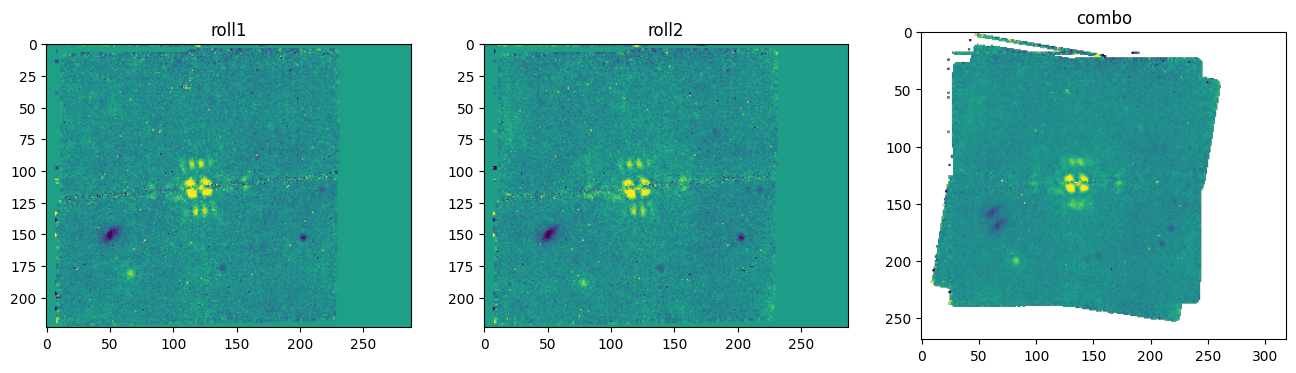

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))
vmin, vmax = np.nanquantile(np.concatenate(list([i.ravel() for i in imgs.values()])), [0.05, 0.95])
for i, roll in enumerate(imgs.keys()):
    img = imgs[roll]
    while img.ndim > 2:
        img = np.nanmean(img, axis=0)
    ax = axes[i]
    ax.set_title(roll)
    ax.imshow(img, vmin=vmin, vmax=vmax)

### Overlay sky coordinates

Overlay the RA and Dec grid over the combined rolls

In [41]:
with fits.open(i2dfiles[0]) as f:
    wcs = WCS(f[1].header)

2025-06-17 12:42:13,723 - stpipe - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/astropy/wcs/wcs.py:805: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2022-07-17T22:58:10.204' from MJD-BEG.
Set DATE-AVG to '2022-07-18T00:15:08.760' from MJD-AVG.
Set DATE-END to '2022-07-18T01:32:07.316' from MJD-END'.
  warnings.warn(



2025-06-17 12:42:13,723 - stpipe - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/astropy/wcs/wcs.py:805: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -69.981478 from OBSGEO-[XYZ].
Set OBSGEO-B to   -37.692706 from OBSGEO-[XYZ].
Set OBSGEO-H to 1737840324.368 from OBSGEO-[XYZ]'.
  warnings.warn(



In [42]:
# The star coordinates at the time of observation are in the header
exp_file = uncal_sci_r1_files[0]
targ_ra = fits.getval(exp_file, 'TARG_RA', 0)
targ_dec = fits.getval(exp_file, 'TARG_DEC', 0)
starcoord = SkyCoord(targ_ra, targ_dec, unit='deg', frame='icrs')

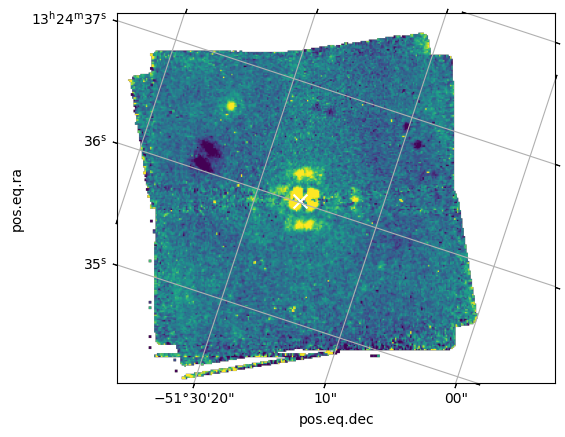

In [43]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': wcs})
vmin, vmax = np.nanquantile(imgs['combo'], [0.01, 0.99])
ax.imshow(imgs['combo'], vmin=vmin, vmax=vmax)
ax.scatter(*wcs.world_to_pixel(starcoord),
           marker='x', s=100, c='w')
ax.grid(True)

<hr style="border:1px solid gray"> </hr>

<img style="float: center;" src="https://github.com/spacetelescope/jwst-pipeline-notebooks/raw/main/_static/stsci_footer.png" alt="stsci_logo" width="200px"/> 